In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Loading the Dataset

In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Set dataset directory path
data_dir = "/kaggle/input/dataset-main/Main_Dataset"

# Define disease categories (Removed Pneumothorax)
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]

# Function to load images and masks
def load_dataset(data_dir, categories, img_size=(128, 128)):
    X = []  # Image data
    Y = []  # Labels
    masks = []  # Mask data
    valid_extensions = (".png", ".jpg", ".jpeg")  # Allowed image formats
    
    for idx, category in enumerate(categories):  # Updated index without Pneumothorax
        img_folder = os.path.join(data_dir, category, "images")  # Image path
        mask_folder = os.path.join(data_dir, category, "masks")  # Mask path

        if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
            print(f"Warning: {img_folder} or {mask_folder} does not exist.")
            continue
        
        img_files = sorted(os.listdir(img_folder))  # Sort to match masks
        mask_files = sorted(os.listdir(mask_folder))  # Sort to align with images

        for img_name, mask_name in zip(img_files, mask_files):
            img_path = os.path.join(img_folder, img_name)
            mask_path = os.path.join(mask_folder, mask_name)

            # Skip non-image files
            if not img_name.lower().endswith(valid_extensions) or not mask_name.lower().endswith(valid_extensions):
                print(f"Skipping non-image file: {img_path} or {mask_path}")
                continue

            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask

                if img is None or mask is None:
                    print(f"Skipping unreadable file: {img_path} or {mask_path}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                mask = cv2.resize(mask, img_size)

                # Normalize and append
                X.append(img / 255.0)  # Normalize image
                masks.append(mask / 255.0)  # Normalize mask
                Y.append(idx)  # Append label index (without Pneumothorax)
            except Exception as e:
                print(f"Error loading {img_path} or {mask_path}: {e}")

    X = np.array(X, dtype="float32")
    masks = np.array(masks, dtype="float32").reshape(-1, img_size[0], img_size[1], 1)  # Add channel dimension
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes=len(categories))  # One-hot encoding

    return X, masks, Y

# Load dataset (Without Pneumothorax)
X, masks, Y = load_dataset(data_dir, categories, img_size=(128, 128))

# Print dataset shape
print(f"Dataset loaded: Images {X.shape}, Masks {masks.shape}, Labels {Y.shape}")


Dataset loaded: Images (4704, 128, 128, 3), Masks (4704, 128, 128, 1), Labels (4704, 4)


### Train Test Val Split

In [5]:
import os
import cv2
import numpy as np
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Dataset directory
data_dir = "/kaggle/input/dataset-main/Main_Dataset"
output_dir = "/kaggle/working/dataset_split"

# Disease categories (Removed Pneumothorax)
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (128, 128)

# Function to create directory structure
def create_dirs(base_dir):
    for split in ["train", "val", "test"]:
        for category in categories:
            os.makedirs(os.path.join(base_dir, split, category, "images"), exist_ok=True)
            os.makedirs(os.path.join(base_dir, split, category, "masks"), exist_ok=True)

# Load dataset
def load_dataset(data_dir, categories, img_size):
    X, Y, masks, img_paths, mask_paths = [], [], [], [], []
    for idx, category in enumerate(categories):  # Updated index after removing Pneumothorax
        img_folder = os.path.join(data_dir, category, "images")
        mask_folder = os.path.join(data_dir, category, "masks")
        if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
            continue
        img_files = sorted(os.listdir(img_folder))
        mask_files = sorted(os.listdir(mask_folder))
        for img_name, mask_name in zip(img_files, mask_files):
            img_path, mask_path = os.path.join(img_folder, img_name), os.path.join(mask_folder, mask_name)
            img, mask = cv2.imread(img_path), cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is None or mask is None:
                continue
            img, mask = cv2.resize(img, img_size) / 255.0, cv2.resize(mask, img_size) / 255.0
            X.append(img), masks.append(mask.reshape(img_size[0], img_size[1], 1))
            Y.append(idx), img_paths.append(img_path), mask_paths.append(mask_path)
    return np.array(X, dtype="float32"), np.array(masks, dtype="float32"), to_categorical(Y, num_classes=len(categories)), img_paths, mask_paths

# Create directories
create_dirs(output_dir)

# Load dataset (Without Pneumothorax)
X, masks, Y, img_paths, mask_paths = load_dataset(data_dir, categories, img_size)

# Split dataset (70% Train, 15% Val, 15% Test)
X_train, X_temp, Y_train, Y_temp, masks_train, masks_temp, img_train, img_temp, mask_train, mask_temp = train_test_split(
    X, Y, masks, img_paths, mask_paths, test_size=0.30, random_state=42, stratify=Y
)
X_val, X_test, Y_val, Y_test, masks_val, masks_test, img_val, img_test, mask_val, mask_test = train_test_split(
    X_temp, Y_temp, masks_temp, img_temp, mask_temp, test_size=0.50, random_state=42, stratify=Y_temp
)

# Function to save images/masks in respective folders
def save_images(img_list, mask_list, img_paths, mask_paths, split):
    for i, (img, mask, img_path, mask_path) in enumerate(zip(img_list, mask_list, img_paths, mask_paths)):
        category = img_path.split("/")[-3]  # Extract disease category from path
        img_save_path = os.path.join(output_dir, split, category, "images", f"img_{i}.png")
        mask_save_path = os.path.join(output_dir, split, category, "masks", f"mask_{i}.png")
        cv2.imwrite(img_save_path, (img * 255).astype(np.uint8))
        cv2.imwrite(mask_save_path, (mask * 255).astype(np.uint8))

# Save images and masks
save_images(X_train, masks_train, img_train, mask_train, "train")
save_images(X_val, masks_val, img_val, mask_val, "val")
save_images(X_test, masks_test, img_test, mask_test, "test")

print(f"✅ Dataset split and saved! Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Zip the dataset
zip_file = "/kaggle/working/dataset_split.zip"
shutil.make_archive(zip_file.replace(".zip", ""), 'zip', output_dir)

print(f"✅ ZIP file created: {zip_file}")


✅ Dataset split and saved! Train: 3292, Val: 706, Test: 706
✅ ZIP file created: /kaggle/working/dataset_split.zip


### Data Augmentation

In [6]:
import os
import cv2
import numpy as np
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = "/kaggle/working/dataset_split/train"
augmented_dir = "/kaggle/working/dataset_split/augmented_images"

# Target count per disease
target_count = 4000  

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to balance dataset
def augment_and_save_fixed(train_dir, augmented_dir, target_count):
    os.makedirs(augmented_dir, exist_ok=True)

    for disease in os.listdir(train_dir):
        disease_img_dir = os.path.join(train_dir, disease, "images")
        disease_mask_dir = os.path.join(train_dir, disease, "masks")
        aug_img_dir = os.path.join(augmented_dir, disease, "images")
        aug_mask_dir = os.path.join(augmented_dir, disease, "masks")

        os.makedirs(aug_img_dir, exist_ok=True)
        os.makedirs(aug_mask_dir, exist_ok=True)

        img_files = sorted(os.listdir(disease_img_dir))
        mask_files = sorted(os.listdir(disease_mask_dir))

        num_original = len(img_files)

        if num_original > target_count:
            # If there are more than 2000 images, just pick the first 2000
            img_files = img_files[:target_count]
            mask_files = mask_files[:target_count]
            print(f"✔ {disease}: Too many images, keeping first {target_count}.")

        num_to_generate = target_count - num_original  # Number of extra images needed

        # Start index at 1 for renaming
        index = 1

        # Copy existing images if they are already within target count
        for img_name, mask_name in zip(img_files, mask_files):
            new_img_name = f"{disease}_aug_img_{index}.png"
            new_mask_name = f"{disease}_aug_mask_{index}.png"

            shutil.copy(os.path.join(disease_img_dir, img_name), os.path.join(aug_img_dir, new_img_name))
            shutil.copy(os.path.join(disease_mask_dir, mask_name), os.path.join(aug_mask_dir, new_mask_name))

            index += 1

        print(f"✔ {disease}: Copied {num_original} images.")

        # Augment images if needed
        img_idx = 0
        while num_to_generate > 0:
            img_path = os.path.join(disease_img_dir, img_files[img_idx % num_original])
            mask_path = os.path.join(disease_mask_dir, mask_files[img_idx % num_original])

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                img_idx += 1
                continue

            img = np.expand_dims(img, axis=0)  # (1, H, W, 3)
            mask = np.expand_dims(mask, axis=-1)  # (H, W, 1)
            mask = np.expand_dims(mask, axis=0)  # (1, H, W, 1)

            it_img = datagen.flow(img, batch_size=1, seed=42)
            it_mask = datagen.flow(mask, batch_size=1, seed=42)

            aug_img = next(it_img)[0].astype(np.uint8)
            aug_mask = next(it_mask)[0].astype(np.uint8).squeeze(-1)

            aug_img_name = f"{disease}_aug_img_{index}.png"
            aug_mask_name = f"{disease}_aug_mask_{index}.png"

            cv2.imwrite(os.path.join(aug_img_dir, aug_img_name), aug_img)
            cv2.imwrite(os.path.join(aug_mask_dir, aug_mask_name), aug_mask)

            index += 1
            img_idx += 1
            num_to_generate -= 1  # Reduce count needed

        print(f"✅ {disease}: Final count = {target_count}")

# Apply augmentation
augment_and_save_fixed(train_dir, augmented_dir, target_count)

# Zip the dataset
zip_file = "/kaggle/working/augmented_images.zip"
shutil.make_archive(zip_file.replace(".zip", ""), 'zip', augmented_dir)

print(f"✅ ZIP file created: {zip_file}")


✔ Covid: Copied 1050 images.
✅ Covid: Final count = 4000
✔ Viral Pneumonia: Copied 700 images.
✅ Viral Pneumonia: Final count = 4000
✔ Tuberculosis: Copied 492 images.
✅ Tuberculosis: Final count = 4000
✔ Normal: Copied 1050 images.
✅ Normal: Final count = 4000
✅ ZIP file created: /kaggle/working/augmented_images.zip


In [17]:
os.remove(zip_file)
print(f"🗑️ Deleted ZIP file: {zip_file}")

🗑️ Deleted ZIP file: /kaggle/working/augmented_images.zip


### Building MultiRes Unet Model and training it

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, backend as K

# ---------------------- Dice & Jaccard Metrics ----------------------
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    return 2 * intersection / (K.sum(y_true) + K.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + smooth)


In [3]:
# ---------------------- MultiResUNet Model ----------------------
def conv_block(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def multi_res_block(x, filters, kernel_size=3):
    # First resolution
    x1 = conv_block(x, filters, kernel_size)
    
    # Second resolution (dilated convolution)
    x2 = conv_block(x, filters, kernel_size, strides=2)
    
    # Third resolution (pooled convolution)
    x3 = conv_block(x, filters, kernel_size, strides=4)
    
    # Upsample all the branches to the same size
    x2 = layers.UpSampling2D(size=(2, 2))(x2)  # Upsample to match x1
    x3 = layers.UpSampling2D(size=(4, 4))(x3)  # Upsample to match x1
    
    # Concatenate all the resolutions
    x = layers.concatenate([x1, x2, x3], axis=-1)
    return x

def MultiResUnet(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Downsampling with MultiRes Blocks
    x = multi_res_block(inputs, 64)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    x = multi_res_block(x, 128)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    x = multi_res_block(x, 256)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Bottleneck
    x = multi_res_block(x, 512)

    # Decoder: Upsampling
    x = layers.UpSampling2D(size=2)(x)
    x = multi_res_block(x, 256)

    x = layers.UpSampling2D(size=2)(x)
    x = multi_res_block(x, 128)

    x = layers.UpSampling2D(size=2)(x)
    x = multi_res_block(x, 64)

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Create the Model
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [4]:
# ---------------------- Data Loading ----------------------
# Paths
TRAIN_PATH = "/kaggle/input/augmented-images/augmented_images"  # Augmented train set
VAL_PATH = "/kaggle/input/dataset-split/val"  # Original validation set
TEST_PATH = "/kaggle/input/dataset-split/test"  # Original test set

# Function to load images and masks
def load_data(dataset_path, image_size=(128, 128)):
    images, masks = [], []
    disease_categories = os.listdir(dataset_path)

    for disease in disease_categories:
        image_folder = os.path.join(dataset_path, disease, "images")
        mask_folder = os.path.join(dataset_path, disease, "masks")

        image_files = sorted(os.listdir(image_folder))
        mask_files = sorted(os.listdir(mask_folder))

        for img_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)

            # Load and preprocess images/masks
            img = load_img(img_path, target_size=image_size)
            mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")

            img_array = img_to_array(img) / 255.0
            mask_array = img_to_array(mask) / 255.0  # Ensure binary segmentation

            images.append(img_array)
            masks.append(mask_array)

    return np.array(images), np.array(masks)

# Load augmented train data
X_train, Y_train = load_data(TRAIN_PATH)

# Load original validation and test data
X_val, Y_val = load_data(VAL_PATH)
X_test, Y_test = load_data(TEST_PATH)

# Print dataset shapes
print(f"Train: {X_train.shape}, {Y_train.shape}")
print(f"Validation: {X_val.shape}, {Y_val.shape}")
print(f"Test: {X_test.shape}, {Y_test.shape}")

Train: (10000, 128, 128, 3), (10000, 128, 128, 1)
Validation: (706, 128, 128, 3), (706, 128, 128, 1)
Test: (706, 128, 128, 3), (706, 128, 128, 1)


In [5]:
# ---------------------- Model Training ----------------------
# Compile the model
model = MultiResUnet(input_shape=(128, 128, 3), num_classes=1)

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', dice_coefficient, jaccard_index]
)

In [6]:
# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 326s 439ms/step - accuracy: 0.8966 - dice_coefficient: 0.7987 - jaccard_index: 0.6787 - loss: 0.2141 - val_accuracy: 0.9418 - val_dice_coefficient: 0.8465 - val_jaccard_index: 0.7372 - val_loss: 0.1263
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 277s 444ms/step - accuracy: 0.9497 - dice_coefficient: 0.9226 - jaccard_index: 0.8566 - loss: 0.0697 - val_accuracy: 0.9707 - val_dice_coefficient: 0.9294 - val_jaccard_index: 0.8688 - val_loss: 0.0547
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 278s 445ms/step - accuracy: 0.9550 - dice_coefficient: 0.9393 - jaccard_index: 0.8857 - loss: 0.0538 - val_accuracy: 0.9704 - val_dice_coefficient: 0.9295 - val_jaccard_index: 0.8689 - val_loss: 0.0575
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 278s 444ms/step - accuracy: 0.9567 - dice_coefficient: 0.9464 - jaccard_index: 0.8983 - loss: 0.0474 - val_accuracy: 0.8276 - val_dice_coefficient: 0.4810 - val_jaccard_index: 0.3304 - val_loss: 0.6198
Epoch 5/20
625/625 ━━━━━━━━━━━━━

In [7]:
# ---------------------- Evaluate on Test Set ----------------------
test_loss, test_acc, test_dice, test_jaccard = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.4f}, Dice Coefficient: {test_dice:.4f}, Jaccard Index: {test_jaccard:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.9777 - dice_coefficient: 0.9572 - jaccard_index: 0.9181 - loss: 0.0500
Test Accuracy: 0.9753, Dice Coefficient: 0.9573, Jaccard Index: 0.9182


In [9]:
# Save model
model.save("/kaggle/working/multiresunet_lung_segmentation.h5")
print("Model saved successfully!")

Model saved successfully!


### Testing MultiRes Unet Model for prediction of masks

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


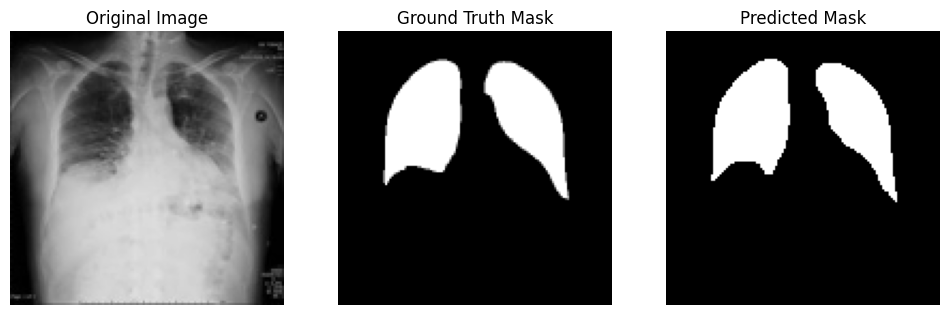

In [9]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load trained model
model_path = "/kaggle/input/mutiresunet-lung-segmentation/tensorflow2/default/1/multiresunet_lung_segmentation.h5"
model = tf.keras.models.load_model(model_path, custom_objects={
    'dice_coefficient': dice_coefficient,
    'jaccard_index': jaccard_index
})

# Define test data directory
test_data_dir = "/kaggle/input/dataset-split/test"

# Disease categories
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]

# Function to load and preprocess a test image and its mask
def load_test_image_mask(category, img_size=(128, 128)):
    img_folder = os.path.join(test_data_dir, category, "images")
    mask_folder = os.path.join(test_data_dir, category, "masks")
    
    img_files = sorted(os.listdir(img_folder))
    mask_files = sorted(os.listdir(mask_folder))
    
    if len(img_files) == 0 or len(mask_files) == 0:
        print(f"No test data found for {category}")
        return None, None

    img_path = os.path.join(img_folder, img_files[2])  # Load first test image
    mask_path = os.path.join(mask_folder, mask_files[2])  # Load first mask

    # Read and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img_norm = img / 255.0  # Normalize

    # Read and preprocess mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = mask / 255.0  # Normalize

    return img, mask, img_norm

# Pick a category and load a test sample
category = "Covid"  # Change this to any category
img, mask, img_norm = load_test_image_mask(category)

# Predict mask
if img is not None and mask is not None:
    img_input = np.expand_dims(img_norm, axis=0)  # Add batch dimension
    predicted_mask = model.predict(img_input)[0]  # Get prediction
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(predicted_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.show()
else:
    print("Could not load test image/mask.")


### Trying xray enhancement techniques for AND operation

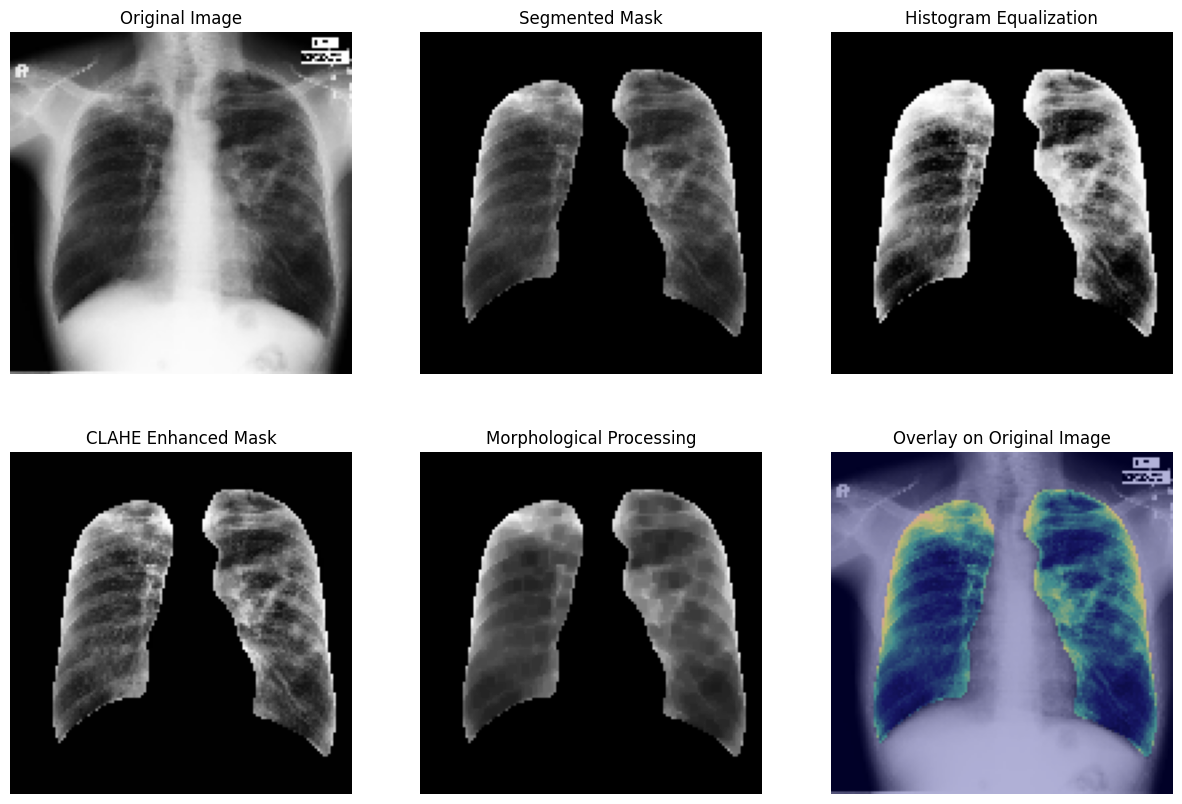

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load original image and mask (update paths as needed)
original_img_path = "/kaggle/input/dataset-split/test/Tuberculosis/images/img_510.png"  # Replace with actual path
segmented_mask_path = "/kaggle/input/segmented-images/Tuberculosis/segmented_img_510.png"  # Replace with actual path

# Read images
original_img = cv2.imread(original_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB

segmented_mask = cv2.imread(segmented_mask_path, cv2.IMREAD_GRAYSCALE)

# Ensure images are the same size
segmented_mask = cv2.resize(segmented_mask, (original_img.shape[1], original_img.shape[0]))

# 1️⃣ Histogram Equalization
equalized_mask = cv2.equalizeHist(segmented_mask)

# 2️⃣ CLAHE (Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_mask = clahe.apply(segmented_mask)

# 3️⃣ Morphological Operations
kernel = np.ones((3, 3), np.uint8)
dilated_mask = cv2.dilate(segmented_mask, kernel, iterations=1)
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

# 4️⃣ Apply Colormap for Better Visualization
color_mask = cv2.applyColorMap(segmented_mask, cv2.COLORMAP_JET)

# 5️⃣ Overlay Mask on Original Image
overlay = cv2.addWeighted(original_img, 0.7, cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB), 0.3, 0)

# Plot Results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(original_img); axes[0, 0].set_title("Original Image"); axes[0, 0].axis("off")
axes[0, 1].imshow(segmented_mask, cmap="gray"); axes[0, 1].set_title("Segmented Mask"); axes[0, 1].axis("off")
axes[0, 2].imshow(equalized_mask, cmap="gray"); axes[0, 2].set_title("Histogram Equalization"); axes[0, 2].axis("off")
axes[1, 0].imshow(clahe_mask, cmap="gray"); axes[1, 0].set_title("CLAHE Enhanced Mask"); axes[1, 0].axis("off")
axes[1, 1].imshow(eroded_mask, cmap="gray"); axes[1, 1].set_title("Morphological Processing"); axes[1, 1].axis("off")
axes[1, 2].imshow(overlay); axes[1, 2].set_title("Overlay on Original Image"); axes[1, 2].axis("off")

plt.show()


### AND operation Mask and Image -> Segmented Images

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import shutil
from tqdm import tqdm
import zipfile

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    return 2 * intersection / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + smooth)

# Load trained model
model_path = "/kaggle/input/mutiresunet-lung-segmentation/tensorflow2/default/1/multiresunet_lung_segmentation.h5"
model = tf.keras.models.load_model(model_path, custom_objects={
    'dice_coefficient': dice_coefficient,
    'jaccard_index': jaccard_index
})

# Define paths
test_data_dir = "/kaggle/input/dataset-split/train"
segmented_output_dir = "/kaggle/working/segmented_images_train"

# Ensure output directory is clean
if os.path.exists(segmented_output_dir):
    shutil.rmtree(segmented_output_dir)
os.makedirs(segmented_output_dir)

# Disease categories
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]

# Function to apply CLAHE
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)  # Split channels
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)  # Apply CLAHE to the L-channel
    
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge channels back
    enhanced_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)  # Convert back to RGB
    return enhanced_image

# Function to process images
def segment_images(category, img_size=(128, 128)):
    img_folder = os.path.join(test_data_dir, category, "images")
    save_folder = os.path.join(segmented_output_dir, category)
    os.makedirs(save_folder, exist_ok=True)
    img_files = sorted(os.listdir(img_folder))

    for img_name in tqdm(img_files, desc=f"Processing {category}"):
        img_path = os.path.join(img_folder, img_name)
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, img_size) / 255.0  # Normalize
        img_input = np.expand_dims(img_resized, axis=0)  # Add batch dimension

        # Predict mask
        predicted_mask = model.predict(img_input)[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold

        # Resize mask to original size
        mask_resized = cv2.resize(predicted_mask, (img.shape[1], img.shape[0]))

        # Apply mask to image (AND operation)
        segmented = img * np.expand_dims(mask_resized, axis=-1)
        
        # Apply CLAHE for contrast enhancement
        enhanced_segmented = apply_clahe(segmented)

        # Save segmented image
        segmented_name = os.path.join(save_folder, f"segmented_{img_name}")
        cv2.imwrite(segmented_name, cv2.cvtColor(enhanced_segmented, cv2.COLOR_RGB2BGR))

# Segment images for all categories
for category in categories:
    segment_images(category)

# Zip the segmented images folder
zip_path = "/kaggle/working/segmented_images_train.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(segmented_output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, segmented_output_dir))

print(f"Segmented images saved and zipped at {zip_path}")


Processing Covid:   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing Covid:   0%|          | 1/1050 [00:04<1:19:38,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   0%|          | 3/1050 [00:04<21:34,  1.24s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   0%|          | 5/1050 [00:04<11:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   1%|          | 7/1050 [00:04<06:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   1%|          | 9/1050 [00:05<04:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   1%|          | 11/1050 [00:05<03:30,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   1%|          | 13/1050 [00:05<02:45,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:   1%|▏         | 15/1050 [00:05<02:15,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   2%|▏         | 17/1050 [00:05<01:57,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   2%|▏         | 19/1050 [00:05<01:44,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   2%|▏         | 21/1050 [00:06<01:36, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   2%|▏         | 23/1050 [00:06<01:31, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   2%|▏         | 25/1050 [00:06<01:28, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   3%|▎         | 27/1050 [00:06<01:27, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   3%|▎         | 29/1050 [00:06<01:26, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   3%|▎         | 31/1050 [00:06<01:24, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   3%|▎         | 33/1050 [00:06<01:24, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   3%|▎         | 35/1050 [00:07<01:23, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   4%|▎         | 37/1050 [00:07<01:23, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   4%|▎         | 39/1050 [00:07<01:24, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   4%|▍         | 41/1050 [00:07<01:24, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   4%|▍         | 43/1050 [00:07<01:23, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   4%|▍         | 45/1050 [00:07<01:23, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   4%|▍         | 47/1050 [00:08<01:23, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   5%|▍         | 49/1050 [00:08<01:23, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   5%|▍         | 51/1050 [00:08<01:23, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   5%|▌         | 53/1050 [00:08<01:24, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   5%|▌         | 55/1050 [00:08<01:24, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   5%|▌         | 57/1050 [00:08<01:23, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   6%|▌         | 59/1050 [00:09<01:23, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   6%|▌         | 61/1050 [00:09<01:23, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   6%|▌         | 63/1050 [00:09<01:23, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   6%|▌         | 65/1050 [00:09<01:23, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   6%|▋         | 67/1050 [00:09<01:22, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   7%|▋         | 69/1050 [00:10<01:22, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   7%|▋         | 71/1050 [00:10<01:21, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:   7%|▋         | 73/1050 [00:10<01:22, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   7%|▋         | 75/1050 [00:10<01:22, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   7%|▋         | 77/1050 [00:10<01:22, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   8%|▊         | 79/1050 [00:10<01:27, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   8%|▊         | 81/1050 [00:11<01:25, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   8%|▊         | 83/1050 [00:11<01:23, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Covid:   8%|▊         | 85/1050 [00:11<01:26, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:   8%|▊         | 87/1050 [00:11<01:26, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:   8%|▊         | 89/1050 [00:11<01:25, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   9%|▊         | 91/1050 [00:11<01:24, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   9%|▉         | 93/1050 [00:12<01:23, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   9%|▉         | 95/1050 [00:12<01:22, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:   9%|▉         | 97/1050 [00:12<01:21, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:   9%|▉         | 99/1050 [00:12<01:20, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  10%|▉         | 101/1050 [00:12<01:20, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  10%|▉         | 103/1050 [00:12<01:20, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  10%|█         | 105/1050 [00:13<01:19, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  10%|█         | 107/1050 [00:13<01:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  10%|█         | 109/1050 [00:13<01:19, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  11%|█         | 111/1050 [00:13<01:19, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  11%|█         | 113/1050 [00:13<01:19, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  11%|█         | 115/1050 [00:13<01:18, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  11%|█         | 117/1050 [00:14<01:18, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  11%|█▏        | 119/1050 [00:14<01:18, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  12%|█▏        | 121/1050 [00:14<01:18, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  12%|█▏        | 123/1050 [00:14<01:17, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  12%|█▏        | 125/1050 [00:14<01:17, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  12%|█▏        | 127/1050 [00:14<01:17, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  12%|█▏        | 129/1050 [00:15<01:16, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  12%|█▏        | 131/1050 [00:15<01:17, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  13%|█▎        | 133/1050 [00:15<01:16, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  13%|█▎        | 135/1050 [00:15<01:16, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  13%|█▎        | 137/1050 [00:15<01:17, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  13%|█▎        | 139/1050 [00:15<01:18, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  13%|█▎        | 141/1050 [00:16<01:18, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  14%|█▎        | 143/1050 [00:16<01:20, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  14%|█▍        | 145/1050 [00:16<01:22, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  14%|█▍        | 147/1050 [00:16<01:20, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  14%|█▍        | 149/1050 [00:16<01:22, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  14%|█▍        | 151/1050 [00:17<01:22, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Covid:  15%|█▍        | 153/1050 [00:17<01:24, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  15%|█▍        | 155/1050 [00:17<01:26, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  15%|█▍        | 157/1050 [00:17<01:22, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  15%|█▌        | 159/1050 [00:17<01:20, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  15%|█▌        | 161/1050 [00:18<01:18, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  16%|█▌        | 163/1050 [00:18<01:17, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  16%|█▌        | 165/1050 [00:18<01:16, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  16%|█▌        | 167/1050 [00:18<01:15, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  16%|█▌        | 169/1050 [00:18<01:15, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  16%|█▋        | 171/1050 [00:18<01:14, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  16%|█▋        | 173/1050 [00:19<01:15, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  17%|█▋        | 175/1050 [00:19<01:14, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  17%|█▋        | 177/1050 [00:19<01:13, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  17%|█▋        | 179/1050 [00:19<01:13, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  17%|█▋        | 181/1050 [00:19<01:12, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  17%|█▋        | 183/1050 [00:19<01:12, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  18%|█▊        | 185/1050 [00:20<01:12, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  18%|█▊        | 187/1050 [00:20<01:12, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  18%|█▊        | 189/1050 [00:20<01:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  18%|█▊        | 191/1050 [00:20<01:12, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  18%|█▊        | 193/1050 [00:20<01:12, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  19%|█▊        | 195/1050 [00:20<01:12, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  19%|█▉        | 197/1050 [00:21<01:12, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  19%|█▉        | 199/1050 [00:21<01:12, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Covid:  19%|█▉        | 201/1050 [00:21<01:14, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  19%|█▉        | 203/1050 [00:21<01:13, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  20%|█▉        | 205/1050 [00:21<01:12, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  20%|█▉        | 207/1050 [00:21<01:11, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  20%|█▉        | 209/1050 [00:22<01:12, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  20%|██        | 211/1050 [00:22<01:11, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  20%|██        | 213/1050 [00:22<01:11, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  20%|██        | 215/1050 [00:22<01:10, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  21%|██        | 217/1050 [00:22<01:10, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  21%|██        | 219/1050 [00:22<01:09, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  21%|██        | 221/1050 [00:23<01:09, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  21%|██        | 223/1050 [00:23<01:09, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  21%|██▏       | 225/1050 [00:23<01:11, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  22%|██▏       | 227/1050 [00:23<01:11, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  22%|██▏       | 229/1050 [00:23<01:10, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  22%|██▏       | 231/1050 [00:23<01:09, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  22%|██▏       | 233/1050 [00:24<01:09, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  22%|██▏       | 235/1050 [00:24<01:10, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  23%|██▎       | 237/1050 [00:24<01:09, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  23%|██▎       | 239/1050 [00:24<01:08, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Covid:  23%|██▎       | 241/1050 [00:24<01:09, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  23%|██▎       | 243/1050 [00:24<01:09, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  23%|██▎       | 245/1050 [00:25<01:09, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  24%|██▎       | 247/1050 [00:25<01:09, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  24%|██▎       | 249/1050 [00:25<01:08, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  24%|██▍       | 251/1050 [00:25<01:07, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  24%|██▍       | 253/1050 [00:25<01:08, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  24%|██▍       | 255/1050 [00:25<01:07, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  24%|██▍       | 257/1050 [00:26<01:08, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  25%|██▍       | 259/1050 [00:26<01:07, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  25%|██▍       | 261/1050 [00:26<01:07, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  25%|██▌       | 263/1050 [00:26<01:06, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  25%|██▌       | 265/1050 [00:26<01:06, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  25%|██▌       | 267/1050 [00:27<01:06, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  26%|██▌       | 269/1050 [00:27<01:06, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  26%|██▌       | 271/1050 [00:27<01:06, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  26%|██▌       | 273/1050 [00:27<01:12, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  26%|██▌       | 275/1050 [00:27<01:11, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  26%|██▋       | 277/1050 [00:27<01:09, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  27%|██▋       | 279/1050 [00:28<01:08, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  27%|██▋       | 281/1050 [00:28<01:07, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  27%|██▋       | 283/1050 [00:28<01:06, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  27%|██▋       | 285/1050 [00:28<01:06, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  27%|██▋       | 287/1050 [00:28<01:05, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  28%|██▊       | 289/1050 [00:28<01:04, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  28%|██▊       | 291/1050 [00:29<01:04, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  28%|██▊       | 293/1050 [00:29<01:04, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  28%|██▊       | 295/1050 [00:29<01:03, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  28%|██▊       | 297/1050 [00:29<01:03, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  28%|██▊       | 299/1050 [00:29<01:04, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  29%|██▊       | 301/1050 [00:29<01:05, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  29%|██▉       | 303/1050 [00:30<01:04, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  29%|██▉       | 305/1050 [00:30<01:05, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  29%|██▉       | 307/1050 [00:30<01:04, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  29%|██▉       | 309/1050 [00:30<01:02, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  30%|██▉       | 311/1050 [00:30<01:03, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  30%|██▉       | 313/1050 [00:31<01:04, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  30%|███       | 315/1050 [00:31<01:05, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Covid:  30%|███       | 317/1050 [00:31<01:06, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  30%|███       | 319/1050 [00:31<01:04, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  31%|███       | 321/1050 [00:31<01:03, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  31%|███       | 323/1050 [00:31<01:02, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  31%|███       | 325/1050 [00:32<01:02, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  31%|███       | 327/1050 [00:32<01:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  31%|███▏      | 329/1050 [00:32<01:01, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  32%|███▏      | 331/1050 [00:32<01:01, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  32%|███▏      | 333/1050 [00:32<01:02, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  32%|███▏      | 335/1050 [00:32<01:03, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  32%|███▏      | 337/1050 [00:33<01:02, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  32%|███▏      | 339/1050 [00:33<01:02, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  32%|███▏      | 341/1050 [00:33<01:02, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  33%|███▎      | 343/1050 [00:33<01:01, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  33%|███▎      | 345/1050 [00:33<01:00, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  33%|███▎      | 347/1050 [00:33<00:59, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  33%|███▎      | 349/1050 [00:34<00:59, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  33%|███▎      | 351/1050 [00:34<00:58, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  34%|███▎      | 353/1050 [00:34<00:58, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  34%|███▍      | 355/1050 [00:34<00:58, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  34%|███▍      | 357/1050 [00:34<00:58, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  34%|███▍      | 359/1050 [00:34<00:58, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  34%|███▍      | 361/1050 [00:35<01:00, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  35%|███▍      | 363/1050 [00:35<01:00, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  35%|███▍      | 365/1050 [00:35<00:59, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  35%|███▍      | 367/1050 [00:35<00:59, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  35%|███▌      | 369/1050 [00:35<00:58, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  35%|███▌      | 371/1050 [00:36<00:58, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  36%|███▌      | 373/1050 [00:36<00:58, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  36%|███▌      | 375/1050 [00:36<00:57, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  36%|███▌      | 377/1050 [00:36<00:57, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  36%|███▌      | 379/1050 [00:36<00:57, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  36%|███▋      | 381/1050 [00:36<00:59, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  36%|███▋      | 383/1050 [00:37<00:57, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  37%|███▋      | 385/1050 [00:37<00:57, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  37%|███▋      | 387/1050 [00:37<00:57, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  37%|███▋      | 389/1050 [00:37<00:57, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  37%|███▋      | 391/1050 [00:37<00:56, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  37%|███▋      | 393/1050 [00:37<00:56, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  38%|███▊      | 395/1050 [00:38<00:57, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  38%|███▊      | 397/1050 [00:38<00:56, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  38%|███▊      | 399/1050 [00:38<00:56, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  38%|███▊      | 401/1050 [00:38<00:56, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  38%|███▊      | 403/1050 [00:38<00:56, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  39%|███▊      | 405/1050 [00:38<00:55, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  39%|███▉      | 407/1050 [00:39<00:55, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  39%|███▉      | 409/1050 [00:39<00:55, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  39%|███▉      | 411/1050 [00:39<00:55, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  39%|███▉      | 413/1050 [00:39<00:55, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  40%|███▉      | 415/1050 [00:39<00:55, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  40%|███▉      | 417/1050 [00:40<00:54, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  40%|███▉      | 419/1050 [00:40<00:53, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  40%|████      | 421/1050 [00:40<00:54, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  40%|████      | 423/1050 [00:40<00:55, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  40%|████      | 425/1050 [00:40<00:55, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  41%|████      | 427/1050 [00:40<00:54, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  41%|████      | 429/1050 [00:41<00:53, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  41%|████      | 431/1050 [00:41<00:53, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  41%|████      | 433/1050 [00:41<00:54, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  41%|████▏     | 435/1050 [00:41<00:53, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  42%|████▏     | 437/1050 [00:41<00:52, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  42%|████▏     | 439/1050 [00:41<00:52, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  42%|████▏     | 441/1050 [00:42<00:51, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  42%|████▏     | 443/1050 [00:42<00:51, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  42%|████▏     | 445/1050 [00:42<00:51, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  43%|████▎     | 447/1050 [00:42<00:51, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  43%|████▎     | 449/1050 [00:42<00:52, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  43%|████▎     | 451/1050 [00:42<00:51, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  43%|████▎     | 453/1050 [00:43<00:51, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  43%|████▎     | 455/1050 [00:43<00:51, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  44%|████▎     | 457/1050 [00:43<00:50, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  44%|████▎     | 459/1050 [00:43<00:51, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  44%|████▍     | 461/1050 [00:43<00:51, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  44%|████▍     | 463/1050 [00:44<00:51, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  44%|████▍     | 465/1050 [00:44<00:50, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  44%|████▍     | 467/1050 [00:44<00:50, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  45%|████▍     | 469/1050 [00:44<00:50, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  45%|████▍     | 471/1050 [00:44<00:49, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  45%|████▌     | 473/1050 [00:44<00:48, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  45%|████▌     | 475/1050 [00:45<00:48, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  45%|████▌     | 477/1050 [00:45<00:48, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  46%|████▌     | 479/1050 [00:45<00:47, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  46%|████▌     | 481/1050 [00:45<00:48, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  46%|████▌     | 483/1050 [00:45<00:48, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  46%|████▌     | 485/1050 [00:45<00:48, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  46%|████▋     | 487/1050 [00:46<00:47, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  47%|████▋     | 489/1050 [00:46<00:47, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  47%|████▋     | 491/1050 [00:46<00:51, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  47%|████▋     | 493/1050 [00:46<00:49, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  47%|████▋     | 495/1050 [00:46<00:48, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  47%|████▋     | 497/1050 [00:46<00:48, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  48%|████▊     | 499/1050 [00:47<00:47, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  48%|████▊     | 501/1050 [00:47<00:46, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  48%|████▊     | 503/1050 [00:47<00:46, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  48%|████▊     | 505/1050 [00:47<00:46, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  48%|████▊     | 507/1050 [00:47<00:47, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  48%|████▊     | 509/1050 [00:48<00:51, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  49%|████▊     | 511/1050 [00:48<00:51, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  49%|████▉     | 513/1050 [00:48<00:49, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Covid:  49%|████▉     | 515/1050 [00:48<00:49, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  49%|████▉     | 517/1050 [00:48<00:48, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  49%|████▉     | 519/1050 [00:48<00:47, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  50%|████▉     | 521/1050 [00:49<00:46, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  50%|████▉     | 523/1050 [00:49<00:46, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  50%|█████     | 525/1050 [00:49<00:46, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  50%|█████     | 527/1050 [00:49<00:45, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  50%|█████     | 529/1050 [00:49<00:45, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  51%|█████     | 531/1050 [00:49<00:44, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  51%|█████     | 533/1050 [00:50<00:44, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  51%|█████     | 535/1050 [00:50<00:44, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  51%|█████     | 537/1050 [00:50<00:44, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  51%|█████▏    | 539/1050 [00:50<00:43, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  52%|█████▏    | 541/1050 [00:50<00:43, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  52%|█████▏    | 543/1050 [00:50<00:43, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  52%|█████▏    | 545/1050 [00:51<00:43, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  52%|█████▏    | 547/1050 [00:51<00:43, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  52%|█████▏    | 549/1050 [00:51<00:44, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  52%|█████▏    | 551/1050 [00:51<00:43, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  53%|█████▎    | 553/1050 [00:51<00:42, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  53%|█████▎    | 555/1050 [00:52<00:43, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  53%|█████▎    | 557/1050 [00:52<00:43, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  53%|█████▎    | 559/1050 [00:52<00:42, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  53%|█████▎    | 561/1050 [00:52<00:42, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  54%|█████▎    | 563/1050 [00:52<00:41, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  54%|█████▍    | 565/1050 [00:52<00:41, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  54%|█████▍    | 567/1050 [00:53<00:41, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  54%|█████▍    | 569/1050 [00:53<00:44, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  54%|█████▍    | 571/1050 [00:53<00:43, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  55%|█████▍    | 573/1050 [00:53<00:42, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  55%|█████▍    | 575/1050 [00:53<00:41, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  55%|█████▍    | 577/1050 [00:53<00:41, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  55%|█████▌    | 579/1050 [00:54<00:40, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  55%|█████▌    | 581/1050 [00:54<00:40, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  56%|█████▌    | 583/1050 [00:54<00:39, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  56%|█████▌    | 585/1050 [00:54<00:39, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  56%|█████▌    | 587/1050 [00:54<00:39, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  56%|█████▌    | 589/1050 [00:54<00:38, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  56%|█████▋    | 591/1050 [00:55<00:38, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  56%|█████▋    | 593/1050 [00:55<00:39, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  57%|█████▋    | 595/1050 [00:55<00:38, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  57%|█████▋    | 597/1050 [00:55<00:38, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  57%|█████▋    | 599/1050 [00:55<00:38, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  57%|█████▋    | 601/1050 [00:55<00:37, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  57%|█████▋    | 603/1050 [00:56<00:37, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  58%|█████▊    | 605/1050 [00:56<00:37, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  58%|█████▊    | 607/1050 [00:56<00:37, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  58%|█████▊    | 609/1050 [00:56<00:36, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  58%|█████▊    | 611/1050 [00:56<00:36, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  58%|█████▊    | 613/1050 [00:56<00:36, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  59%|█████▊    | 615/1050 [00:57<00:36, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  59%|█████▉    | 617/1050 [00:57<00:36, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  59%|█████▉    | 619/1050 [00:57<00:36, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  59%|█████▉    | 621/1050 [00:57<00:36, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  59%|█████▉    | 623/1050 [00:57<00:37, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  60%|█████▉    | 625/1050 [00:58<00:36, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  60%|█████▉    | 627/1050 [00:58<00:36, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  60%|█████▉    | 629/1050 [00:58<00:36, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  60%|██████    | 631/1050 [00:58<00:35, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  60%|██████    | 633/1050 [00:58<00:35, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  60%|██████    | 635/1050 [00:58<00:35, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  61%|██████    | 637/1050 [00:59<00:35, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  61%|██████    | 639/1050 [00:59<00:34, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  61%|██████    | 641/1050 [00:59<00:34, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Covid:  61%|██████    | 643/1050 [00:59<00:34, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  61%|██████▏   | 645/1050 [00:59<00:34, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  62%|██████▏   | 647/1050 [00:59<00:33, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  62%|██████▏   | 649/1050 [01:00<00:33, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  62%|██████▏   | 651/1050 [01:00<00:33, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  62%|██████▏   | 653/1050 [01:00<00:33, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  62%|██████▏   | 655/1050 [01:00<00:33, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  63%|██████▎   | 657/1050 [01:00<00:33, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  63%|██████▎   | 659/1050 [01:00<00:32, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  63%|██████▎   | 661/1050 [01:01<00:32, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  63%|██████▎   | 663/1050 [01:01<00:32, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Covid:  63%|██████▎   | 665/1050 [01:01<00:33, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  64%|██████▎   | 667/1050 [01:01<00:33, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  64%|██████▎   | 669/1050 [01:01<00:32, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  64%|██████▍   | 671/1050 [01:01<00:32, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  64%|██████▍   | 673/1050 [01:02<00:32, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  64%|██████▍   | 675/1050 [01:02<00:32, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  64%|██████▍   | 677/1050 [01:02<00:32, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  65%|██████▍   | 679/1050 [01:02<00:31, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  65%|██████▍   | 681/1050 [01:02<00:31, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  65%|██████▌   | 683/1050 [01:02<00:31, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  65%|██████▌   | 685/1050 [01:03<00:31, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  65%|██████▌   | 687/1050 [01:03<00:30, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  66%|██████▌   | 689/1050 [01:03<00:30, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  66%|██████▌   | 691/1050 [01:03<00:30, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  66%|██████▌   | 693/1050 [01:03<00:30, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  66%|██████▌   | 695/1050 [01:03<00:29, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  66%|██████▋   | 697/1050 [01:04<00:29, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  67%|██████▋   | 699/1050 [01:04<00:29, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  67%|██████▋   | 701/1050 [01:04<00:29, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  67%|██████▋   | 703/1050 [01:04<00:29, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  67%|██████▋   | 705/1050 [01:04<00:29, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  67%|██████▋   | 707/1050 [01:04<00:29, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  68%|██████▊   | 709/1050 [01:05<00:29, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  68%|██████▊   | 711/1050 [01:05<00:28, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  68%|██████▊   | 713/1050 [01:05<00:28, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  68%|██████▊   | 715/1050 [01:05<00:28, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  68%|██████▊   | 717/1050 [01:05<00:27, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  68%|██████▊   | 719/1050 [01:05<00:27, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  69%|██████▊   | 721/1050 [01:06<00:27, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  69%|██████▉   | 723/1050 [01:06<00:27, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  69%|██████▉   | 725/1050 [01:06<00:27, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  69%|██████▉   | 727/1050 [01:06<00:27, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  69%|██████▉   | 729/1050 [01:06<00:27, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  70%|██████▉   | 731/1050 [01:07<00:27, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  70%|██████▉   | 733/1050 [01:07<00:26, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  70%|███████   | 735/1050 [01:07<00:26, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  70%|███████   | 737/1050 [01:07<00:26, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  70%|███████   | 739/1050 [01:07<00:26, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  71%|███████   | 741/1050 [01:07<00:25, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  71%|███████   | 743/1050 [01:08<00:25, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  71%|███████   | 745/1050 [01:08<00:25, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  71%|███████   | 747/1050 [01:08<00:25, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  71%|███████▏  | 749/1050 [01:08<00:25, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  72%|███████▏  | 751/1050 [01:08<00:25, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  72%|███████▏  | 753/1050 [01:08<00:25, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  72%|███████▏  | 755/1050 [01:09<00:25, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  72%|███████▏  | 757/1050 [01:09<00:24, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  72%|███████▏  | 759/1050 [01:09<00:24, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  72%|███████▏  | 761/1050 [01:09<00:24, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  73%|███████▎  | 763/1050 [01:09<00:24, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  73%|███████▎  | 765/1050 [01:09<00:23, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  73%|███████▎  | 767/1050 [01:10<00:23, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  73%|███████▎  | 769/1050 [01:10<00:23, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  73%|███████▎  | 771/1050 [01:10<00:23, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  74%|███████▎  | 773/1050 [01:10<00:24, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  74%|███████▍  | 775/1050 [01:10<00:23, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  74%|███████▍  | 777/1050 [01:10<00:23, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  74%|███████▍  | 779/1050 [01:11<00:23, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  74%|███████▍  | 781/1050 [01:11<00:22, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  75%|███████▍  | 783/1050 [01:11<00:23, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  75%|███████▍  | 785/1050 [01:11<00:22, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  75%|███████▍  | 787/1050 [01:11<00:22, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  75%|███████▌  | 789/1050 [01:11<00:22, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  75%|███████▌  | 791/1050 [01:12<00:21, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  76%|███████▌  | 793/1050 [01:12<00:21, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  76%|███████▌  | 795/1050 [01:12<00:21, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  76%|███████▌  | 797/1050 [01:12<00:21, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  76%|███████▌  | 799/1050 [01:12<00:21, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  76%|███████▋  | 801/1050 [01:12<00:21, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  76%|███████▋  | 803/1050 [01:13<00:20, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  77%|███████▋  | 805/1050 [01:13<00:20, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  77%|███████▋  | 807/1050 [01:13<00:20, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  77%|███████▋  | 809/1050 [01:13<00:20, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  77%|███████▋  | 811/1050 [01:13<00:20, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  77%|███████▋  | 813/1050 [01:13<00:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  78%|███████▊  | 815/1050 [01:14<00:19, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  78%|███████▊  | 817/1050 [01:14<00:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  78%|███████▊  | 819/1050 [01:14<00:19, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  78%|███████▊  | 821/1050 [01:14<00:19, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  78%|███████▊  | 823/1050 [01:14<00:19, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  79%|███████▊  | 825/1050 [01:14<00:18, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  79%|███████▉  | 827/1050 [01:15<00:18, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  79%|███████▉  | 829/1050 [01:15<00:18, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  79%|███████▉  | 831/1050 [01:15<00:18, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  79%|███████▉  | 833/1050 [01:15<00:18, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  80%|███████▉  | 835/1050 [01:15<00:18, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  80%|███████▉  | 837/1050 [01:15<00:18, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  80%|███████▉  | 839/1050 [01:16<00:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  80%|████████  | 841/1050 [01:16<00:17, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  80%|████████  | 843/1050 [01:16<00:17, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  80%|████████  | 845/1050 [01:16<00:17, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  81%|████████  | 847/1050 [01:16<00:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  81%|████████  | 849/1050 [01:17<00:17, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  81%|████████  | 851/1050 [01:17<00:16, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  81%|████████  | 853/1050 [01:17<00:16, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  81%|████████▏ | 855/1050 [01:17<00:16, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  82%|████████▏ | 857/1050 [01:17<00:16, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  82%|████████▏ | 859/1050 [01:17<00:16, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  82%|████████▏ | 861/1050 [01:18<00:15, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  82%|████████▏ | 863/1050 [01:18<00:15, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  82%|████████▏ | 865/1050 [01:18<00:15, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  83%|████████▎ | 867/1050 [01:18<00:15, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  83%|████████▎ | 869/1050 [01:18<00:15, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  83%|████████▎ | 871/1050 [01:18<00:15, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  83%|████████▎ | 873/1050 [01:19<00:15, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Covid:  83%|████████▎ | 875/1050 [01:19<00:14, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  84%|████████▎ | 877/1050 [01:19<00:15, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  84%|████████▎ | 879/1050 [01:19<00:15, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  84%|████████▍ | 881/1050 [01:19<00:15, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  84%|████████▍ | 883/1050 [01:19<00:15, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  84%|████████▍ | 885/1050 [01:20<00:15, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  84%|████████▍ | 887/1050 [01:20<00:14, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  85%|████████▍ | 889/1050 [01:20<00:14, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  85%|████████▍ | 891/1050 [01:20<00:14, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  85%|████████▌ | 893/1050 [01:20<00:13, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  85%|████████▌ | 895/1050 [01:21<00:13, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  85%|████████▌ | 897/1050 [01:21<00:13, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Covid:  86%|████████▌ | 899/1050 [01:21<00:13, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  86%|████████▌ | 901/1050 [01:21<00:13, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  86%|████████▌ | 903/1050 [01:21<00:12, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  86%|████████▌ | 905/1050 [01:21<00:12, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  86%|████████▋ | 907/1050 [01:22<00:12, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  87%|████████▋ | 909/1050 [01:22<00:12, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  87%|████████▋ | 911/1050 [01:22<00:12, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  87%|████████▋ | 913/1050 [01:22<00:11, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  87%|████████▋ | 915/1050 [01:22<00:11, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  87%|████████▋ | 917/1050 [01:22<00:11, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  88%|████████▊ | 919/1050 [01:23<00:11, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  88%|████████▊ | 921/1050 [01:23<00:10, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  88%|████████▊ | 923/1050 [01:23<00:10, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  88%|████████▊ | 925/1050 [01:23<00:10, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  88%|████████▊ | 927/1050 [01:23<00:10, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  88%|████████▊ | 929/1050 [01:23<00:10, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  89%|████████▊ | 931/1050 [01:24<00:10, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  89%|████████▉ | 933/1050 [01:24<00:09, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  89%|████████▉ | 935/1050 [01:24<00:10, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  89%|████████▉ | 937/1050 [01:24<00:10, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Covid:  89%|████████▉ | 939/1050 [01:24<00:10, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  90%|████████▉ | 941/1050 [01:25<00:09, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  90%|████████▉ | 943/1050 [01:25<00:09, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  90%|█████████ | 945/1050 [01:25<00:09, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  90%|█████████ | 947/1050 [01:25<00:09, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  90%|█████████ | 949/1050 [01:25<00:08, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  91%|█████████ | 951/1050 [01:25<00:08, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  91%|█████████ | 953/1050 [01:26<00:08, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  91%|█████████ | 955/1050 [01:26<00:08, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  91%|█████████ | 957/1050 [01:26<00:07, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  91%|█████████▏| 959/1050 [01:26<00:07, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  92%|█████████▏| 961/1050 [01:26<00:07, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  92%|█████████▏| 963/1050 [01:26<00:07, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  92%|█████████▏| 965/1050 [01:27<00:07, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  92%|█████████▏| 967/1050 [01:27<00:06, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  92%|█████████▏| 969/1050 [01:27<00:06, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  92%|█████████▏| 971/1050 [01:27<00:06, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  93%|█████████▎| 973/1050 [01:27<00:06, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  93%|█████████▎| 975/1050 [01:27<00:06, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  93%|█████████▎| 977/1050 [01:28<00:06, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  93%|█████████▎| 979/1050 [01:28<00:06, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  93%|█████████▎| 981/1050 [01:28<00:05, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  94%|█████████▎| 983/1050 [01:28<00:05, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  94%|█████████▍| 985/1050 [01:28<00:05, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  94%|█████████▍| 987/1050 [01:28<00:05, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  94%|█████████▍| 989/1050 [01:29<00:05, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  94%|█████████▍| 991/1050 [01:29<00:04, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  95%|█████████▍| 993/1050 [01:29<00:04, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  95%|█████████▍| 995/1050 [01:29<00:04, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  95%|█████████▍| 997/1050 [01:29<00:04, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  95%|█████████▌| 999/1050 [01:29<00:04, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  95%|█████████▌| 1001/1050 [01:30<00:04, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  96%|█████████▌| 1003/1050 [01:30<00:05,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  96%|█████████▌| 1005/1050 [01:30<00:04,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Covid:  96%|█████████▌| 1007/1050 [01:30<00:04,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  96%|█████████▌| 1009/1050 [01:31<00:04, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  96%|█████████▋| 1011/1050 [01:31<00:03, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Covid:  96%|█████████▋| 1013/1050 [01:31<00:03, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  97%|█████████▋| 1015/1050 [01:31<00:03, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  97%|█████████▋| 1017/1050 [01:31<00:02, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  97%|█████████▋| 1019/1050 [01:31<00:02, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  97%|█████████▋| 1021/1050 [01:32<00:02, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  97%|█████████▋| 1023/1050 [01:32<00:02, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  98%|█████████▊| 1025/1050 [01:32<00:02, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  98%|█████████▊| 1027/1050 [01:32<00:01, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  98%|█████████▊| 1029/1050 [01:32<00:01, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  98%|█████████▊| 1031/1050 [01:32<00:01, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid:  98%|█████████▊| 1033/1050 [01:33<00:01, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  99%|█████████▊| 1035/1050 [01:33<00:01, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Covid:  99%|█████████▉| 1037/1050 [01:33<00:01, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  99%|█████████▉| 1039/1050 [01:33<00:00, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  99%|█████████▉| 1041/1050 [01:33<00:00, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid:  99%|█████████▉| 1043/1050 [01:33<00:00, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Covid: 100%|█████████▉| 1045/1050 [01:34<00:00, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid: 100%|█████████▉| 1047/1050 [01:34<00:00, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Covid: 100%|█████████▉| 1049/1050 [01:34<00:00, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   0%|          | 2/1050 [00:00<01:26, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   0%|          | 4/1050 [00:00<01:26, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   1%|          | 6/1050 [00:00<01:27, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   1%|          | 8/1050 [00:00<01:28, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   1%|          | 10/1050 [00:00<01:28, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   1%|          | 12/1050 [00:01<01:28, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   1%|▏         | 14/1050 [00:01<01:29, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   2%|▏         | 16/1050 [00:01<01:32, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   2%|▏         | 18/1050 [00:01<01:29, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   2%|▏         | 20/1050 [00:01<01:29, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   2%|▏         | 22/1050 [00:01<01:28, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   2%|▏         | 24/1050 [00:02<01:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   2%|▏         | 26/1050 [00:02<01:28, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   3%|▎         | 28/1050 [00:02<01:27, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   3%|▎         | 30/1050 [00:02<01:26, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   3%|▎         | 32/1050 [00:02<01:26, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   3%|▎         | 34/1050 [00:02<01:27, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   3%|▎         | 36/1050 [00:03<01:29, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   4%|▎         | 38/1050 [00:03<01:29, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   4%|▍         | 40/1050 [00:03<01:29, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   4%|▍         | 42/1050 [00:03<01:27, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   4%|▍         | 44/1050 [00:03<01:29, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   4%|▍         | 46/1050 [00:03<01:27, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   5%|▍         | 48/1050 [00:04<01:26, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   5%|▍         | 50/1050 [00:04<01:25, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   5%|▍         | 52/1050 [00:04<01:26, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   5%|▌         | 54/1050 [00:04<01:26, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   5%|▌         | 56/1050 [00:04<01:25, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   6%|▌         | 58/1050 [00:05<01:24, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   6%|▌         | 60/1050 [00:05<01:23, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   6%|▌         | 62/1050 [00:05<01:23, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   6%|▌         | 64/1050 [00:05<01:23, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:   6%|▋         | 66/1050 [00:05<01:24, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:   6%|▋         | 68/1050 [00:05<01:26, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   7%|▋         | 70/1050 [00:06<01:28, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   7%|▋         | 72/1050 [00:06<01:27, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   7%|▋         | 74/1050 [00:06<01:26, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   7%|▋         | 76/1050 [00:06<01:26, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Normal:   7%|▋         | 78/1050 [00:06<01:27, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   8%|▊         | 80/1050 [00:06<01:26, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   8%|▊         | 82/1050 [00:07<01:27, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   8%|▊         | 84/1050 [00:07<01:26, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   8%|▊         | 86/1050 [00:07<01:25, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   8%|▊         | 88/1050 [00:07<01:23, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:   9%|▊         | 90/1050 [00:07<01:23, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   9%|▉         | 92/1050 [00:08<01:23, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:   9%|▉         | 94/1050 [00:08<01:22, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   9%|▉         | 96/1050 [00:08<01:21, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:   9%|▉         | 98/1050 [00:08<01:20, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  10%|▉         | 100/1050 [00:08<01:19, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  10%|▉         | 102/1050 [00:08<01:19, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  10%|▉         | 104/1050 [00:09<01:20, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  10%|█         | 106/1050 [00:09<01:20, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  10%|█         | 108/1050 [00:09<01:20, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  10%|█         | 110/1050 [00:09<01:20, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  11%|█         | 112/1050 [00:09<01:20, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  11%|█         | 114/1050 [00:09<01:19, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  11%|█         | 116/1050 [00:10<01:19, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  11%|█         | 118/1050 [00:10<01:18, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  11%|█▏        | 120/1050 [00:10<01:18, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  12%|█▏        | 122/1050 [00:10<01:18, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  12%|█▏        | 124/1050 [00:10<01:20, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  12%|█▏        | 126/1050 [00:10<01:21, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  12%|█▏        | 128/1050 [00:11<01:20, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  12%|█▏        | 130/1050 [00:11<01:20, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  13%|█▎        | 132/1050 [00:11<01:20, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  13%|█▎        | 134/1050 [00:11<01:19, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  13%|█▎        | 136/1050 [00:11<01:18, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  13%|█▎        | 138/1050 [00:11<01:18, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  13%|█▎        | 140/1050 [00:12<01:18, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  14%|█▎        | 142/1050 [00:12<01:17, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  14%|█▎        | 144/1050 [00:12<01:17, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  14%|█▍        | 146/1050 [00:12<01:17, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  14%|█▍        | 148/1050 [00:12<01:17, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  14%|█▍        | 150/1050 [00:12<01:16, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  14%|█▍        | 152/1050 [00:13<01:16, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  15%|█▍        | 154/1050 [00:13<01:15, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  15%|█▍        | 156/1050 [00:13<01:17, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  15%|█▌        | 158/1050 [00:13<01:17, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  15%|█▌        | 160/1050 [00:13<01:16, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  15%|█▌        | 162/1050 [00:14<01:16, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  16%|█▌        | 164/1050 [00:14<01:18, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  16%|█▌        | 166/1050 [00:14<01:17, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  16%|█▌        | 168/1050 [00:14<01:16, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  16%|█▌        | 170/1050 [00:14<01:15, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  16%|█▋        | 172/1050 [00:14<01:15, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  17%|█▋        | 174/1050 [00:15<01:14, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  17%|█▋        | 176/1050 [00:15<01:14, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  17%|█▋        | 178/1050 [00:15<01:15, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  17%|█▋        | 180/1050 [00:15<01:15, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  17%|█▋        | 182/1050 [00:15<01:14, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  18%|█▊        | 184/1050 [00:15<01:15, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  18%|█▊        | 186/1050 [00:16<01:17, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Normal:  18%|█▊        | 188/1050 [00:16<01:17, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  18%|█▊        | 190/1050 [00:16<01:16, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  18%|█▊        | 192/1050 [00:16<01:22, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  18%|█▊        | 194/1050 [00:16<01:24, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  19%|█▊        | 196/1050 [00:17<01:20, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  19%|█▉        | 198/1050 [00:17<01:18, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  19%|█▉        | 200/1050 [00:17<01:17, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  19%|█▉        | 202/1050 [00:17<01:16, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  19%|█▉        | 204/1050 [00:17<01:15, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  20%|█▉        | 206/1050 [00:17<01:14, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  20%|█▉        | 208/1050 [00:18<01:14, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  20%|██        | 210/1050 [00:18<01:15, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  20%|██        | 212/1050 [00:18<01:14, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  20%|██        | 214/1050 [00:18<01:15, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  21%|██        | 216/1050 [00:18<01:14, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  21%|██        | 218/1050 [00:19<01:14, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  21%|██        | 220/1050 [00:19<01:12, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  21%|██        | 222/1050 [00:19<01:11, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  21%|██▏       | 224/1050 [00:19<01:11, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  22%|██▏       | 226/1050 [00:19<01:10, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  22%|██▏       | 228/1050 [00:19<01:11, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  22%|██▏       | 230/1050 [00:20<01:10, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  22%|██▏       | 232/1050 [00:20<01:10, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  22%|██▏       | 234/1050 [00:20<01:09, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  22%|██▏       | 236/1050 [00:20<01:09, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  23%|██▎       | 238/1050 [00:20<01:09, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  23%|██▎       | 240/1050 [00:20<01:09, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  23%|██▎       | 242/1050 [00:21<01:09, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  23%|██▎       | 244/1050 [00:21<01:08, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  23%|██▎       | 246/1050 [00:21<01:08, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  24%|██▎       | 248/1050 [00:21<01:08, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  24%|██▍       | 250/1050 [00:21<01:08, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  24%|██▍       | 252/1050 [00:21<01:08, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  24%|██▍       | 254/1050 [00:22<01:09, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  24%|██▍       | 256/1050 [00:22<01:09, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  25%|██▍       | 258/1050 [00:22<01:08, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  25%|██▍       | 260/1050 [00:22<01:07, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  25%|██▍       | 262/1050 [00:22<01:06, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:  25%|██▌       | 264/1050 [00:22<01:07, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  25%|██▌       | 266/1050 [00:23<01:08, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  26%|██▌       | 268/1050 [00:23<01:09, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  26%|██▌       | 270/1050 [00:23<01:08, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  26%|██▌       | 272/1050 [00:23<01:07, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  26%|██▌       | 274/1050 [00:23<01:07, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  26%|██▋       | 276/1050 [00:23<01:06, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  26%|██▋       | 278/1050 [00:24<01:05, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  27%|██▋       | 280/1050 [00:24<01:06, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  27%|██▋       | 282/1050 [00:24<01:05, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  27%|██▋       | 284/1050 [00:24<01:05, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  27%|██▋       | 286/1050 [00:24<01:04, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  27%|██▋       | 288/1050 [00:25<01:04, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  28%|██▊       | 290/1050 [00:25<01:04, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  28%|██▊       | 292/1050 [00:25<01:03, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  28%|██▊       | 294/1050 [00:25<01:03, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  28%|██▊       | 296/1050 [00:25<01:06, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  28%|██▊       | 298/1050 [00:25<01:05, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  29%|██▊       | 300/1050 [00:26<01:04, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  29%|██▉       | 302/1050 [00:26<01:03, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  29%|██▉       | 304/1050 [00:26<01:04, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  29%|██▉       | 306/1050 [00:26<01:04, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  29%|██▉       | 308/1050 [00:26<01:04, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  30%|██▉       | 310/1050 [00:26<01:04, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  30%|██▉       | 312/1050 [00:27<01:03, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  30%|██▉       | 314/1050 [00:27<01:02, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  30%|███       | 316/1050 [00:27<01:02, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  30%|███       | 318/1050 [00:27<01:02, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  30%|███       | 320/1050 [00:27<01:01, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  31%|███       | 322/1050 [00:27<01:01, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  31%|███       | 324/1050 [00:28<01:01, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  31%|███       | 326/1050 [00:28<01:01, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  31%|███       | 328/1050 [00:28<01:00, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  31%|███▏      | 330/1050 [00:28<01:00, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  32%|███▏      | 332/1050 [00:28<01:00, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  32%|███▏      | 334/1050 [00:28<00:59, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  32%|███▏      | 336/1050 [00:29<00:59, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  32%|███▏      | 338/1050 [00:29<00:59, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  32%|███▏      | 340/1050 [00:29<00:59, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  33%|███▎      | 342/1050 [00:29<00:59, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  33%|███▎      | 344/1050 [00:29<01:00, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  33%|███▎      | 346/1050 [00:29<00:59, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  33%|███▎      | 348/1050 [00:30<01:00, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  33%|███▎      | 350/1050 [00:30<00:59, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  34%|███▎      | 352/1050 [00:30<00:58, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  34%|███▎      | 354/1050 [00:30<00:58, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  34%|███▍      | 356/1050 [00:30<00:58, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  34%|███▍      | 358/1050 [00:30<00:58, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  34%|███▍      | 360/1050 [00:31<00:58, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  34%|███▍      | 362/1050 [00:31<00:57, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  35%|███▍      | 364/1050 [00:31<00:58, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  35%|███▍      | 366/1050 [00:31<00:58, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  35%|███▌      | 368/1050 [00:31<00:57, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  35%|███▌      | 370/1050 [00:31<00:57, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  35%|███▌      | 372/1050 [00:32<00:58, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  36%|███▌      | 374/1050 [00:32<00:58, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  36%|███▌      | 376/1050 [00:32<00:57, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  36%|███▌      | 378/1050 [00:32<00:57, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  36%|███▌      | 380/1050 [00:32<00:56, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  36%|███▋      | 382/1050 [00:32<00:56, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  37%|███▋      | 384/1050 [00:33<00:56, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  37%|███▋      | 386/1050 [00:33<00:55, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  37%|███▋      | 388/1050 [00:33<00:55, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  37%|███▋      | 390/1050 [00:33<00:55, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  37%|███▋      | 392/1050 [00:33<00:55, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  38%|███▊      | 394/1050 [00:34<00:57, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  38%|███▊      | 396/1050 [00:34<00:56, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  38%|███▊      | 398/1050 [00:34<00:56, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  38%|███▊      | 400/1050 [00:34<00:55, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  38%|███▊      | 402/1050 [00:34<00:55, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  38%|███▊      | 404/1050 [00:34<00:54, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  39%|███▊      | 406/1050 [00:35<00:54, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  39%|███▉      | 408/1050 [00:35<00:54, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  39%|███▉      | 410/1050 [00:35<00:53, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  39%|███▉      | 412/1050 [00:35<00:53, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  39%|███▉      | 414/1050 [00:35<00:54, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  40%|███▉      | 416/1050 [00:35<00:55, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  40%|███▉      | 418/1050 [00:36<00:55, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  40%|████      | 420/1050 [00:36<00:54, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  40%|████      | 422/1050 [00:36<00:54, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  40%|████      | 424/1050 [00:36<00:53, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Normal:  41%|████      | 426/1050 [00:36<00:54, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  41%|████      | 428/1050 [00:36<00:53, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  41%|████      | 430/1050 [00:37<00:53, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  41%|████      | 432/1050 [00:37<00:53, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  41%|████▏     | 434/1050 [00:37<00:52, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  42%|████▏     | 436/1050 [00:37<00:52, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  42%|████▏     | 438/1050 [00:37<00:52, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  42%|████▏     | 440/1050 [00:37<00:52, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  42%|████▏     | 442/1050 [00:38<00:52, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  42%|████▏     | 444/1050 [00:38<00:51, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  42%|████▏     | 446/1050 [00:38<00:51, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  43%|████▎     | 448/1050 [00:38<00:51, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  43%|████▎     | 450/1050 [00:38<00:51, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  43%|████▎     | 452/1050 [00:38<00:50, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  43%|████▎     | 454/1050 [00:39<00:50, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  43%|████▎     | 456/1050 [00:39<00:51, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  44%|████▎     | 458/1050 [00:39<00:50, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  44%|████▍     | 460/1050 [00:39<00:50, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  44%|████▍     | 462/1050 [00:39<00:50, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  44%|████▍     | 464/1050 [00:40<00:49, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  44%|████▍     | 466/1050 [00:40<00:49, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  45%|████▍     | 468/1050 [00:40<00:49, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  45%|████▍     | 470/1050 [00:40<00:48, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  45%|████▍     | 472/1050 [00:40<00:48, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  45%|████▌     | 474/1050 [00:40<00:48, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  45%|████▌     | 476/1050 [00:41<00:47, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  46%|████▌     | 478/1050 [00:41<00:48, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  46%|████▌     | 480/1050 [00:41<00:48, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  46%|████▌     | 482/1050 [00:41<00:48, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  46%|████▌     | 484/1050 [00:41<00:47, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  46%|████▋     | 486/1050 [00:41<00:48, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  46%|████▋     | 488/1050 [00:42<00:48, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  47%|████▋     | 490/1050 [00:42<00:48, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  47%|████▋     | 492/1050 [00:42<00:47, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  47%|████▋     | 494/1050 [00:42<00:47, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  47%|████▋     | 496/1050 [00:42<00:47, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  47%|████▋     | 498/1050 [00:42<00:47, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  48%|████▊     | 500/1050 [00:43<00:46, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  48%|████▊     | 502/1050 [00:43<00:47, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  48%|████▊     | 504/1050 [00:43<00:47, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  48%|████▊     | 506/1050 [00:43<00:47, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  48%|████▊     | 508/1050 [00:43<00:46, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  49%|████▊     | 510/1050 [00:43<00:46, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  49%|████▉     | 512/1050 [00:44<00:45, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  49%|████▉     | 514/1050 [00:44<00:45, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  49%|████▉     | 516/1050 [00:44<00:45, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  49%|████▉     | 518/1050 [00:44<00:44, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  50%|████▉     | 520/1050 [00:44<00:44, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  50%|████▉     | 522/1050 [00:44<00:44, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  50%|████▉     | 524/1050 [00:45<00:43, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  50%|█████     | 526/1050 [00:45<00:43, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  50%|█████     | 528/1050 [00:45<00:43, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  50%|█████     | 530/1050 [00:45<00:43, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  51%|█████     | 532/1050 [00:45<00:43, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  51%|█████     | 534/1050 [00:45<00:43, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  51%|█████     | 536/1050 [00:46<00:43, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  51%|█████     | 538/1050 [00:46<00:43, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  51%|█████▏    | 540/1050 [00:46<00:43, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  52%|█████▏    | 542/1050 [00:46<00:43, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  52%|█████▏    | 544/1050 [00:46<00:44, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  52%|█████▏    | 546/1050 [00:46<00:44, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  52%|█████▏    | 548/1050 [00:47<00:43, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  52%|█████▏    | 550/1050 [00:47<00:43, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  53%|█████▎    | 552/1050 [00:47<00:42, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  53%|█████▎    | 554/1050 [00:47<00:41, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Normal:  53%|█████▎    | 556/1050 [00:47<00:42, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Normal:  53%|█████▎    | 558/1050 [00:48<00:43, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Normal:  53%|█████▎    | 560/1050 [00:48<00:43, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  54%|█████▎    | 562/1050 [00:48<00:43, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  54%|█████▎    | 564/1050 [00:48<00:44, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  54%|█████▍    | 566/1050 [00:48<00:44, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  54%|█████▍    | 568/1050 [00:48<00:44, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  54%|█████▍    | 570/1050 [00:49<00:44, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  54%|█████▍    | 572/1050 [00:49<00:43, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  55%|█████▍    | 574/1050 [00:49<00:42, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  55%|█████▍    | 576/1050 [00:49<00:41, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  55%|█████▌    | 578/1050 [00:49<00:41, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  55%|█████▌    | 580/1050 [00:50<00:41, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  55%|█████▌    | 582/1050 [00:50<00:40, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  56%|█████▌    | 584/1050 [00:50<00:40, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  56%|█████▌    | 586/1050 [00:50<00:39, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  56%|█████▌    | 588/1050 [00:50<00:40, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  56%|█████▌    | 590/1050 [00:50<00:39, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  56%|█████▋    | 592/1050 [00:51<00:39, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  57%|█████▋    | 594/1050 [00:51<00:38, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  57%|█████▋    | 596/1050 [00:51<00:38, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  57%|█████▋    | 598/1050 [00:51<00:37, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  57%|█████▋    | 600/1050 [00:51<00:37, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  57%|█████▋    | 602/1050 [00:51<00:37, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  58%|█████▊    | 604/1050 [00:52<00:37, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  58%|█████▊    | 606/1050 [00:52<00:37, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  58%|█████▊    | 608/1050 [00:52<00:37, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  58%|█████▊    | 610/1050 [00:52<00:36, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  58%|█████▊    | 612/1050 [00:52<00:36, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  58%|█████▊    | 614/1050 [00:52<00:36, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  59%|█████▊    | 616/1050 [00:53<00:36, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  59%|█████▉    | 618/1050 [00:53<00:37, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  59%|█████▉    | 620/1050 [00:53<00:36, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  59%|█████▉    | 622/1050 [00:53<00:36, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  59%|█████▉    | 624/1050 [00:53<00:36, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  60%|█████▉    | 626/1050 [00:53<00:36, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  60%|█████▉    | 628/1050 [00:54<00:36, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  60%|██████    | 630/1050 [00:54<00:35, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  60%|██████    | 632/1050 [00:54<00:35, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  60%|██████    | 634/1050 [00:54<00:35, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  61%|██████    | 636/1050 [00:54<00:35, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  61%|██████    | 638/1050 [00:54<00:35, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  61%|██████    | 640/1050 [00:55<00:35, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  61%|██████    | 642/1050 [00:55<00:34, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  61%|██████▏   | 644/1050 [00:55<00:35, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  62%|██████▏   | 646/1050 [00:55<00:34, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  62%|██████▏   | 648/1050 [00:55<00:34, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  62%|██████▏   | 650/1050 [00:55<00:33, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  62%|██████▏   | 652/1050 [00:56<00:33, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  62%|██████▏   | 654/1050 [00:56<00:33, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  62%|██████▏   | 656/1050 [00:56<00:33, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  63%|██████▎   | 658/1050 [00:56<00:34, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  63%|██████▎   | 660/1050 [00:56<00:34, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  63%|██████▎   | 662/1050 [00:57<00:34, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  63%|██████▎   | 664/1050 [00:57<00:33, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  63%|██████▎   | 666/1050 [00:57<00:33, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  64%|██████▎   | 668/1050 [00:57<00:32, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  64%|██████▍   | 670/1050 [00:57<00:32, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  64%|██████▍   | 672/1050 [00:57<00:32, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  64%|██████▍   | 674/1050 [00:58<00:32, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  64%|██████▍   | 676/1050 [00:58<00:32, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  65%|██████▍   | 678/1050 [00:58<00:31, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  65%|██████▍   | 680/1050 [00:58<00:31, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  65%|██████▍   | 682/1050 [00:58<00:31, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  65%|██████▌   | 684/1050 [00:58<00:31, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  65%|██████▌   | 686/1050 [00:59<00:31, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  66%|██████▌   | 688/1050 [00:59<00:30, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  66%|██████▌   | 690/1050 [00:59<00:30, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  66%|██████▌   | 692/1050 [00:59<00:30, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  66%|██████▌   | 694/1050 [00:59<00:29, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  66%|██████▋   | 696/1050 [00:59<00:29, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  66%|██████▋   | 698/1050 [01:00<00:30, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  67%|██████▋   | 700/1050 [01:00<00:29, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  67%|██████▋   | 702/1050 [01:00<00:29, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  67%|██████▋   | 704/1050 [01:00<00:29, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  67%|██████▋   | 706/1050 [01:00<00:29, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  67%|██████▋   | 708/1050 [01:00<00:29, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  68%|██████▊   | 710/1050 [01:01<00:28, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  68%|██████▊   | 712/1050 [01:01<00:28, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  68%|██████▊   | 714/1050 [01:01<00:28, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  68%|██████▊   | 716/1050 [01:01<00:28, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  68%|██████▊   | 718/1050 [01:01<00:28, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  69%|██████▊   | 720/1050 [01:01<00:28, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  69%|██████▉   | 722/1050 [01:02<00:28, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  69%|██████▉   | 724/1050 [01:02<00:27, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  69%|██████▉   | 726/1050 [01:02<00:27, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  69%|██████▉   | 728/1050 [01:02<00:27, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  70%|██████▉   | 730/1050 [01:02<00:27, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  70%|██████▉   | 732/1050 [01:02<00:27, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  70%|██████▉   | 734/1050 [01:03<00:27, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  70%|███████   | 736/1050 [01:03<00:26, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  70%|███████   | 738/1050 [01:03<00:26, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  70%|███████   | 740/1050 [01:03<00:28, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  71%|███████   | 742/1050 [01:04<00:34,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  71%|███████   | 744/1050 [01:04<00:31,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  71%|███████   | 746/1050 [01:04<00:29, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  71%|███████   | 748/1050 [01:04<00:28, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  71%|███████▏  | 750/1050 [01:04<00:27, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  72%|███████▏  | 752/1050 [01:04<00:26, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  72%|███████▏  | 754/1050 [01:05<00:26, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  72%|███████▏  | 756/1050 [01:05<00:25, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  72%|███████▏  | 758/1050 [01:05<00:25, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  72%|███████▏  | 760/1050 [01:05<00:24, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:  73%|███████▎  | 762/1050 [01:05<00:24, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  73%|███████▎  | 764/1050 [01:05<00:25, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  73%|███████▎  | 766/1050 [01:06<00:25, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  73%|███████▎  | 768/1050 [01:06<00:24, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  73%|███████▎  | 770/1050 [01:06<00:24, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  74%|███████▎  | 772/1050 [01:06<00:23, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Normal:  74%|███████▎  | 774/1050 [01:06<00:24, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  74%|███████▍  | 776/1050 [01:06<00:23, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  74%|███████▍  | 778/1050 [01:07<00:24, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  74%|███████▍  | 780/1050 [01:07<00:23, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  74%|███████▍  | 782/1050 [01:07<00:23, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  75%|███████▍  | 784/1050 [01:07<00:23, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  75%|███████▍  | 786/1050 [01:07<00:22, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  75%|███████▌  | 788/1050 [01:07<00:22, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  75%|███████▌  | 790/1050 [01:08<00:22, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  75%|███████▌  | 792/1050 [01:08<00:22, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  76%|███████▌  | 794/1050 [01:08<00:21, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  76%|███████▌  | 796/1050 [01:08<00:21, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  76%|███████▌  | 798/1050 [01:08<00:21, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  76%|███████▌  | 800/1050 [01:09<00:21, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  76%|███████▋  | 802/1050 [01:09<00:21, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  77%|███████▋  | 804/1050 [01:09<00:21, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  77%|███████▋  | 806/1050 [01:09<00:21, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  77%|███████▋  | 808/1050 [01:09<00:20, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  77%|███████▋  | 810/1050 [01:09<00:20, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  77%|███████▋  | 812/1050 [01:10<00:20, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  78%|███████▊  | 814/1050 [01:10<00:19, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  78%|███████▊  | 816/1050 [01:10<00:19, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  78%|███████▊  | 818/1050 [01:10<00:19, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:  78%|███████▊  | 820/1050 [01:10<00:19, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  78%|███████▊  | 822/1050 [01:10<00:20, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  78%|███████▊  | 824/1050 [01:11<00:20, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:  79%|███████▊  | 826/1050 [01:11<00:20, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:  79%|███████▉  | 828/1050 [01:11<00:20, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  79%|███████▉  | 830/1050 [01:11<00:20, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  79%|███████▉  | 832/1050 [01:11<00:19, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  79%|███████▉  | 834/1050 [01:11<00:19, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  80%|███████▉  | 836/1050 [01:12<00:18, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  80%|███████▉  | 838/1050 [01:12<00:18, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  80%|████████  | 840/1050 [01:12<00:18, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  80%|████████  | 842/1050 [01:12<00:17, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  80%|████████  | 844/1050 [01:12<00:17, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  81%|████████  | 846/1050 [01:13<00:17, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  81%|████████  | 848/1050 [01:13<00:17, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  81%|████████  | 850/1050 [01:13<00:16, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  81%|████████  | 852/1050 [01:13<00:16, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  81%|████████▏ | 854/1050 [01:13<00:16, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  82%|████████▏ | 856/1050 [01:13<00:16, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  82%|████████▏ | 858/1050 [01:14<00:16, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  82%|████████▏ | 860/1050 [01:14<00:16, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  82%|████████▏ | 862/1050 [01:14<00:15, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  82%|████████▏ | 864/1050 [01:14<00:15, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  82%|████████▏ | 866/1050 [01:14<00:15, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  83%|████████▎ | 868/1050 [01:14<00:15, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  83%|████████▎ | 870/1050 [01:15<00:15, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  83%|████████▎ | 872/1050 [01:15<00:15, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  83%|████████▎ | 874/1050 [01:15<00:15, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  83%|████████▎ | 876/1050 [01:15<00:15, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  84%|████████▎ | 878/1050 [01:15<00:14, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  84%|████████▍ | 880/1050 [01:15<00:14, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  84%|████████▍ | 882/1050 [01:16<00:14, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  84%|████████▍ | 884/1050 [01:16<00:14, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  84%|████████▍ | 886/1050 [01:16<00:14, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  85%|████████▍ | 888/1050 [01:16<00:14, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Normal:  85%|████████▍ | 890/1050 [01:16<00:14, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  85%|████████▍ | 892/1050 [01:16<00:13, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  85%|████████▌ | 894/1050 [01:17<00:13, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  85%|████████▌ | 896/1050 [01:17<00:13, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  86%|████████▌ | 898/1050 [01:17<00:13, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  86%|████████▌ | 900/1050 [01:17<00:13, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  86%|████████▌ | 902/1050 [01:17<00:12, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  86%|████████▌ | 904/1050 [01:18<00:12, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  86%|████████▋ | 906/1050 [01:18<00:12, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  86%|████████▋ | 908/1050 [01:18<00:12, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  87%|████████▋ | 910/1050 [01:18<00:11, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  87%|████████▋ | 912/1050 [01:18<00:11, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  87%|████████▋ | 914/1050 [01:18<00:11, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  87%|████████▋ | 916/1050 [01:19<00:11, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  87%|████████▋ | 918/1050 [01:19<00:11, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  88%|████████▊ | 920/1050 [01:19<00:11, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Normal:  88%|████████▊ | 922/1050 [01:19<00:11, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Normal:  88%|████████▊ | 924/1050 [01:19<00:11, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Normal:  88%|████████▊ | 926/1050 [01:19<00:11, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  88%|████████▊ | 928/1050 [01:20<00:11, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  89%|████████▊ | 930/1050 [01:20<00:10, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  89%|████████▉ | 932/1050 [01:20<00:10, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  89%|████████▉ | 934/1050 [01:20<00:10, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  89%|████████▉ | 936/1050 [01:20<00:10, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  89%|████████▉ | 938/1050 [01:21<00:10, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  90%|████████▉ | 940/1050 [01:21<00:09, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  90%|████████▉ | 942/1050 [01:21<00:09, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  90%|████████▉ | 944/1050 [01:21<00:09, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  90%|█████████ | 946/1050 [01:21<00:09, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  90%|█████████ | 948/1050 [01:21<00:09, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  90%|█████████ | 950/1050 [01:22<00:08, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  91%|█████████ | 952/1050 [01:22<00:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  91%|█████████ | 954/1050 [01:22<00:08, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  91%|█████████ | 956/1050 [01:22<00:07, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  91%|█████████ | 958/1050 [01:22<00:07, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Normal:  91%|█████████▏| 960/1050 [01:22<00:07, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  92%|█████████▏| 962/1050 [01:23<00:07, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  92%|█████████▏| 964/1050 [01:23<00:07, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  92%|█████████▏| 966/1050 [01:23<00:07, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  92%|█████████▏| 968/1050 [01:23<00:07, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  92%|█████████▏| 970/1050 [01:23<00:06, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  93%|█████████▎| 972/1050 [01:23<00:06, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  93%|█████████▎| 974/1050 [01:24<00:06, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  93%|█████████▎| 976/1050 [01:24<00:06, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  93%|█████████▎| 978/1050 [01:24<00:06, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  93%|█████████▎| 980/1050 [01:24<00:05, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  94%|█████████▎| 982/1050 [01:24<00:05, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  94%|█████████▎| 984/1050 [01:25<00:05, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  94%|█████████▍| 986/1050 [01:25<00:05, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  94%|█████████▍| 988/1050 [01:25<00:05, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  94%|█████████▍| 990/1050 [01:25<00:05, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  94%|█████████▍| 992/1050 [01:25<00:04, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  95%|█████████▍| 994/1050 [01:25<00:04, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  95%|█████████▍| 996/1050 [01:26<00:04, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  95%|█████████▌| 998/1050 [01:26<00:04, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  95%|█████████▌| 1000/1050 [01:26<00:04, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Normal:  95%|█████████▌| 1002/1050 [01:26<00:04, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  96%|█████████▌| 1004/1050 [01:26<00:03, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  96%|█████████▌| 1006/1050 [01:26<00:03, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  96%|█████████▌| 1008/1050 [01:27<00:03, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  96%|█████████▌| 1010/1050 [01:27<00:03, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  96%|█████████▋| 1012/1050 [01:27<00:03, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  97%|█████████▋| 1014/1050 [01:27<00:03, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  97%|█████████▋| 1016/1050 [01:27<00:02, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  97%|█████████▋| 1018/1050 [01:27<00:02, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Normal:  97%|█████████▋| 1020/1050 [01:28<00:02, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  97%|█████████▋| 1022/1050 [01:28<00:02, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  98%|█████████▊| 1024/1050 [01:28<00:02, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  98%|█████████▊| 1026/1050 [01:28<00:02, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  98%|█████████▊| 1028/1050 [01:28<00:01, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  98%|█████████▊| 1030/1050 [01:28<00:01, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  98%|█████████▊| 1032/1050 [01:29<00:01, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  98%|█████████▊| 1034/1050 [01:29<00:01, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  99%|█████████▊| 1036/1050 [01:29<00:01, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  99%|█████████▉| 1038/1050 [01:29<00:01, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Normal:  99%|█████████▉| 1040/1050 [01:29<00:00, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  99%|█████████▉| 1042/1050 [01:29<00:00, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal:  99%|█████████▉| 1044/1050 [01:30<00:00, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal: 100%|█████████▉| 1046/1050 [01:30<00:00, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Normal: 100%|█████████▉| 1048/1050 [01:30<00:00, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   0%|          | 0/492 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   0%|          | 2/492 [00:00<00:40, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:   1%|          | 4/492 [00:00<00:39, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   1%|          | 6/492 [00:00<00:40, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   2%|▏         | 8/492 [00:00<00:40, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   2%|▏         | 10/492 [00:00<00:41, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:   2%|▏         | 12/492 [00:01<00:41, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:   3%|▎         | 14/492 [00:01<00:40, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:   3%|▎         | 16/492 [00:01<00:41, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   4%|▎         | 18/492 [00:01<00:40, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   4%|▍         | 20/492 [00:01<00:40, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   4%|▍         | 22/492 [00:01<00:40, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:   5%|▍         | 24/492 [00:02<00:39, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:   5%|▌         | 26/492 [00:02<00:39, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:   6%|▌         | 28/492 [00:02<00:39, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   6%|▌         | 30/492 [00:02<00:39, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   7%|▋         | 32/492 [00:02<00:38, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:   7%|▋         | 34/492 [00:02<00:39, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:   7%|▋         | 36/492 [00:03<00:39, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   8%|▊         | 38/492 [00:03<00:41, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   8%|▊         | 40/492 [00:03<00:40, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   9%|▊         | 42/492 [00:03<00:39, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   9%|▉         | 44/492 [00:03<00:38, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:   9%|▉         | 46/492 [00:03<00:38, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  10%|▉         | 48/492 [00:04<00:37, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  10%|█         | 50/492 [00:04<00:37, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  11%|█         | 52/492 [00:04<00:37, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  11%|█         | 54/492 [00:04<00:37, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  11%|█▏        | 56/492 [00:04<00:36, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  12%|█▏        | 58/492 [00:04<00:37, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  12%|█▏        | 60/492 [00:05<00:37, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  13%|█▎        | 62/492 [00:05<00:37, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  13%|█▎        | 64/492 [00:05<00:36, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  13%|█▎        | 66/492 [00:05<00:36, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  14%|█▍        | 68/492 [00:05<00:35, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  14%|█▍        | 70/492 [00:06<00:36, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  15%|█▍        | 72/492 [00:06<00:36, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  15%|█▌        | 74/492 [00:06<00:36, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  15%|█▌        | 76/492 [00:06<00:35, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  16%|█▌        | 78/492 [00:06<00:35, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  16%|█▋        | 80/492 [00:06<00:34, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  17%|█▋        | 82/492 [00:07<00:35, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  17%|█▋        | 84/492 [00:07<00:34, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  17%|█▋        | 86/492 [00:07<00:34, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  18%|█▊        | 88/492 [00:07<00:33, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  18%|█▊        | 90/492 [00:07<00:33, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  19%|█▊        | 92/492 [00:07<00:33, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  19%|█▉        | 94/492 [00:08<00:33, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  20%|█▉        | 96/492 [00:08<00:33, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  20%|█▉        | 98/492 [00:08<00:32, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  20%|██        | 100/492 [00:08<00:32, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  21%|██        | 102/492 [00:08<00:32, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  21%|██        | 104/492 [00:08<00:32, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  22%|██▏       | 106/492 [00:09<00:33, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  22%|██▏       | 108/492 [00:09<00:32, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  22%|██▏       | 110/492 [00:09<00:32, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  23%|██▎       | 112/492 [00:09<00:32, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  23%|██▎       | 114/492 [00:09<00:32, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  24%|██▎       | 116/492 [00:09<00:31, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  24%|██▍       | 118/492 [00:10<00:31, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  24%|██▍       | 120/492 [00:10<00:31, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  25%|██▍       | 122/492 [00:10<00:31, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  25%|██▌       | 124/492 [00:10<00:31, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  26%|██▌       | 126/492 [00:10<00:30, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  26%|██▌       | 128/492 [00:10<00:31, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  26%|██▋       | 130/492 [00:11<00:31, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  27%|██▋       | 132/492 [00:11<00:31, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Tuberculosis:  27%|██▋       | 134/492 [00:11<00:31, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  28%|██▊       | 136/492 [00:11<00:31, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  28%|██▊       | 138/492 [00:11<00:31, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  28%|██▊       | 140/492 [00:11<00:30, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  29%|██▉       | 142/492 [00:12<00:30, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  29%|██▉       | 144/492 [00:12<00:29, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  30%|██▉       | 146/492 [00:12<00:29, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  30%|███       | 148/492 [00:12<00:28, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  30%|███       | 150/492 [00:12<00:30, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  31%|███       | 152/492 [00:13<00:29, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  31%|███▏      | 154/492 [00:13<00:29, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  32%|███▏      | 156/492 [00:13<00:28, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  32%|███▏      | 158/492 [00:13<00:28, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  33%|███▎      | 160/492 [00:13<00:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  33%|███▎      | 162/492 [00:13<00:28, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  33%|███▎      | 164/492 [00:14<00:28, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  34%|███▎      | 166/492 [00:14<00:27, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  34%|███▍      | 168/492 [00:14<00:27, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  35%|███▍      | 170/492 [00:14<00:27, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  35%|███▍      | 172/492 [00:14<00:27, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  35%|███▌      | 174/492 [00:14<00:27, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  36%|███▌      | 176/492 [00:15<00:27, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  36%|███▌      | 178/492 [00:15<00:26, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  37%|███▋      | 180/492 [00:15<00:26, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  37%|███▋      | 182/492 [00:15<00:26, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  37%|███▋      | 184/492 [00:15<00:25, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  38%|███▊      | 186/492 [00:15<00:26, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Tuberculosis:  38%|███▊      | 188/492 [00:16<00:26, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  39%|███▊      | 190/492 [00:16<00:27, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  39%|███▉      | 192/492 [00:16<00:26, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  39%|███▉      | 194/492 [00:16<00:26, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  40%|███▉      | 196/492 [00:16<00:26, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  40%|████      | 198/492 [00:17<00:26, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  41%|████      | 200/492 [00:17<00:25, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  41%|████      | 202/492 [00:17<00:25, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  41%|████▏     | 204/492 [00:17<00:25, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  42%|████▏     | 206/492 [00:17<00:25, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  42%|████▏     | 208/492 [00:17<00:25, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  43%|████▎     | 210/492 [00:18<00:24, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  43%|████▎     | 212/492 [00:18<00:24, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  43%|████▎     | 214/492 [00:18<00:24, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  44%|████▍     | 216/492 [00:18<00:23, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  44%|████▍     | 218/492 [00:18<00:23, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  45%|████▍     | 220/492 [00:18<00:23, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  45%|████▌     | 222/492 [00:19<00:23, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  46%|████▌     | 224/492 [00:19<00:22, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  46%|████▌     | 226/492 [00:19<00:22, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  46%|████▋     | 228/492 [00:19<00:22, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  47%|████▋     | 230/492 [00:19<00:22, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  47%|████▋     | 232/492 [00:19<00:22, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  48%|████▊     | 234/492 [00:20<00:21, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  48%|████▊     | 236/492 [00:20<00:21, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  48%|████▊     | 238/492 [00:20<00:21, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  49%|████▉     | 240/492 [00:20<00:22, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  49%|████▉     | 242/492 [00:20<00:22, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Tuberculosis:  50%|████▉     | 244/492 [00:21<00:23, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  50%|█████     | 246/492 [00:21<00:23, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  50%|█████     | 248/492 [00:21<00:22, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  51%|█████     | 250/492 [00:21<00:22, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  51%|█████     | 252/492 [00:21<00:21, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  52%|█████▏    | 254/492 [00:21<00:21, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Tuberculosis:  52%|█████▏    | 256/492 [00:22<00:20, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Tuberculosis:  52%|█████▏    | 258/492 [00:22<00:21, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  53%|█████▎    | 260/492 [00:22<00:20, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  53%|█████▎    | 262/492 [00:22<00:20, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  54%|█████▎    | 264/492 [00:22<00:20, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  54%|█████▍    | 266/492 [00:23<00:19, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  54%|█████▍    | 268/492 [00:23<00:19, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  55%|█████▍    | 270/492 [00:23<00:19, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  55%|█████▌    | 272/492 [00:23<00:19, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  56%|█████▌    | 274/492 [00:23<00:18, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  56%|█████▌    | 276/492 [00:23<00:18, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  57%|█████▋    | 278/492 [00:24<00:18, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  57%|█████▋    | 280/492 [00:24<00:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  57%|█████▋    | 282/492 [00:24<00:17, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  58%|█████▊    | 284/492 [00:24<00:17, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  58%|█████▊    | 286/492 [00:24<00:17, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  59%|█████▊    | 288/492 [00:24<00:17, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  59%|█████▉    | 290/492 [00:25<00:17, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  59%|█████▉    | 292/492 [00:25<00:16, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  60%|█████▉    | 294/492 [00:25<00:16, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  60%|██████    | 296/492 [00:25<00:16, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  61%|██████    | 298/492 [00:25<00:16, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Tuberculosis:  61%|██████    | 300/492 [00:25<00:17, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Tuberculosis:  61%|██████▏   | 302/492 [00:26<00:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  62%|██████▏   | 304/492 [00:26<00:16, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  62%|██████▏   | 306/492 [00:26<00:16, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  63%|██████▎   | 308/492 [00:26<00:16, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  63%|██████▎   | 310/492 [00:26<00:16, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  63%|██████▎   | 312/492 [00:26<00:15, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  64%|██████▍   | 314/492 [00:27<00:15, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  64%|██████▍   | 316/492 [00:27<00:15, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  65%|██████▍   | 318/492 [00:27<00:14, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  65%|██████▌   | 320/492 [00:27<00:14, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  65%|██████▌   | 322/492 [00:27<00:14, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  66%|██████▌   | 324/492 [00:28<00:14, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  66%|██████▋   | 326/492 [00:28<00:14, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  67%|██████▋   | 328/492 [00:28<00:14, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  67%|██████▋   | 330/492 [00:28<00:14, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  67%|██████▋   | 332/492 [00:28<00:13, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  68%|██████▊   | 334/492 [00:28<00:13, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  68%|██████▊   | 336/492 [00:29<00:13, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  69%|██████▊   | 338/492 [00:29<00:13, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  69%|██████▉   | 340/492 [00:29<00:13, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  70%|██████▉   | 342/492 [00:29<00:13, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  70%|██████▉   | 344/492 [00:29<00:12, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  70%|███████   | 346/492 [00:29<00:12, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  71%|███████   | 348/492 [00:30<00:12, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  71%|███████   | 350/492 [00:30<00:12, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  72%|███████▏  | 352/492 [00:30<00:12, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  72%|███████▏  | 354/492 [00:30<00:11, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  72%|███████▏  | 356/492 [00:30<00:11, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  73%|███████▎  | 358/492 [00:30<00:11, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  73%|███████▎  | 360/492 [00:31<00:11, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  74%|███████▎  | 362/492 [00:31<00:11, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  74%|███████▍  | 364/492 [00:31<00:10, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  74%|███████▍  | 366/492 [00:31<00:10, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  75%|███████▍  | 368/492 [00:31<00:10, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  75%|███████▌  | 370/492 [00:32<00:10, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  76%|███████▌  | 372/492 [00:32<00:10, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  76%|███████▌  | 374/492 [00:32<00:10, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  76%|███████▋  | 376/492 [00:32<00:09, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  77%|███████▋  | 378/492 [00:32<00:09, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  77%|███████▋  | 380/492 [00:32<00:09, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  78%|███████▊  | 382/492 [00:33<00:09, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  78%|███████▊  | 384/492 [00:33<00:09, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  78%|███████▊  | 386/492 [00:33<00:09, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  79%|███████▉  | 388/492 [00:33<00:09, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  79%|███████▉  | 390/492 [00:33<00:08, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  80%|███████▉  | 392/492 [00:33<00:08, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  80%|████████  | 394/492 [00:34<00:08, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  80%|████████  | 396/492 [00:34<00:08, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  81%|████████  | 398/492 [00:34<00:08, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  81%|████████▏ | 400/492 [00:34<00:08, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  82%|████████▏ | 402/492 [00:34<00:07, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Tuberculosis:  82%|████████▏ | 404/492 [00:34<00:07, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  83%|████████▎ | 406/492 [00:35<00:07, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  83%|████████▎ | 408/492 [00:35<00:07, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  83%|████████▎ | 410/492 [00:35<00:07, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  84%|████████▎ | 412/492 [00:35<00:06, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  84%|████████▍ | 414/492 [00:35<00:06, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  85%|████████▍ | 416/492 [00:36<00:06, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  85%|████████▍ | 418/492 [00:36<00:06, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  85%|████████▌ | 420/492 [00:36<00:06, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  86%|████████▌ | 422/492 [00:36<00:06, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  86%|████████▌ | 424/492 [00:36<00:06, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  87%|████████▋ | 426/492 [00:36<00:05, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  87%|████████▋ | 428/492 [00:37<00:05, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  87%|████████▋ | 430/492 [00:37<00:05, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  88%|████████▊ | 432/492 [00:37<00:05, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  88%|████████▊ | 434/492 [00:37<00:05, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  89%|████████▊ | 436/492 [00:37<00:05, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  89%|████████▉ | 438/492 [00:38<00:04, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  89%|████████▉ | 440/492 [00:38<00:04, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  90%|████████▉ | 442/492 [00:38<00:04, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Tuberculosis:  90%|█████████ | 444/492 [00:38<00:04, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  91%|█████████ | 446/492 [00:38<00:04, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  91%|█████████ | 448/492 [00:38<00:03, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  91%|█████████▏| 450/492 [00:39<00:03, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  92%|█████████▏| 452/492 [00:39<00:03, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  92%|█████████▏| 454/492 [00:39<00:03, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  93%|█████████▎| 456/492 [00:39<00:03, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  93%|█████████▎| 458/492 [00:39<00:02, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  93%|█████████▎| 460/492 [00:39<00:02, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  94%|█████████▍| 462/492 [00:40<00:02, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  94%|█████████▍| 464/492 [00:40<00:02, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  95%|█████████▍| 466/492 [00:40<00:02, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  95%|█████████▌| 468/492 [00:40<00:02, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  96%|█████████▌| 470/492 [00:40<00:01, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Tuberculosis:  96%|█████████▌| 472/492 [00:40<00:01, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  96%|█████████▋| 474/492 [00:41<00:01, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  97%|█████████▋| 476/492 [00:41<00:01, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  97%|█████████▋| 478/492 [00:41<00:01, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  98%|█████████▊| 480/492 [00:41<00:01, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  98%|█████████▊| 482/492 [00:41<00:00, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  98%|█████████▊| 484/492 [00:41<00:00, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  99%|█████████▉| 486/492 [00:42<00:00, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis:  99%|█████████▉| 488/492 [00:42<00:00, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Tuberculosis: 100%|█████████▉| 490/492 [00:42<00:00, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   0%|          | 2/700 [00:00<01:00, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   1%|          | 4/700 [00:00<01:03, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:   1%|          | 6/700 [00:00<01:03, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   1%|          | 8/700 [00:00<01:01, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   1%|▏         | 10/700 [00:00<01:00, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   2%|▏         | 12/700 [00:01<00:59, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   2%|▏         | 14/700 [00:01<00:59, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   2%|▏         | 16/700 [00:01<00:58, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:   3%|▎         | 18/700 [00:01<00:58, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   3%|▎         | 20/700 [00:01<00:59, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   3%|▎         | 22/700 [00:01<00:59, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   3%|▎         | 24/700 [00:02<00:58, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:   4%|▎         | 26/700 [00:02<00:57, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:   4%|▍         | 28/700 [00:02<00:57, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Viral Pneumonia:   4%|▍         | 30/700 [00:02<00:57, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Viral Pneumonia:   5%|▍         | 32/700 [00:02<00:58, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:   5%|▍         | 34/700 [00:02<01:00, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   5%|▌         | 36/700 [00:03<00:58, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   5%|▌         | 38/700 [00:03<00:58, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   6%|▌         | 40/700 [00:03<00:59, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   6%|▌         | 42/700 [00:03<00:58, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:   6%|▋         | 44/700 [00:03<00:57, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:   7%|▋         | 46/700 [00:04<00:57, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:   7%|▋         | 48/700 [00:04<00:56, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   7%|▋         | 50/700 [00:04<00:55, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:   7%|▋         | 52/700 [00:04<00:55, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   8%|▊         | 54/700 [00:04<00:55, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:   8%|▊         | 56/700 [00:04<00:55, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   8%|▊         | 58/700 [00:05<00:56, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   9%|▊         | 60/700 [00:05<00:55, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:   9%|▉         | 62/700 [00:05<00:54, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:   9%|▉         | 64/700 [00:05<00:54, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:   9%|▉         | 66/700 [00:05<00:54, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  10%|▉         | 68/700 [00:05<00:54, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  10%|█         | 70/700 [00:06<00:54, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  10%|█         | 72/700 [00:06<00:54, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  11%|█         | 74/700 [00:06<00:53, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  11%|█         | 76/700 [00:06<00:56, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  11%|█         | 78/700 [00:06<00:55, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  11%|█▏        | 80/700 [00:07<00:57, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  12%|█▏        | 82/700 [00:07<00:56, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  12%|█▏        | 84/700 [00:07<00:55, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  12%|█▏        | 86/700 [00:07<00:54, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  13%|█▎        | 88/700 [00:07<00:54, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  13%|█▎        | 90/700 [00:07<00:53, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  13%|█▎        | 92/700 [00:08<00:52, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  13%|█▎        | 94/700 [00:08<00:52, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  14%|█▎        | 96/700 [00:08<00:52, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  14%|█▍        | 98/700 [00:08<00:52, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  14%|█▍        | 100/700 [00:08<00:51, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  15%|█▍        | 102/700 [00:08<00:51, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  15%|█▍        | 104/700 [00:09<00:50, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  15%|█▌        | 106/700 [00:09<00:51, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Viral Pneumonia:  15%|█▌        | 108/700 [00:09<00:52, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  16%|█▌        | 110/700 [00:09<00:52, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Viral Pneumonia:  16%|█▌        | 112/700 [00:09<00:54, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  16%|█▋        | 114/700 [00:10<00:54, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Viral Pneumonia:  17%|█▋        | 116/700 [00:10<00:54, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  17%|█▋        | 118/700 [00:10<00:54, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  17%|█▋        | 120/700 [00:10<00:53, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  17%|█▋        | 122/700 [00:10<00:52, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  18%|█▊        | 124/700 [00:10<00:51, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  18%|█▊        | 126/700 [00:11<00:51, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  18%|█▊        | 128/700 [00:11<00:50, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  19%|█▊        | 130/700 [00:11<00:50, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  19%|█▉        | 132/700 [00:11<00:50, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  19%|█▉        | 134/700 [00:11<00:49, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  19%|█▉        | 136/700 [00:11<00:48, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  20%|█▉        | 138/700 [00:12<00:48, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  20%|██        | 140/700 [00:12<00:52, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  20%|██        | 142/700 [00:12<00:51, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  21%|██        | 144/700 [00:12<00:49, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  21%|██        | 146/700 [00:12<00:48, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  21%|██        | 148/700 [00:13<00:47, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  21%|██▏       | 150/700 [00:13<00:47, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Viral Pneumonia:  22%|██▏       | 152/700 [00:13<00:48, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  22%|██▏       | 154/700 [00:13<00:48, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  22%|██▏       | 156/700 [00:13<00:48, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  23%|██▎       | 158/700 [00:13<00:47, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  23%|██▎       | 160/700 [00:14<00:46, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  23%|██▎       | 162/700 [00:14<00:46, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  23%|██▎       | 164/700 [00:14<00:46, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  24%|██▎       | 166/700 [00:14<00:46, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  24%|██▍       | 168/700 [00:14<00:45, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  24%|██▍       | 170/700 [00:14<00:45, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  25%|██▍       | 172/700 [00:15<00:44, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  25%|██▍       | 174/700 [00:15<00:44, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  25%|██▌       | 176/700 [00:15<00:44, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  25%|██▌       | 178/700 [00:15<00:44, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  26%|██▌       | 180/700 [00:15<00:44, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  26%|██▌       | 182/700 [00:15<00:44, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  26%|██▋       | 184/700 [00:16<00:44, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  27%|██▋       | 186/700 [00:16<00:45, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  27%|██▋       | 188/700 [00:16<00:44, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  27%|██▋       | 190/700 [00:16<00:44, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  27%|██▋       | 192/700 [00:16<00:44, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  28%|██▊       | 194/700 [00:17<00:43, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  28%|██▊       | 196/700 [00:17<00:42, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  28%|██▊       | 198/700 [00:17<00:42, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  29%|██▊       | 200/700 [00:17<00:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  29%|██▉       | 202/700 [00:17<00:54,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  29%|██▉       | 204/700 [00:18<00:50,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  29%|██▉       | 206/700 [00:18<00:47, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  30%|██▉       | 208/700 [00:18<00:45, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Viral Pneumonia:  30%|███       | 210/700 [00:18<00:44, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Viral Pneumonia:  30%|███       | 212/700 [00:18<00:45, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  31%|███       | 214/700 [00:18<00:44, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  31%|███       | 216/700 [00:19<00:43, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  31%|███       | 218/700 [00:19<00:43, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  31%|███▏      | 220/700 [00:19<00:42, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  32%|███▏      | 222/700 [00:19<00:41, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  32%|███▏      | 224/700 [00:19<00:41, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  32%|███▏      | 226/700 [00:20<00:40, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  33%|███▎      | 228/700 [00:20<00:40, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  33%|███▎      | 230/700 [00:20<00:40, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  33%|███▎      | 232/700 [00:20<00:40, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  33%|███▎      | 234/700 [00:20<00:41, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  34%|███▎      | 236/700 [00:20<00:42, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  34%|███▍      | 238/700 [00:21<00:41, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  34%|███▍      | 240/700 [00:21<00:40, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  35%|███▍      | 242/700 [00:21<00:39, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  35%|███▍      | 244/700 [00:21<00:39, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  35%|███▌      | 246/700 [00:21<00:38, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  35%|███▌      | 248/700 [00:21<00:38, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  36%|███▌      | 250/700 [00:22<00:38, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  36%|███▌      | 252/700 [00:22<00:38, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  36%|███▋      | 254/700 [00:22<00:38, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  37%|███▋      | 256/700 [00:22<00:38, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  37%|███▋      | 258/700 [00:22<00:37, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  37%|███▋      | 260/700 [00:22<00:37, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  37%|███▋      | 262/700 [00:23<00:37, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  38%|███▊      | 264/700 [00:23<00:37, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  38%|███▊      | 266/700 [00:23<00:38, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  38%|███▊      | 268/700 [00:23<00:37, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  39%|███▊      | 270/700 [00:23<00:37, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  39%|███▉      | 272/700 [00:23<00:37, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  39%|███▉      | 274/700 [00:24<00:36, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  39%|███▉      | 276/700 [00:24<00:36, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  40%|███▉      | 278/700 [00:24<00:35, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  40%|████      | 280/700 [00:24<00:35, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  40%|████      | 282/700 [00:24<00:35, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  41%|████      | 284/700 [00:25<00:35, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  41%|████      | 286/700 [00:25<00:35, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  41%|████      | 288/700 [00:25<00:35, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  41%|████▏     | 290/700 [00:25<00:35, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  42%|████▏     | 292/700 [00:25<00:34, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  42%|████▏     | 294/700 [00:25<00:34, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  42%|████▏     | 296/700 [00:26<00:34, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  43%|████▎     | 298/700 [00:26<00:34, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  43%|████▎     | 300/700 [00:26<00:33, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  43%|████▎     | 302/700 [00:26<00:33, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  43%|████▎     | 304/700 [00:26<00:33, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  44%|████▎     | 306/700 [00:26<00:33, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  44%|████▍     | 308/700 [00:27<00:34, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  44%|████▍     | 310/700 [00:27<00:33, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  45%|████▍     | 312/700 [00:27<00:33, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  45%|████▍     | 314/700 [00:27<00:33, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  45%|████▌     | 316/700 [00:27<00:33, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  45%|████▌     | 318/700 [00:27<00:32, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  46%|████▌     | 320/700 [00:28<00:32, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  46%|████▌     | 322/700 [00:28<00:32, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  46%|████▋     | 324/700 [00:28<00:32, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  47%|████▋     | 326/700 [00:28<00:33, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  47%|████▋     | 328/700 [00:28<00:33, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  47%|████▋     | 330/700 [00:28<00:33, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  47%|████▋     | 332/700 [00:29<00:32, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  48%|████▊     | 334/700 [00:29<00:31, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  48%|████▊     | 336/700 [00:29<00:31, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  48%|████▊     | 338/700 [00:29<00:31, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  49%|████▊     | 340/700 [00:29<00:30, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  49%|████▉     | 342/700 [00:30<00:30, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  49%|████▉     | 344/700 [00:30<00:30, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  49%|████▉     | 346/700 [00:30<00:30, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  50%|████▉     | 348/700 [00:30<00:30, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  50%|█████     | 350/700 [00:30<00:29, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  50%|█████     | 352/700 [00:30<00:29, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  51%|█████     | 354/700 [00:31<00:29, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  51%|█████     | 356/700 [00:31<00:29, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  51%|█████     | 358/700 [00:31<00:28, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  51%|█████▏    | 360/700 [00:31<00:28, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  52%|█████▏    | 362/700 [00:31<00:28, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  52%|█████▏    | 364/700 [00:31<00:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  52%|█████▏    | 366/700 [00:32<00:28, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  53%|█████▎    | 368/700 [00:32<00:28, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  53%|█████▎    | 370/700 [00:32<00:27, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  53%|█████▎    | 372/700 [00:32<00:27, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  53%|█████▎    | 374/700 [00:32<00:27, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  54%|█████▎    | 376/700 [00:32<00:26, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  54%|█████▍    | 378/700 [00:33<00:27, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  54%|█████▍    | 380/700 [00:33<00:27, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Viral Pneumonia:  55%|█████▍    | 382/700 [00:33<00:28, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  55%|█████▍    | 384/700 [00:33<00:27, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  55%|█████▌    | 386/700 [00:33<00:27, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  55%|█████▌    | 388/700 [00:33<00:26, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  56%|█████▌    | 390/700 [00:34<00:26, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  56%|█████▌    | 392/700 [00:34<00:26, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  56%|█████▋    | 394/700 [00:34<00:26, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  57%|█████▋    | 396/700 [00:34<00:25, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  57%|█████▋    | 398/700 [00:34<00:25, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  57%|█████▋    | 400/700 [00:34<00:25, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  57%|█████▋    | 402/700 [00:35<00:25, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  58%|█████▊    | 404/700 [00:35<00:25, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  58%|█████▊    | 406/700 [00:35<00:25, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  58%|█████▊    | 408/700 [00:35<00:24, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  59%|█████▊    | 410/700 [00:35<00:24, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  59%|█████▉    | 412/700 [00:35<00:24, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  59%|█████▉    | 414/700 [00:36<00:24, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  59%|█████▉    | 416/700 [00:36<00:24, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  60%|█████▉    | 418/700 [00:36<00:24, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  60%|██████    | 420/700 [00:36<00:23, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  60%|██████    | 422/700 [00:36<00:23, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  61%|██████    | 424/700 [00:36<00:23, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  61%|██████    | 426/700 [00:37<00:23, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  61%|██████    | 428/700 [00:37<00:23, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  61%|██████▏   | 430/700 [00:37<00:23, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  62%|██████▏   | 432/700 [00:37<00:23, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  62%|██████▏   | 434/700 [00:37<00:22, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  62%|██████▏   | 436/700 [00:38<00:22, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  63%|██████▎   | 438/700 [00:38<00:21, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  63%|██████▎   | 440/700 [00:38<00:22, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  63%|██████▎   | 442/700 [00:38<00:22, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  63%|██████▎   | 444/700 [00:38<00:22, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  64%|██████▎   | 446/700 [00:38<00:21, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  64%|██████▍   | 448/700 [00:39<00:21, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  64%|██████▍   | 450/700 [00:39<00:21, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  65%|██████▍   | 452/700 [00:39<00:21, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Viral Pneumonia:  65%|██████▍   | 454/700 [00:39<00:21, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Viral Pneumonia:  65%|██████▌   | 456/700 [00:39<00:21, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  65%|██████▌   | 458/700 [00:39<00:21, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  66%|██████▌   | 460/700 [00:40<00:21, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  66%|██████▌   | 462/700 [00:40<00:20, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  66%|██████▋   | 464/700 [00:40<00:20, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  67%|██████▋   | 466/700 [00:40<00:20, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  67%|██████▋   | 468/700 [00:40<00:20, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  67%|██████▋   | 470/700 [00:40<00:19, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  67%|██████▋   | 472/700 [00:41<00:20, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  68%|██████▊   | 474/700 [00:41<00:20, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  68%|██████▊   | 476/700 [00:41<00:20, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  68%|██████▊   | 478/700 [00:41<00:20, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  69%|██████▊   | 480/700 [00:41<00:19, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  69%|██████▉   | 482/700 [00:42<00:19, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  69%|██████▉   | 484/700 [00:42<00:19, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Viral Pneumonia:  69%|██████▉   | 486/700 [00:42<00:19, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  70%|██████▉   | 488/700 [00:42<00:19, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  70%|███████   | 490/700 [00:42<00:18, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Viral Pneumonia:  70%|███████   | 492/700 [00:42<00:18, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Viral Pneumonia:  71%|███████   | 494/700 [00:43<00:18, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  71%|███████   | 496/700 [00:43<00:18, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  71%|███████   | 498/700 [00:43<00:18, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  71%|███████▏  | 500/700 [00:43<00:18, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  72%|███████▏  | 502/700 [00:43<00:18, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  72%|███████▏  | 504/700 [00:44<00:17, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  72%|███████▏  | 506/700 [00:44<00:17, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  73%|███████▎  | 508/700 [00:44<00:16, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  73%|███████▎  | 510/700 [00:44<00:16, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  73%|███████▎  | 512/700 [00:44<00:16, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  73%|███████▎  | 514/700 [00:44<00:16, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  74%|███████▎  | 516/700 [00:45<00:15, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  74%|███████▍  | 518/700 [00:45<00:15, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  74%|███████▍  | 520/700 [00:45<00:15, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  75%|███████▍  | 522/700 [00:45<00:15, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  75%|███████▍  | 524/700 [00:45<00:15, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  75%|███████▌  | 526/700 [00:45<00:14, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  75%|███████▌  | 528/700 [00:46<00:14, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  76%|███████▌  | 530/700 [00:46<00:14, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  76%|███████▌  | 532/700 [00:46<00:14, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  76%|███████▋  | 534/700 [00:46<00:14, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  77%|███████▋  | 536/700 [00:46<00:14, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  77%|███████▋  | 538/700 [00:46<00:13, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  77%|███████▋  | 540/700 [00:47<00:13, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  77%|███████▋  | 542/700 [00:47<00:13, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  78%|███████▊  | 544/700 [00:47<00:13, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  78%|███████▊  | 546/700 [00:47<00:13, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  78%|███████▊  | 548/700 [00:47<00:12, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  79%|███████▊  | 550/700 [00:48<00:12, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  79%|███████▉  | 552/700 [00:48<00:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  79%|███████▉  | 554/700 [00:48<00:12, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  79%|███████▉  | 556/700 [00:48<00:12, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  80%|███████▉  | 558/700 [00:48<00:11, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  80%|████████  | 560/700 [00:48<00:11, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  80%|████████  | 562/700 [00:49<00:11, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  81%|████████  | 564/700 [00:49<00:11, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  81%|████████  | 566/700 [00:49<00:11, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  81%|████████  | 568/700 [00:49<00:11, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  81%|████████▏ | 570/700 [00:49<00:11, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  82%|████████▏ | 572/700 [00:49<00:11, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  82%|████████▏ | 574/700 [00:50<00:10, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  82%|████████▏ | 576/700 [00:50<00:10, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  83%|████████▎ | 578/700 [00:50<00:10, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  83%|████████▎ | 580/700 [00:50<00:10, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  83%|████████▎ | 582/700 [00:50<00:10, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  83%|████████▎ | 584/700 [00:50<00:10, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  84%|████████▎ | 586/700 [00:51<00:09, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  84%|████████▍ | 588/700 [00:51<00:09, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  84%|████████▍ | 590/700 [00:51<00:09, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  85%|████████▍ | 592/700 [00:51<00:09, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  85%|████████▍ | 594/700 [00:51<00:09, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  85%|████████▌ | 596/700 [00:52<00:09, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  85%|████████▌ | 598/700 [00:52<00:08, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  86%|████████▌ | 600/700 [00:52<00:08, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  86%|████████▌ | 602/700 [00:52<00:08, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  86%|████████▋ | 604/700 [00:52<00:08, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  87%|████████▋ | 606/700 [00:52<00:08, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  87%|████████▋ | 608/700 [00:53<00:08, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing Viral Pneumonia:  87%|████████▋ | 610/700 [00:53<00:07, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Viral Pneumonia:  87%|████████▋ | 612/700 [00:53<00:07, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  88%|████████▊ | 614/700 [00:53<00:07, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  88%|████████▊ | 616/700 [00:53<00:07, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  88%|████████▊ | 618/700 [00:53<00:07, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  89%|████████▊ | 620/700 [00:54<00:06, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  89%|████████▉ | 622/700 [00:54<00:06, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  89%|████████▉ | 624/700 [00:54<00:06, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  89%|████████▉ | 626/700 [00:54<00:06, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  90%|████████▉ | 628/700 [00:54<00:06, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  90%|█████████ | 630/700 [00:54<00:05, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  90%|█████████ | 632/700 [00:55<00:05, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  91%|█████████ | 634/700 [00:55<00:05, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  91%|█████████ | 636/700 [00:55<00:05, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  91%|█████████ | 638/700 [00:55<00:05, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  91%|█████████▏| 640/700 [00:55<00:05, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  92%|█████████▏| 642/700 [00:55<00:05, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  92%|█████████▏| 644/700 [00:56<00:04, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  92%|█████████▏| 646/700 [00:56<00:04, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  93%|█████████▎| 648/700 [00:56<00:04, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  93%|█████████▎| 650/700 [00:56<00:04, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  93%|█████████▎| 652/700 [00:56<00:04, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  93%|█████████▎| 654/700 [00:57<00:03, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  94%|█████████▎| 656/700 [00:57<00:03, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  94%|█████████▍| 658/700 [00:57<00:03, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  94%|█████████▍| 660/700 [00:57<00:03, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  95%|█████████▍| 662/700 [00:57<00:03, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  95%|█████████▍| 664/700 [00:57<00:03, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  95%|█████████▌| 666/700 [00:58<00:02, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  95%|█████████▌| 668/700 [00:58<00:02, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  96%|█████████▌| 670/700 [00:58<00:02, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  96%|█████████▌| 672/700 [00:58<00:02, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  96%|█████████▋| 674/700 [00:58<00:02, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  97%|█████████▋| 676/700 [00:58<00:02, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia:  97%|█████████▋| 678/700 [00:59<00:01, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  97%|█████████▋| 680/700 [00:59<00:01, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  97%|█████████▋| 682/700 [00:59<00:01, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  98%|█████████▊| 684/700 [00:59<00:01, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  98%|█████████▊| 686/700 [00:59<00:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  98%|█████████▊| 688/700 [00:59<00:01, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  99%|█████████▊| 690/700 [01:00<00:00, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  99%|█████████▉| 692/700 [01:00<00:00, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing Viral Pneumonia:  99%|█████████▉| 694/700 [01:00<00:00, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia:  99%|█████████▉| 696/700 [01:00<00:00, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Processing Viral Pneumonia: 100%|█████████▉| 698/700 [01:00<00:00, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing Viral Pneumonia: 100%|██████████| 700/700 [01:00<00:00, 11.48it/s]


Segmented images saved and zipped at /kaggle/working/segmented_images_train.zip


### HandCrafted Features

### GLCM Features Extraction

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

# Function to extract GLCM features from an image
def extract_glcm_features(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Resize to a fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Define distances and angles for GLCM
    distances = [1, 2, 3]  # Pixel distances
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different directions

    # Compute GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Extract GLCM features
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()

    # Combine all features into a single feature vector
    feature_vector = np.hstack([contrast, correlation, energy, homogeneity])
    
    return feature_vector

# Function to process a dataset folder and extract GLCM features
def process_dataset(base_dir, dataset_type):
    feature_data = []
    
    # Iterate through each disease folder
    for disease in os.listdir(base_dir):
        disease_path = os.path.join(base_dir, disease)

        if os.path.isdir(disease_path):  # Check if it's a folder
            for image_name in os.listdir(disease_path):
                image_path = os.path.join(disease_path, image_name)

                # Extract GLCM features
                features = extract_glcm_features(image_path)

                if features is not None:
                    # Append [image_name, disease, dataset_type] + features to the list
                    feature_data.append([image_name, disease, dataset_type] + list(features))

    return feature_data

# Paths to segmented images directories
train_dir = "/kaggle/input/segmented-images-train/"
test_dir = "/kaggle/input/segmented-images-test/"

# Extract features from both train and test datasets
train_features = process_dataset(train_dir, "train")
test_features = process_dataset(test_dir, "test")

# Combine train and test feature data
all_features = train_features + test_features

# Convert to Pandas DataFrame
columns = ["image_name", "disease", "dataset_type"] + [f"glcm_feature_{i}" for i in range(len(all_features[0]) - 3)]
df_glcm = pd.DataFrame(all_features, columns=columns)

# Save CSV files separately or together
df_glcm.to_csv("/kaggle/working/glcm_features.csv", index=False)  # Combined CSV
df_glcm[df_glcm["dataset_type"] == "train"].to_csv("/kaggle/working/glcm_features_train.csv", index=False)  # Train CSV
df_glcm[df_glcm["dataset_type"] == "test"].to_csv("/kaggle/working/glcm_features_test.csv", index=False)  # Test CSV

print("GLCM feature extraction complete! CSV files saved.")


GLCM feature extraction complete! CSV files saved.


In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

# Function to extract GLCM features from an image
def extract_glcm_features(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Resize to a fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Define distances and angles for GLCM
    distances = [1, 2, 3]  # Pixel distances
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different directions

    # Compute GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Extract GLCM features
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()

    # Combine all features into a single feature vector
    feature_vector = np.hstack([contrast, correlation, energy, homogeneity])
    
    return feature_vector

# Function to process a dataset folder and extract GLCM features
def process_dataset(base_dir):
    feature_data = []
    
    # Iterate through each disease folder
    for disease in os.listdir(base_dir):
        disease_path = os.path.join(base_dir, disease)

        if os.path.isdir(disease_path):  # Check if it's a folder
            for image_name in os.listdir(disease_path):
                image_path = os.path.join(disease_path, image_name)

                # Extract GLCM features
                features = extract_glcm_features(image_path)

                if features is not None:
                    # Append [image_name, disease] + features to the list
                    feature_data.append([image_name, disease] + list(features))

    return feature_data

# Paths to segmented images directories
train_dir = "/kaggle/input/segmented-images-train/"
test_dir = "/kaggle/input/segmented-images-test/"

# Extract features from both train and test datasets
train_features = process_dataset(train_dir)
test_features = process_dataset(test_dir)

# Convert to Pandas DataFrame
columns = ["image_name", "disease"] + [f"glcm_feature_{i}" for i in range(len(train_features[0]) - 2)]
df_train = pd.DataFrame(train_features, columns=columns)
df_test = pd.DataFrame(test_features, columns=columns)

# Save CSV files separately (without dataset_type column)
df_train.to_csv("/kaggle/working/glcm_features_train.csv", index=False)
df_test.to_csv("/kaggle/working/glcm_features_test.csv", index=False)

print("GLCM feature extraction complete! Train and test CSV files saved.")


GLCM feature extraction complete! Train and test CSV files saved.


### HOG Features Extraction

In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog

# Function to extract HOG features
def extract_hog_features(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Resize image to fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Compute HOG features
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                      orientations=9, visualize=True, block_norm='L2-Hys')

    return features

# Function to process a dataset folder and extract HOG features
def process_dataset(base_dir, dataset_type):
    feature_data = []
    
    # Iterate through each disease folder
    for disease in os.listdir(base_dir):
        disease_path = os.path.join(base_dir, disease)

        if os.path.isdir(disease_path):  # Check if it's a folder
            for image_name in os.listdir(disease_path):
                image_path = os.path.join(disease_path, image_name)

                # Extract HOG features
                features = extract_hog_features(image_path)

                if features is not None:
                    # Append [image_name, disease, dataset_type] + features to the list
                    feature_data.append([image_name, disease, dataset_type] + list(features))

    return feature_data

# Paths to segmented images directories
train_dir = "/kaggle/input/segmented-images-train/"
test_dir = "/kaggle/input/segmented-images-test/"

# Extract features from both train and test datasets
train_features = process_dataset(train_dir, "train")
test_features = process_dataset(test_dir, "test")

# Combine train and test feature data
all_features = train_features + test_features

# Convert to Pandas DataFrame
columns = ["image_name", "disease", "dataset_type"] + [f"hog_feature_{i}" for i in range(len(all_features[0]) - 3)]
df_hog = pd.DataFrame(all_features, columns=columns)

# Save CSV files separately or together
df_hog.to_csv("/kaggle/working/hog_features.csv", index=False)  # Combined CSV

print("HOG feature extraction complete! CSV files saved.")


HOG feature extraction complete! CSV files saved.


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog

# Function to extract HOG features
def extract_hog_features(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Resize image to fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Compute HOG features
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                      orientations=9, visualize=True, block_norm='L2-Hys')

    return features

# Function to process a dataset folder and extract HOG features
def process_dataset(base_dir):
    feature_data = []
    
    # Iterate through each disease folder
    for disease in os.listdir(base_dir):
        disease_path = os.path.join(base_dir, disease)

        if os.path.isdir(disease_path):  # Check if it's a folder
            for image_name in os.listdir(disease_path):
                image_path = os.path.join(disease_path, image_name)

                # Extract HOG features
                features = extract_hog_features(image_path)

                if features is not None:
                    # Append [image_name, disease] + features to the list
                    feature_data.append([image_name, disease] + list(features))

    return feature_data

# Paths to segmented images directories
train_dir = "/kaggle/input/segmented-images-train/"
test_dir = "/kaggle/input/segmented-images-test/"

# Extract features from both train and test datasets
train_features = process_dataset(train_dir)
test_features = process_dataset(test_dir)

# Convert to Pandas DataFrame
columns = ["image_name", "disease"] + [f"hog_feature_{i}" for i in range(len(train_features[0]) - 2)]
df_train = pd.DataFrame(train_features, columns=columns)
df_test = pd.DataFrame(test_features, columns=columns)

# Save CSV files separately (without dataset_type column)
df_train.to_csv("/kaggle/working/hog_features_train.csv", index=False)
df_test.to_csv("/kaggle/working/hog_features_test.csv", index=False)

print("HOG feature extraction complete! Train and test CSV files saved.")


HOG feature extraction complete! Train and test CSV files saved.


### Wavelet Features Extraction

In [41]:
import os
import cv2
import numpy as np
import pandas as pd
import pywt

# Function to extract Wavelet Transform features
def extract_wavelet_features(image_path, wavelet='haar', level=2):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Resize image to fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Flatten coefficients (concatenate all approximation and detail coefficients)
    feature_vector = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            for arr in coeff:
                feature_vector.extend(arr.flatten())
        else:
            feature_vector.extend(coeff.flatten())

    return feature_vector[:500]  # Limit feature size to avoid large vectors

# Function to process a dataset folder and extract Wavelet features
def process_dataset(base_dir, dataset_type):
    feature_data = []
    
    # Iterate through each disease folder
    for disease in os.listdir(base_dir):
        disease_path = os.path.join(base_dir, disease)

        if os.path.isdir(disease_path):  # Check if it's a folder
            for image_name in os.listdir(disease_path):
                image_path = os.path.join(disease_path, image_name)

                # Extract Wavelet features
                features = extract_wavelet_features(image_path)

                if features is not None:
                    # Append [image_name, disease, dataset_type] + features to the list
                    feature_data.append([image_name, disease, dataset_type] + list(features))

    return feature_data

# Paths to segmented images directories
train_dir = "/kaggle/input/segmented-images-train/"
test_dir = "/kaggle/input/segmented-images-test/"

# Extract features from both train and test datasets
train_features = process_dataset(train_dir, "train")
test_features = process_dataset(test_dir, "test")

# Combine train and test feature data
all_features = train_features + test_features

# Convert to Pandas DataFrame
columns = ["image_name", "disease", "dataset_type"] + [f"wavelet_feature_{i}" for i in range(len(all_features[0]) - 3)]
df_wavelet = pd.DataFrame(all_features, columns=columns)

# Save CSV files separately or together
df_wavelet.to_csv("/kaggle/working/wavelet_features.csv", index=False)  # Combined CSV

print("Wavelet Transform feature extraction complete! CSV files saved.")


Wavelet Transform feature extraction complete! CSV files saved.


In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import pywt

# Function to extract Wavelet Transform features
def extract_wavelet_features(image_path, wavelet='haar', level=2):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Resize image to fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Flatten coefficients (concatenate all approximation and detail coefficients)
    feature_vector = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            for arr in coeff:
                feature_vector.extend(arr.flatten())
        else:
            feature_vector.extend(coeff.flatten())

    return feature_vector[:500]  # Limit feature size to avoid large vectors

# Function to process a dataset folder and extract Wavelet features
def process_dataset(base_dir):
    feature_data = []
    
    # Iterate through each disease folder
    for disease in os.listdir(base_dir):
        disease_path = os.path.join(base_dir, disease)

        if os.path.isdir(disease_path):  # Check if it's a folder
            for image_name in os.listdir(disease_path):
                image_path = os.path.join(disease_path, image_name)

                # Extract Wavelet features
                features = extract_wavelet_features(image_path)

                if features is not None:
                    # Append [image_name, disease] + features to the list
                    feature_data.append([image_name, disease] + list(features))

    return feature_data

# Paths to segmented images directories
train_dir = "/kaggle/input/segmented-images-train/"
test_dir = "/kaggle/input/segmented-images-test/"

# Extract features from both train and test datasets
train_features = process_dataset(train_dir)
test_features = process_dataset(test_dir)

# Convert to Pandas DataFrame
columns = ["image_name", "disease"] + [f"wavelet_feature_{i}" for i in range(len(train_features[0]) - 2)]
df_train = pd.DataFrame(train_features, columns=columns)
df_test = pd.DataFrame(test_features, columns=columns)

# Save CSV files separately (without dataset_type column)
df_train.to_csv("/kaggle/working/wavelet_features_train.csv", index=False)
df_test.to_csv("/kaggle/working/wavelet_features_test.csv", index=False)

print("Wavelet Transform feature extraction complete! Train and test CSV files saved.")


Wavelet Transform feature extraction complete! Train and test CSV files saved.


### Merging all handcrafted features

In [15]:
import pandas as pd

# Load the extracted feature datasets
glcm_df = pd.read_csv("glcm_features.csv")   # GLCM features
hog_df = pd.read_csv("hog_features.csv")     # HOG features
wavelet_df = pd.read_csv("wavelet_features.csv")  # Wavelet features

# Ensure the datasets are aligned by "image_name" and "disease"
glcm_df = glcm_df.sort_values("image_name").reset_index(drop=True)
hog_df = hog_df.sort_values("image_name").reset_index(drop=True)
wavelet_df = wavelet_df.sort_values("image_name").reset_index(drop=True)

# Merge all feature sets on "image_name" and "disease"
merged_df = glcm_df.merge(hog_df, on=["image_name", "disease"]).merge(wavelet_df, on=["image_name", "disease"])

# Save the final combined feature dataset
merged_df.to_csv("/kaggle/working/merged_features.csv", index=False)

print("Feature fusion complete! Saved as merged_features.csv")


Feature fusion complete! Saved as merged_features.csv


## Deep Features Extraction

### Without Parrot Optimizer

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load dataset
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X, Y = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        Y.append(label)

X = np.array(X, dtype="float32")
Y = np.array(Y)

# Feature extraction with EfficientNetV2L
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

features = feature_extractor.predict(X)
print(f"Extracted feature shape: {features.shape}")

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(features, Y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP classifier
model = Sequential([
    Dense(2048), BatchNormalization(), LeakyReLU(), Dropout(0.5),
    Dense(1024), BatchNormalization(), LeakyReLU(), Dropout(0.4),
    Dense(512), BatchNormalization(), LeakyReLU(), Dropout(0.3),
    Dense(256), BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(len(categories), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=32, verbose=1, callbacks=[lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy (Without Parrot Optimizer): {test_acc * 100:.2f}")

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 562ms/step
Extracted feature shape: (3292, 1280)
Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5470 - loss: 1.1564 - val_accuracy: 0.6904 - val_loss: 1.0502 - learning_rate: 3.0000e-04
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7191 - loss: 0.7493 - val_accuracy: 0.7769 - val_loss: 0.6720 - learning_rate: 3.0000e-04
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7462 - loss: 0.6825 - val_accuracy: 0.7876 - val_loss: 0.5867 - learning_rate: 3.0000e-04
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7692 - loss: 0.6160 - val_accuracy: 0.7648 - val_loss: 0.6196 - learning_rate: 3.0000e-04
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8074 - loss: 0.5252 - val_accuracy: 0.7876 - val_loss: 0.5324 - learning_rate: 3.0000e-04
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8022 - loss: 0.5546 - val_acc

### Ignore: Optimizing CNN Hyperparameters using Parrot Optimizer and extracting deep features (With Parrot Optimizer)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math

# ---------------------- Parrot Optimizer Functions ----------------------
def PO_C(N, Max_iter, lb, ub, dim, fobj):
    lb, ub = np.array(lb), np.array(ub)
    
    def levy(d):
        beta = 1.5
        sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                 (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
        u, v = np.random.randn(d) * sigma, np.random.randn(d)
        return u / np.power(np.abs(v), (1 / beta))

    def initialization(N, dim, ub, lb):
        return np.random.rand(N, dim) * (ub - lb) + lb

    X = initialization(N, dim, ub, lb)
    fitness = np.array([fobj(ind) for ind in X])
    GBestF, GBestX = fitness.min(), X[fitness.argmin()]

    for _ in range(Max_iter):
        alpha, sita = np.random.rand() / 5, np.random.rand() * np.pi

        for j in range(N):
            H = np.random.rand()
            if H < 0.5:
                X[j] += alpha * (GBestX - X[j]) * levy(dim)
            else:
                X[j] += alpha * np.exp(-j / (np.random.rand() * Max_iter))

            X[j] = np.clip(X[j], lb, ub)
            current_fitness = fobj(X[j])
            if current_fitness < GBestF:
                GBestF, GBestX = current_fitness, X[j]

    return GBestX

# ---------------------- Load Segmented Images ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X, Y = [], []

for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        X.append(img_to_array(img) / 255.0)
        Y.append(label)

X, Y = np.array(X, dtype="float32"), np.array(Y)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ---------------------- Feature Extraction ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

features_train, features_test = feature_extractor.predict(X_train), feature_extractor.predict(X_test)
scaler = StandardScaler()
features_train, features_test = scaler.fit_transform(features_train), scaler.transform(features_test)

# ---------------------- Optimize Model Hyperparameters ----------------------
def fitness_function(params):
    dense_units, dropout_rate, learning_rate = int(params[0]), params[1], params[2]

    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(dense_units), BatchNormalization(), LeakyReLU(), Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(features_train, Y_train, epochs=5, batch_size=16, verbose=0)
    _, accuracy = model.evaluate(features_test, Y_test, verbose=0)
    return -accuracy

best_params = PO_C(N=10, Max_iter=20, lb=[64, 0.1, 1e-5], ub=[512, 0.5, 1e-2], dim=3, fobj=fitness_function)
print(f"Optimized Parameters: {best_params}")

# ---------------------- Final Model Training ----------------------
final_model = Sequential([
    Input(shape=(features_train.shape[1],)),
    Dense(int(best_params[0])), BatchNormalization(), LeakyReLU(), Dropout(best_params[1]),
    Dense(4, activation='softmax')
])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params[2]),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_model.fit(features_train, Y_train, validation_data=(features_test, Y_test), epochs=20, batch_size=32)

final_model.save("/kaggle/working/PO-CNN.h5")
print("Model saved successfully.")

# ---------------------- Load Model & Evaluate ----------------------
model = load_model("/kaggle/working/PO-CNN.h5")
_, test_accuracy = model.evaluate(features_test, Y_test)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

# ---------------------- Predict Disease ----------------------
def predict_disease(image_path):
    img = load_img(image_path, target_size=img_size)
    img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)
    feature = scaler.transform(feature_extractor.predict(img_array))
    predicted_label = np.argmax(model.predict(feature), axis=1)[0]
    return categories[predicted_label]

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_102.png"
predicted_disease = predict_disease(xray_image_path)
print(f"Predicted Disease: {predicted_disease}")


In [7]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params[2]),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_model.fit(features_train, Y_train, validation_data=(features_test, Y_test), epochs=40, batch_size=32)

final_model.save("/kaggle/working/PO-CNN.h5")
print("Model saved successfully.")

# ---------------------- Load Model & Evaluate ----------------------
model = load_model("/kaggle/working/PO-CNN.h5")
_, test_accuracy = model.evaluate(features_test, Y_test)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

# ---------------------- Predict Disease ----------------------
def predict_disease(image_path):
    img = load_img(image_path, target_size=img_size)
    img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)
    feature = scaler.transform(feature_extractor.predict(img_array))
    predicted_label = np.argmax(model.predict(feature), axis=1)[0]
    return categories[predicted_label]

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_102.png"
predicted_disease = predict_disease(xray_image_path)
print(f"Predicted Disease: {predicted_disease}")

Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9537 - loss: 0.1455 - val_accuracy: 0.8725 - val_loss: 0.6197
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.1268 - val_accuracy: 0.8619 - val_loss: 0.7095
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9473 - loss: 0.1271 - val_accuracy: 0.8452 - val_loss: 0.7643
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.1440 - val_accuracy: 0.8452 - val_loss: 0.6735
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9321 - loss: 0.1864 - val_accuracy: 0.8528 - val_loss: 0.6051
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9508 - loss: 0.1282 - val_accuracy: 0.8665 - val_loss: 0.6378
Epoch 7/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1269 - val_accuracy: 0.8680 - val_loss: 0.6288
Epoch 8/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9512 - loss: 0.1388 - val_accuracy: 0.8619 - val_loss

In [12]:
import pandas as pd

# Load GLCM features
glcm_features_train_df = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_train.csv")
print(f"GLCM Features Train Shape: {glcm_features_train_df.shape}")
glcm_features_test_df = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_test.csv")
print(f"GLCM Features Test Shape: {glcm_features_test_df.shape}")

# Load HOG features
hog_features_train_df = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_train.csv")
print(f"HOG Features Train Shape: {hog_features_train_df.shape}")
hog_features_test_df = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_test.csv")
print(f"HOG Features Test Shape: {hog_features_test_df.shape}")

# Load Wavelet features
wavelet_features_train_df = pd.read_csv("/kaggle/input/handcrafted-features/wavelet_features_train.csv")
print(f"Wavelet Features Train Shape: {wavelet_features_train_df.shape}")
wavelet_features_test_df = pd.read_csv("/kaggle/input/handcrafted-features/wavelet_features_test.csv")
print(f"Wavelet Features Test Shape: {wavelet_features_test_df.shape}")

GLCM Features Train Shape: (3292, 50)
GLCM Features Test Shape: (706, 50)
HOG Features Train Shape: (3292, 26246)
HOG Features Test Shape: (706, 26246)
Wavelet Features Train Shape: (3292, 502)
Wavelet Features Test Shape: (706, 502)


### Feature Fusion -> Handcrafted Features (GLCM, HOG and Wavelet) + Deep Features

### GLCM(48) and Deep Features(1280) Fusion

In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features ----------------------
def load_glcm_features(csv_path):
    df = pd.read_csv(csv_path)

    # Normalize column names
    df.columns = df.columns.str.strip().str.lower()

    # Check required columns
    required_columns = ["image_name", "disease"]
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns in {csv_path}: {missing_columns}")

    # Extract labels and drop non-numeric columns
    labels = df["disease"].values
    df = df.drop(columns=["image_name", "disease"])
    df = df.select_dtypes(include=["number"])  # Select only numeric columns

    print(f"Loaded GLCM Features from {csv_path} - Shape: {df.shape}")
    
    return df.values, labels

# Load train and test handcrafted features
glcm_features_train, labels_train = load_glcm_features("/kaggle/input/handcrafted-features/glcm_features_train.csv")
glcm_features_test, labels_test = load_glcm_features("/kaggle/input/handcrafted-features/glcm_features_test.csv")

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
def extract_deep_features(data_dir, categories, img_size):
    X_images, Y_images, image_names = [], [], []
    
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            X_images.append(img_array)
            Y_images.append(label)
            image_names.append(img_name)
    
    X_images = np.array(X_images, dtype="float32")
    Y_images = np.array(Y_images)
    
    print(f"Loaded Images from {data_dir} - Shape: {X_images.shape}")
    
    return X_images, Y_images, image_names

# Define dataset paths and categories
train_dir = "/kaggle/input/segmented-images-train"
test_dir = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

# Load images for deep feature extraction
X_train_images, Y_train_images, train_image_names = extract_deep_features(train_dir, categories, img_size)
X_test_images, Y_test_images, test_image_names = extract_deep_features(test_dir, categories, img_size)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

print(f"Deep Features Train Shape: {deep_features_train.shape}")  # (num_train_images, 1280)
print(f"Deep Features Test Shape: {deep_features_test.shape}")    # (num_test_images, 1280)

# ---------------------- Feature Fusion (Concatenation) ----------------------
# Ensure the handcrafted and deep features align
if deep_features_train.shape[0] != glcm_features_train.shape[0] or deep_features_test.shape[0] != glcm_features_test.shape[0]:
    raise ValueError("Mismatch between deep and handcrafted feature samples!")

fused_features_train = np.hstack([deep_features_train, glcm_features_train])
fused_features_test = np.hstack([deep_features_test, glcm_features_test])

print(f"Fused Features Train Shape: {fused_features_train.shape}")
print(f"Fused Features Test Shape: {fused_features_test.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_train_scaled = scaler.fit_transform(fused_features_train)
fused_features_test_scaled = scaler.transform(fused_features_test)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(fused_features_train_scaled, labels_train_encoded)

# Evaluate the classifier
accuracy = softmax_classifier.score(fused_features_test_scaled, labels_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
joblib.dump(softmax_classifier, "softmax_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, glcm_feature_vector):
    # Load and preprocess image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Ensure GLCM feature vector matches expected size
    if glcm_feature_vector.shape[0] != glcm_features_train.shape[1]:
        raise ValueError("GLCM feature vector size mismatch!")

    # Fuse features
    fused_features = np.hstack([deep_features, glcm_feature_vector.reshape(1, -1)])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage (test image & its corresponding handcrafted features)
test_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
test_glcm_features = glcm_features_test[0]  # Replace with the correct row corresponding to test_image_path

predicted_disease = predict_disease(test_image_path, test_glcm_features)
print(f"Predicted Disease: {predicted_disease}")


Loaded GLCM Features from /kaggle/input/handcrafted-features/glcm_features_train.csv - Shape: (3292, 48)
Loaded GLCM Features from /kaggle/input/handcrafted-features/glcm_features_test.csv - Shape: (706, 48)
Loaded Images from /kaggle/input/segmented-images-train - Shape: (3292, 224, 224, 3)
Loaded Images from /kaggle/input/segmented-images-test - Shape: (706, 224, 224, 3)
103/103 ━━━━━━━━━━━━━━━━━━━━ 70s 523ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 713ms/step
Deep Features Train Shape: (3292, 1280)
Deep Features Test Shape: (706, 1280)
Fused Features Train Shape: (3292, 1328)
Fused Features Test Shape: (706, 1328)
Test Accuracy: 73.94%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Disease: Normal


In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (GLCM Features) ----------------------
# Load GLCM features from CSV
glcm_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/glcm_features.csv")

# Normalize column names (strip spaces and convert to lowercase)
glcm_features_df.columns = glcm_features_df.columns.str.strip().str.lower()

# Check if required columns exist
required_columns = ["image_name", "disease"]
missing_columns = [col for col in required_columns if col not in glcm_features_df.columns]

if missing_columns:
    raise ValueError(f"The following required columns are missing: {missing_columns}")

# Extract labels before dropping non-numeric columns
labels = glcm_features_df["disease"].values  # Labels

# Drop non-feature columns (e.g., "image_name" and "disease") before selecting numeric columns
glcm_features_df = glcm_features_df.drop(columns=["image_name", "disease"])

# Select only numeric columns (features)
glcm_features_df = glcm_features_df.select_dtypes(include=["number"])

print(f"GLCM Features Shape: {glcm_features_df.shape}")

# Extract GLCM features
glcm_features = glcm_features_df.values  # Features

# Encode labels as numbers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X_images, Y_images = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img_array)
        Y_images.append(label)

X_images = np.array(X_images, dtype="float32")
Y_images = np.array(Y_images)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features = feature_extractor.predict(X_images)
print(f"Deep Features Shape: {deep_features.shape}")  # Should be (706, 1280)

# ---------------------- Feature Fusion (Concatenation) ----------------------
# Concatenate deep features and GLCM features
fused_features = np.hstack([deep_features, glcm_features])
print(f"Fused Features Shape: {fused_features.shape}")  # Should be (706, 1280 + num_glcm_features)

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")  # Should be (564, 1280 + num_glcm_features)
print(f"Testing Data Shape: {X_test.shape}")  # Should be (142, 1280 + num_glcm_features)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier with class weights and regularization
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = softmax_classifier.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
# Save the trained classifier
joblib.dump(softmax_classifier, "softmax_classifier.pkl")

# Save the scaler (for standardizing fused features)
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder (for decoding predictions)
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Extract GLCM features (replace this with your GLCM feature extraction code)
    # For demonstration, we'll use random features
    glcm_features = np.random.rand(1, glcm_features_df.shape[1])  # Match the original feature size

    # Fuse features
    fused_features = np.hstack([deep_features, glcm_features])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
predicted_disease = predict_disease(xray_image_path)
print(f"Predicted Disease: {predicted_disease}")

GLCM Features Shape: (3292, 48)
103/103 ━━━━━━━━━━━━━━━━━━━━ 64s 460ms/step
Deep Features Shape: (3292, 1280)
Fused Features Shape: (3292, 1328)
Training Data Shape: (2633, 1328)
Testing Data Shape: (659, 1328)
Test Accuracy: 76.18%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Disease: Tuberculosis


### GLCM(48) and Wavelet(500) combined and fused with deep features(1280)

In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (GLCM + Wavelet) ----------------------
def load_features(csv_path):
    df = pd.read_csv(csv_path)

    # Normalize column names
    df.columns = df.columns.str.strip().str.lower()

    # Check required columns
    required_columns = ["image_name", "disease"]
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns in {csv_path}: {missing_columns}")

    # Extract labels and drop non-numeric columns
    labels = df["disease"].values
    df = df.drop(columns=["image_name", "disease"])
    df = df.select_dtypes(include=["number"])  # Select only numeric columns

    print(f"Loaded Features from {csv_path} - Shape: {df.shape}")
    
    return df.values, labels

# Load GLCM Features
glcm_features_train, labels_train = load_features("/kaggle/input/handcrafted-features/glcm_features_train.csv")
glcm_features_test, labels_test = load_features("/kaggle/input/handcrafted-features/glcm_features_test.csv")

# Load Wavelet Features
wavelet_features_train, _ = load_features("/kaggle/input/handcrafted-features/wavelet_features_train.csv")
wavelet_features_test, _ = load_features("/kaggle/input/handcrafted-features/wavelet_features_test.csv")

# Concatenate GLCM + Wavelet features
glcm_wavelet_train = np.hstack([glcm_features_train, wavelet_features_train])
glcm_wavelet_test = np.hstack([glcm_features_test, wavelet_features_test])

print(f"Combined Handcrafted Features Train Shape: {glcm_wavelet_train.shape}")
print(f"Combined Handcrafted Features Test Shape: {glcm_wavelet_test.shape}")

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
def extract_deep_features(data_dir, categories, img_size):
    X_images, Y_images, image_names = [], [], []
    
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            X_images.append(img_array)
            Y_images.append(label)
            image_names.append(img_name)
    
    X_images = np.array(X_images, dtype="float32")
    Y_images = np.array(Y_images)
    
    print(f"Loaded Images from {data_dir} - Shape: {X_images.shape}")
    
    return X_images, Y_images, image_names

# Define dataset paths and categories
train_dir = "/kaggle/input/segmented-images-train"
test_dir = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

# Load images for deep feature extraction
X_train_images, Y_train_images, train_image_names = extract_deep_features(train_dir, categories, img_size)
X_test_images, Y_test_images, test_image_names = extract_deep_features(test_dir, categories, img_size)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

print(f"Deep Features Train Shape: {deep_features_train.shape}")  # (num_train_images, 1280)
print(f"Deep Features Test Shape: {deep_features_test.shape}")    # (num_test_images, 1280)

# ---------------------- Feature Fusion (Concatenation) ----------------------
# Ensure deep features align with combined handcrafted features
if deep_features_train.shape[0] != glcm_wavelet_train.shape[0] or deep_features_test.shape[0] != glcm_wavelet_test.shape[0]:
    raise ValueError("Mismatch between deep and combined handcrafted feature samples!")

# Fuse Deep + Combined Handcrafted Features
fused_features_train = np.hstack([deep_features_train, glcm_wavelet_train])
fused_features_test = np.hstack([deep_features_test, glcm_wavelet_test])

print(f"Final Fused Features Train Shape: {fused_features_train.shape}")
print(f"Final Fused Features Test Shape: {fused_features_test.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_train_scaled = scaler.fit_transform(fused_features_train)
fused_features_test_scaled = scaler.transform(fused_features_test)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(fused_features_train_scaled, labels_train_encoded)

# Evaluate the classifier
accuracy = softmax_classifier.score(fused_features_test_scaled, labels_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
joblib.dump(softmax_classifier, "softmax_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, glcm_wavelet_feature_vector):
    # Load and preprocess image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Ensure handcrafted feature vector matches expected size
    if glcm_wavelet_feature_vector.shape[0] != glcm_wavelet_train.shape[1]:
        raise ValueError("GLCM + Wavelet feature vector size mismatch!")

    # Fuse features
    fused_features = np.hstack([deep_features, glcm_wavelet_feature_vector.reshape(1, -1)])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage (test image & its corresponding handcrafted features)
test_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
test_glcm_wavelet_features = glcm_wavelet_test[0]  # Replace with the correct row corresponding to test_image_path

predicted_disease = predict_disease(test_image_path, test_glcm_wavelet_features)
print(f"Predicted Disease: {predicted_disease}")


Loaded Features from /kaggle/input/handcrafted-features/glcm_features_train.csv - Shape: (3292, 48)
Loaded Features from /kaggle/input/handcrafted-features/glcm_features_test.csv - Shape: (706, 48)
Loaded Features from /kaggle/input/handcrafted-features/wavelet_features_train.csv - Shape: (3292, 500)
Loaded Features from /kaggle/input/handcrafted-features/wavelet_features_test.csv - Shape: (706, 500)
Combined Handcrafted Features Train Shape: (3292, 548)
Combined Handcrafted Features Test Shape: (706, 548)
Loaded Images from /kaggle/input/segmented-images-train - Shape: (3292, 224, 224, 3)
Loaded Images from /kaggle/input/segmented-images-test - Shape: (706, 224, 224, 3)
103/103 ━━━━━━━━━━━━━━━━━━━━ 72s 538ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 724ms/step
Deep Features Train Shape: (3292, 1280)
Deep Features Test Shape: (706, 1280)
Final Fused Features Train Shape: (3292, 1828)
Final Fused Features Test Shape: (706, 1828)
Test Accuracy: 76.77%
Model, scaler, and label encoder saved!
1/

In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (GLCM and Wavelet) ----------------------
# Load GLCM features from CSV
glcm_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/glcm_features.csv")

# Load Wavelet features from CSV
wavelet_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/wavelet_features.csv")

# Normalize column names (strip spaces and convert to lowercase)
glcm_features_df.columns = glcm_features_df.columns.str.strip().str.lower()
wavelet_features_df.columns = wavelet_features_df.columns.str.strip().str.lower()

# Check if required columns exist in GLCM features
required_columns = ["image_name", "disease"]
missing_columns = [col for col in required_columns if col not in glcm_features_df.columns]

if missing_columns:
    raise ValueError(f"The following required columns are missing in GLCM features: {missing_columns}")

# Extract labels from GLCM features (assuming labels are the same in both files)
labels = glcm_features_df["disease"].values  # Labels

# Drop non-feature columns (e.g., "image_name" and "disease") before selecting numeric columns
glcm_features_df = glcm_features_df.drop(columns=["image_name", "disease"])
wavelet_features_df = wavelet_features_df.drop(columns=["image_name", "disease"])

# Select only numeric columns (features)
glcm_features_df = glcm_features_df.select_dtypes(include=["number"])
wavelet_features_df = wavelet_features_df.select_dtypes(include=["number"])

print(f"GLCM Features Shape: {glcm_features_df.shape}")
print(f"Wavelet Features Shape: {wavelet_features_df.shape}")

# Extract GLCM and Wavelet features
glcm_features = glcm_features_df.values  # GLCM features
wavelet_features = wavelet_features_df.values  # Wavelet features

# Combine GLCM and Wavelet features
handcrafted_features = np.hstack([glcm_features, wavelet_features])
print(f"Combined Handcrafted Features Shape: {handcrafted_features.shape}")

# Encode labels as numbers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X_images, Y_images = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img_array)
        Y_images.append(label)

X_images = np.array(X_images, dtype="float32")
Y_images = np.array(Y_images)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features = feature_extractor.predict(X_images)
print(f"Deep Features Shape: {deep_features.shape}")  # Should be (706, 1280)

# ---------------------- Feature Fusion (Concatenation) ----------------------
# Concatenate deep features and combined handcrafted features
fused_features = np.hstack([deep_features, handcrafted_features])
print(f"Fused Features Shape: {fused_features.shape}")  # Should be (706, 1280 + num_glcm_features + num_wavelet_features)

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")  # Should be (564, 1280 + num_glcm_features + num_wavelet_features)
print(f"Testing Data Shape: {X_test.shape}")  # Should be (142, 1280 + num_glcm_features + num_wavelet_features)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier with class weights and regularization
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = softmax_classifier.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
# Save the trained classifier
joblib.dump(softmax_classifier, "softmax_classifier.pkl")

# Save the scaler (for standardizing fused features)
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder (for decoding predictions)
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Extract GLCM and Wavelet features (replace this with your feature extraction code)
    # For demonstration, we'll use random features
    glcm_features = np.random.rand(1, glcm_features_df.shape[1])  # Match the original feature size
    wavelet_features = np.random.rand(1, wavelet_features_df.shape[1])  # Match the original feature size

    # Combine GLCM and Wavelet features
    handcrafted_features = np.hstack([glcm_features, wavelet_features])

    # Fuse features
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
predicted_disease = predict_disease(xray_image_path)
print(f"Predicted Disease: {predicted_disease}")

GLCM Features Shape: (3292, 48)
Wavelet Features Shape: (3292, 500)
Combined Handcrafted Features Shape: (3292, 548)
103/103 ━━━━━━━━━━━━━━━━━━━━ 63s 456ms/step
Deep Features Shape: (3292, 1280)
Fused Features Shape: (3292, 1828)
Training Data Shape: (2633, 1828)
Testing Data Shape: (659, 1828)
Test Accuracy: 80.27%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Disease: Tuberculosis


### Using only HOG(26244) and deep features

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted HOG Features ----------------------
def load_hog_features(csv_path):
    df = pd.read_csv(csv_path)

    # Normalize column names
    df.columns = df.columns.str.strip().str.lower()

    # Check required columns
    required_columns = ["image_name", "disease"]
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns in {csv_path}: {missing_columns}")

    # Extract labels and drop non-numeric columns
    labels = df["disease"].values
    df = df.drop(columns=["image_name", "disease"])
    df = df.select_dtypes(include=["number"])  # Select only numeric columns

    print(f"Loaded HOG Features from {csv_path} - Shape: {df.shape}")
    
    return df.values, labels

# Load HOG Features
hog_features_train, labels_train = load_hog_features("/kaggle/input/handcrafted-features/hog_features_train.csv")
hog_features_test, labels_test = load_hog_features("/kaggle/input/handcrafted-features/hog_features_test.csv")

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
def extract_deep_features(data_dir, categories, img_size):
    X_images, Y_images, image_names = [], [], []
    
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            X_images.append(img_array)
            Y_images.append(label)
            image_names.append(img_name)
    
    X_images = np.array(X_images, dtype="float32")
    Y_images = np.array(Y_images)
    
    print(f"Loaded Images from {data_dir} - Shape: {X_images.shape}")
    
    return X_images, Y_images, image_names

# Define dataset paths and categories
train_dir = "/kaggle/input/segmented-images-train"
test_dir = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

# Load images for deep feature extraction
X_train_images, Y_train_images, train_image_names = extract_deep_features(train_dir, categories, img_size)
X_test_images, Y_test_images, test_image_names = extract_deep_features(test_dir, categories, img_size)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

print(f"Deep Features Train Shape: {deep_features_train.shape}")  # (num_train_images, 1280)
print(f"Deep Features Test Shape: {deep_features_test.shape}")    # (num_test_images, 1280)

# ---------------------- Feature Fusion (HOG + Deep Features) ----------------------
# Ensure deep features align with HOG handcrafted features
if deep_features_train.shape[0] != hog_features_train.shape[0] or deep_features_test.shape[0] != hog_features_test.shape[0]:
    raise ValueError("Mismatch between deep and HOG feature samples!")

# Fuse Deep + HOG Features
fused_features_train = np.hstack([deep_features_train, hog_features_train])
fused_features_test = np.hstack([deep_features_test, hog_features_test])

print(f"Final Fused Features Train Shape: {fused_features_train.shape}")
print(f"Final Fused Features Test Shape: {fused_features_test.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_train_scaled = scaler.fit_transform(fused_features_train)
fused_features_test_scaled = scaler.transform(fused_features_test)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(fused_features_train_scaled, labels_train_encoded)

# Evaluate the classifier
accuracy = softmax_classifier.score(fused_features_test_scaled, labels_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
joblib.dump(softmax_classifier, "softmax_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, hog_feature_vector):
    # Load and preprocess image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Ensure handcrafted feature vector matches expected size
    if hog_feature_vector.shape[0] != hog_features_train.shape[1]:
        raise ValueError("HOG feature vector size mismatch!")

    # Fuse features
    fused_features = np.hstack([deep_features, hog_feature_vector.reshape(1, -1)])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage (test image & its corresponding handcrafted features)
test_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
test_hog_features = hog_features_test[0]  # Replace with the correct row corresponding to test_image_path

predicted_disease = predict_disease(test_image_path, test_hog_features)
print(f"Predicted Disease: {predicted_disease}")


Loaded HOG Features from /kaggle/input/handcrafted-features/hog_features_train.csv - Shape: (3292, 26244)
Loaded HOG Features from /kaggle/input/handcrafted-features/hog_features_test.csv - Shape: (706, 26244)
HOG Features Train Shape: (3292, 26244)
HOG Features Test Shape: (706, 26244)
Loaded Images from /kaggle/input/segmented-images-train - Shape: (3292, 224, 224, 3)
Loaded Images from /kaggle/input/segmented-images-test - Shape: (706, 224, 224, 3)
473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 74s 474ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step
Deep Features Train Shape: (3292, 1280)
Deep Features Test Shape: (706, 1280)
Final Fused Features Train Shape: (3292, 27524)
Final Fused Features Test Shape: (706, 27524)
Test Accuracy: 88.53%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted Disease: Normal


In [3]:
from sklearn.preprocessing import StandardScaler
import joblib

# Load the previously saved training fused features
fused_features_train = np.hstack([deep_features_train, hog_features_train])  # Shape: (3292, 27524)

# Retrain the scaler
scaler = StandardScaler()
scaler.fit(fused_features_train)

# Save the new scaler
joblib.dump(scaler, "feature_scaler.pkl")

print("Scaler retrained and saved successfully!")

Scaler retrained and saved successfully!


In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (HOG) ----------------------
# Load HOG features from CSV
hog_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/hog_features.csv")

# Normalize column names (strip spaces and convert to lowercase)
hog_features_df.columns = hog_features_df.columns.str.strip().str.lower()

# Check if required columns exist in HOG features
required_columns = ["image_name", "disease"]
missing_columns = [col for col in required_columns if col not in hog_features_df.columns]

if missing_columns:
    raise ValueError(f"The following required columns are missing in HOG features: {missing_columns}")

# Extract labels from HOG features
labels = hog_features_df["disease"].values  # Labels

# Drop non-feature columns (e.g., "image_name" and "disease")
hog_features_df = hog_features_df.drop(columns=["image_name", "disease"])

# Select only numeric columns (features)
hog_features_df = hog_features_df.select_dtypes(include=["number"])

print(f"HOG Features Shape: {hog_features_df.shape}")

# Extract HOG features
hog_features = hog_features_df.values  # HOG features

# Encode labels as numbers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X_images, Y_images = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img_array)
        Y_images.append(label)

X_images = np.array(X_images, dtype="float32")
Y_images = np.array(Y_images)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features = feature_extractor.predict(X_images)
print(f"Deep Features Shape: {deep_features.shape}")

# ---------------------- Feature Fusion (Deep Features + HOG) ----------------------
fused_features = np.hstack([deep_features, hog_features])
print(f"Fused Features Shape: {fused_features.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier with class weights and regularization
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = softmax_classifier.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
# Save the trained classifier
joblib.dump(softmax_classifier, "softmax_classifier.pkl")

# Save the scaler (for standardizing fused features)
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder (for decoding predictions)
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, hog_features_csv="/kaggle/input/handcrafted-features-main/hog_features.csv"):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Load the corresponding HOG feature
    hog_features_df = pd.read_csv(hog_features_csv)
    hog_features_df.columns = hog_features_df.columns.str.strip().str.lower()

    # Find the row corresponding to the image filename
    image_name = os.path.basename(image_path)
    hog_feature_row = hog_features_df[hog_features_df["image_name"] == image_name]

    if hog_feature_row.empty:
        raise ValueError(f"No HOG features found for image: {image_name}")

    # Drop non-feature columns
    hog_features = hog_feature_row.drop(columns=["image_name", "disease"]).values

    # Fuse features
    fused_features = np.hstack([deep_features, hog_features])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
predicted_disease = predict_disease(xray_image_path)
print(f"Predicted Disease: {predicted_disease}")


HOG Features Shape: (3292, 26244)
103/103 ━━━━━━━━━━━━━━━━━━━━ 62s 440ms/step
Deep Features Shape: (3292, 1280)
Fused Features Shape: (3292, 27524)
Training Data Shape: (2633, 27524)
Testing Data Shape: (659, 27524)
Test Accuracy: 91.96%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Disease: Viral Pneumonia


In [27]:
# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Viral Pneumonia/segmented_img_161.png"
predicted_disease = predict_disease(xray_image_path)
print(f"Predicted Disease: {predicted_disease}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Disease: Tuberculosis


### GLCM, HOG, Wavelet combining all 3 and deep features

In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features ----------------------
def load_handcrafted_features(hog_path, glcm_path, wavelet_path):
    # Load feature CSVs
    hog_df = pd.read_csv(hog_path)
    glcm_df = pd.read_csv(glcm_path)
    wavelet_df = pd.read_csv(wavelet_path)

    # Normalize column names
    for df in [hog_df, glcm_df, wavelet_df]:
        df.columns = df.columns.str.strip().str.lower()

    # Check required columns
    required_columns = ["image_name", "disease"]
    missing_columns = [col for col in required_columns if col not in hog_df.columns]
    
    if missing_columns:
        raise ValueError(f"Missing required columns in {hog_path}: {missing_columns}")

    # Extract labels and drop non-numeric columns
    labels = hog_df["disease"].values
    hog_df = hog_df.drop(columns=["image_name", "disease"]).select_dtypes(include=["number"])
    glcm_df = glcm_df.drop(columns=["image_name", "disease"]).select_dtypes(include=["number"])
    wavelet_df = wavelet_df.drop(columns=["image_name", "disease"]).select_dtypes(include=["number"])

    # Ensure consistent feature alignment
    if hog_df.shape[0] != glcm_df.shape[0] or hog_df.shape[0] != wavelet_df.shape[0]:
        raise ValueError("Mismatch in the number of samples across handcrafted feature datasets!")

    # Concatenate handcrafted features
    handcrafted_features = np.hstack([hog_df.values, glcm_df.values, wavelet_df.values])

    print(f"Loaded Handcrafted Features - Shape: {handcrafted_features.shape}")
    
    return handcrafted_features, labels

# Load all handcrafted features
handcrafted_features_train, labels_train = load_handcrafted_features(
    "/kaggle/input/handcrafted-features/hog_features_train.csv",
    "/kaggle/input/handcrafted-features/glcm_features_train.csv",
    "/kaggle/input/handcrafted-features/wavelet_features_train.csv"
)

handcrafted_features_test, labels_test = load_handcrafted_features(
    "/kaggle/input/handcrafted-features/hog_features_test.csv",
    "/kaggle/input/handcrafted-features/glcm_features_test.csv",
    "/kaggle/input/handcrafted-features/wavelet_features_test.csv"
)

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
def extract_deep_features(data_dir, categories, img_size):
    X_images, Y_images, image_names = [], [], []
    
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            X_images.append(img_array)
            Y_images.append(label)
            image_names.append(img_name)
    
    X_images = np.array(X_images, dtype="float32")
    Y_images = np.array(Y_images)
    
    print(f"Loaded Images from {data_dir} - Shape: {X_images.shape}")
    
    return X_images, Y_images, image_names

# Define dataset paths and categories
train_dir = "/kaggle/input/segmented-images-train"
test_dir = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

# Load images for deep feature extraction
X_train_images, Y_train_images, train_image_names = extract_deep_features(train_dir, categories, img_size)
X_test_images, Y_test_images, test_image_names = extract_deep_features(test_dir, categories, img_size)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

print(f"Deep Features Train Shape: {deep_features_train.shape}")  
print(f"Deep Features Test Shape: {deep_features_test.shape}")    

# ---------------------- Feature Fusion (GLCM + Wavelet + HOG + Deep Features) ----------------------
# Ensure deep features align with handcrafted features
if deep_features_train.shape[0] != handcrafted_features_train.shape[0] or deep_features_test.shape[0] != handcrafted_features_test.shape[0]:
    raise ValueError("Mismatch between deep and handcrafted feature samples!")

# Fuse all features
fused_features_train = np.hstack([deep_features_train, handcrafted_features_train])
fused_features_test = np.hstack([deep_features_test, handcrafted_features_test])

print(f"Final Fused Features Train Shape: {fused_features_train.shape}")
print(f"Final Fused Features Test Shape: {fused_features_test.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_train_scaled = scaler.fit_transform(fused_features_train)
fused_features_test_scaled = scaler.transform(fused_features_test)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(fused_features_train_scaled, labels_train_encoded)

# Evaluate the classifier
accuracy = softmax_classifier.score(fused_features_test_scaled, labels_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
joblib.dump(softmax_classifier, "softmax_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, hog_features, glcm_features, wavelet_features):
    # Load and preprocess image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Ensure handcrafted feature vector matches expected size
    handcrafted_features = np.hstack([hog_features, glcm_features, wavelet_features])
    
    if handcrafted_features.shape[0] != handcrafted_features_train.shape[1]:
        raise ValueError("Handcrafted feature vector size mismatch!")

    # Fuse features
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize fused features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease


Loaded Handcrafted Features - Shape: (3292, 26792)
Loaded Handcrafted Features - Shape: (706, 26792)
Loaded Images from /kaggle/input/segmented-images-train - Shape: (3292, 224, 224, 3)
Loaded Images from /kaggle/input/segmented-images-test - Shape: (706, 224, 224, 3)
103/103 ━━━━━━━━━━━━━━━━━━━━ 72s 524ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 700ms/step
Deep Features Train Shape: (3292, 1280)
Deep Features Test Shape: (706, 1280)
Final Fused Features Train Shape: (3292, 28072)
Final Fused Features Test Shape: (706, 28072)
Test Accuracy: 88.81%
Model, scaler, and label encoder saved!


In [29]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (GLCM, HOG, Wavelet) ----------------------
# Load feature CSVs
glcm_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/glcm_features.csv")
hog_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/hog_features.csv")
wavelet_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/wavelet_features.csv")

# Normalize column names
for df in [glcm_features_df, hog_features_df, wavelet_features_df]:
    df.columns = df.columns.str.strip().str.lower()

# Ensure required columns exist
required_columns = ["image_name", "disease"]
for df_name, df in [("GLCM", glcm_features_df), ("HOG", hog_features_df), ("Wavelet", wavelet_features_df)]:
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing in {df_name} features: {missing_columns}")

# Extract labels (assuming they are the same in all feature files)
labels = glcm_features_df["disease"].values  

# Drop non-feature columns
for df in [glcm_features_df, hog_features_df, wavelet_features_df]:
    df.drop(columns=["image_name", "disease"], inplace=True)

# Select only numeric columns
glcm_features = glcm_features_df.select_dtypes(include=["number"]).values
hog_features = hog_features_df.select_dtypes(include=["number"]).values
wavelet_features = wavelet_features_df.select_dtypes(include=["number"]).values

# Print feature shapes
print(f"GLCM Features Shape: {glcm_features.shape}")
print(f"HOG Features Shape: {hog_features.shape}")
print(f"Wavelet Features Shape: {wavelet_features.shape}")

# Combine all handcrafted features
handcrafted_features = np.hstack([glcm_features, hog_features, wavelet_features])
print(f"Combined Handcrafted Features Shape: {handcrafted_features.shape}")

# Encode labels as numbers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X_images, Y_images = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img_array)
        Y_images.append(label)

X_images = np.array(X_images, dtype="float32")
Y_images = np.array(Y_images)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features = feature_extractor.predict(X_images)
print(f"Deep Features Shape: {deep_features.shape}")

# ---------------------- Feature Fusion (Deep Features + Handcrafted Features) ----------------------
fused_features = np.hstack([deep_features, handcrafted_features])
print(f"Fused Features Shape: {fused_features.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier with class weights and regularization
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = softmax_classifier.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
# Save the trained classifier
joblib.dump(softmax_classifier, "softmax_classifier.pkl")

# Save the scaler (for standardizing fused features)
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder (for decoding predictions)
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, glcm_csv, hog_csv, wavelet_csv):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Load handcrafted features
    def load_features(csv_path, image_name):
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip().str.lower()
        feature_row = df[df["image_name"] == image_name]
        if feature_row.empty:
            raise ValueError(f"No features found for image: {image_name} in {csv_path}")
        return feature_row.drop(columns=["image_name", "disease"]).values

    image_name = os.path.basename(image_path)
    glcm_features = load_features(glcm_csv, image_name)
    hog_features = load_features(hog_csv, image_name)
    wavelet_features = load_features(wavelet_csv, image_name)

    # Combine all features
    handcrafted_features = np.hstack([glcm_features, hog_features, wavelet_features])
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
predicted_disease = predict_disease(
    xray_image_path,
    glcm_csv="/kaggle/input/handcrafted-features-main/glcm_features.csv",
    hog_csv="/kaggle/input/handcrafted-features-main/hog_features.csv",
    wavelet_csv="/kaggle/input/handcrafted-features-main/wavelet_features.csv"
)
print(f"Predicted Disease: {predicted_disease}")


GLCM Features Shape: (3292, 48)
HOG Features Shape: (3292, 26244)
Wavelet Features Shape: (3292, 500)
Combined Handcrafted Features Shape: (3292, 26792)
103/103 ━━━━━━━━━━━━━━━━━━━━ 61s 428ms/step
Deep Features Shape: (3292, 1280)
Fused Features Shape: (3292, 28072)
Training Data Shape: (2633, 28072)
Testing Data Shape: (659, 28072)
Test Accuracy: 93.02%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Disease: Viral Pneumonia


In [30]:
# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Viral Pneumonia/segmented_img_210.png"
predicted_disease = predict_disease(
    xray_image_path,
    glcm_csv="/kaggle/input/handcrafted-features-main/glcm_features.csv",
    hog_csv="/kaggle/input/handcrafted-features-main/hog_features.csv",
    wavelet_csv="/kaggle/input/handcrafted-features-main/wavelet_features.csv"
)
print(f"Predicted Disease: {predicted_disease}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Disease: Viral Pneumonia


### HOG and Wavelet combined and fuse with deep features

In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (HOG + Wavelet) ----------------------
def load_handcrafted_features(hog_csv, wavelet_csv):
    # Load both HOG and Wavelet feature CSVs
    df_hog = pd.read_csv(hog_csv)
    df_wavelet = pd.read_csv(wavelet_csv)

    # Normalize column names
    df_hog.columns = df_hog.columns.str.strip().str.lower()
    df_wavelet.columns = df_wavelet.columns.str.strip().str.lower()

    # Ensure both contain the required columns
    required_columns = ["image_name", "disease"]
    missing_hog = [col for col in required_columns if col not in df_hog.columns]
    missing_wavelet = [col for col in required_columns if col not in df_wavelet.columns]

    if missing_hog:
        raise ValueError(f"Missing required columns in HOG file {hog_csv}: {missing_hog}")
    if missing_wavelet:
        raise ValueError(f"Missing required columns in Wavelet file {wavelet_csv}: {missing_wavelet}")

    # Merge on 'image_name' and 'disease' to ensure alignment
    df = pd.merge(df_hog, df_wavelet, on=["image_name", "disease"], how="inner")

    # Extract labels and drop non-numeric columns
    labels = df["disease"].values
    df = df.drop(columns=["image_name", "disease"])
    df = df.select_dtypes(include=["number"])  # Select only numeric columns

    print(f"Loaded Handcrafted Features from {hog_csv} & {wavelet_csv} - Shape: {df.shape}")

    return df.values, labels

# Load Handcrafted Features (HOG + Wavelet)
hog_wavelet_train, labels_train = load_handcrafted_features(
    "/kaggle/input/handcrafted-features/hog_features_train.csv",
    "/kaggle/input/handcrafted-features/wavelet_features_train.csv"
)
hog_wavelet_test, labels_test = load_handcrafted_features(
    "/kaggle/input/handcrafted-features/hog_features_test.csv",
    "/kaggle/input/handcrafted-features/wavelet_features_test.csv"
)

print(f"Handcrafted Features Train Shape: {hog_wavelet_train.shape}")
print(f"Handcrafted Features Test Shape: {hog_wavelet_test.shape}")

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
def extract_deep_features(data_dir, categories, img_size):
    X_images, Y_images, image_names = [], [], []
    
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            X_images.append(img_array)
            Y_images.append(label)
            image_names.append(img_name)
    
    X_images = np.array(X_images, dtype="float32")
    Y_images = np.array(Y_images)
    
    print(f"Loaded Images from {data_dir} - Shape: {X_images.shape}")
    
    return X_images, Y_images, image_names

# Define dataset paths and categories
train_dir = "/kaggle/input/segmented-images-train"
test_dir = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

# Load images for deep feature extraction
X_train_images, Y_train_images, train_image_names = extract_deep_features(train_dir, categories, img_size)
X_test_images, Y_test_images, test_image_names = extract_deep_features(test_dir, categories, img_size)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

print(f"Deep Features Train Shape: {deep_features_train.shape}")  # (num_train_images, 1280)
print(f"Deep Features Test Shape: {deep_features_test.shape}")    # (num_test_images, 1280)

# ---------------------- Feature Fusion (HOG + Wavelet + Deep Features) ----------------------
if deep_features_train.shape[0] != hog_wavelet_train.shape[0] or deep_features_test.shape[0] != hog_wavelet_test.shape[0]:
    raise ValueError("Mismatch between deep and handcrafted feature samples!")

# Fuse Deep + HOG + Wavelet Features
fused_features_train = np.hstack([deep_features_train, hog_wavelet_train])
fused_features_test = np.hstack([deep_features_test, hog_wavelet_test])

print(f"Final Fused Features Train Shape: {fused_features_train.shape}")
print(f"Final Fused Features Test Shape: {fused_features_test.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_train_scaled = scaler.fit_transform(fused_features_train)
fused_features_test_scaled = scaler.transform(fused_features_test)

# ---------------------- Train Softmax Classifier ----------------------
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(fused_features_train_scaled, labels_train_encoded)

accuracy = softmax_classifier.score(fused_features_test_scaled, labels_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
joblib.dump(softmax_classifier, "softmax_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, hog_wavelet_features):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    deep_features = feature_extractor.predict(img_array)

    if hog_wavelet_features.shape[0] != hog_wavelet_train.shape[1]:
        raise ValueError("Handcrafted feature vector size mismatch!")

    fused_features = np.hstack([deep_features, hog_wavelet_features.reshape(1, -1)])
    fused_features_scaled = scaler.transform(fused_features)

    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example Usage
test_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
test_hog_wavelet_features = hog_wavelet_test[0]

predicted_disease = predict_disease(test_image_path, test_hog_wavelet_features)
print(f"Predicted Disease: {predicted_disease}")


Loaded Handcrafted Features from /kaggle/input/handcrafted-features/hog_features_train.csv & /kaggle/input/handcrafted-features/wavelet_features_train.csv - Shape: (3292, 26744)
Loaded Handcrafted Features from /kaggle/input/handcrafted-features/hog_features_test.csv & /kaggle/input/handcrafted-features/wavelet_features_test.csv - Shape: (706, 26744)
Handcrafted Features Train Shape: (3292, 26744)
Handcrafted Features Test Shape: (706, 26744)
Loaded Images from /kaggle/input/segmented-images-train - Shape: (3292, 224, 224, 3)
Loaded Images from /kaggle/input/segmented-images-test - Shape: (706, 224, 224, 3)
103/103 ━━━━━━━━━━━━━━━━━━━━ 72s 544ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 691ms/step
Deep Features Train Shape: (3292, 1280)
Deep Features Test Shape: (706, 1280)
Final Fused Features Train Shape: (3292, 28024)
Final Fused Features Test Shape: (706, 28024)
Test Accuracy: 88.53%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Disease: Normal


In [32]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (HOG, Wavelet) ----------------------
# Load feature CSVs
hog_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/hog_features.csv")
wavelet_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/wavelet_features.csv")

# Normalize column names
for df in [hog_features_df, wavelet_features_df]:
    df.columns = df.columns.str.strip().str.lower()

# Ensure required columns exist
required_columns = ["image_name", "disease"]
for df_name, df in [("HOG", hog_features_df), ("Wavelet", wavelet_features_df)]:
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing in {df_name} features: {missing_columns}")

# Extract labels (assuming they are the same in all feature files)
labels = hog_features_df["disease"].values  

# Drop non-feature columns
for df in [hog_features_df, wavelet_features_df]:
    df.drop(columns=["image_name", "disease"], inplace=True)

# Select only numeric columns
hog_features = hog_features_df.select_dtypes(include=["number"]).values
wavelet_features = wavelet_features_df.select_dtypes(include=["number"]).values

# Print feature shapes
print(f"HOG Features Shape: {hog_features.shape}")
print(f"Wavelet Features Shape: {wavelet_features.shape}")

# Combine handcrafted features (HOG + Wavelet)
handcrafted_features = np.hstack([hog_features, wavelet_features])
print(f"Combined Handcrafted Features Shape: {handcrafted_features.shape}")

# Encode labels as numbers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X_images, Y_images = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img_array)
        Y_images.append(label)

X_images = np.array(X_images, dtype="float32")
Y_images = np.array(Y_images)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features = feature_extractor.predict(X_images)
print(f"Deep Features Shape: {deep_features.shape}")

# ---------------------- Feature Fusion (Deep Features + Handcrafted Features) ----------------------
fused_features = np.hstack([deep_features, handcrafted_features])
print(f"Fused Features Shape: {fused_features.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier with class weights and regularization
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = softmax_classifier.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
# Save the trained classifier
joblib.dump(softmax_classifier, "softmax_classifier.pkl")

# Save the scaler (for standardizing fused features)
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder (for decoding predictions)
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, hog_csv, wavelet_csv):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Load handcrafted features
    def load_features(csv_path, image_name):
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip().str.lower()
        feature_row = df[df["image_name"] == image_name]
        if feature_row.empty:
            raise ValueError(f"No features found for image: {image_name} in {csv_path}")
        return feature_row.drop(columns=["image_name", "disease"]).values

    image_name = os.path.basename(image_path)
    hog_features = load_features(hog_csv, image_name)
    wavelet_features = load_features(wavelet_csv, image_name)

    # Combine handcrafted features (HOG + Wavelet)
    handcrafted_features = np.hstack([hog_features, wavelet_features])
    
    # Fuse with deep features
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
predicted_disease = predict_disease(
    xray_image_path,
    hog_csv="/kaggle/input/handcrafted-features-main/hog_features.csv",
    wavelet_csv="/kaggle/input/handcrafted-features-main/wavelet_features.csv"
)
print(f"Predicted Disease: {predicted_disease}")


HOG Features Shape: (3292, 26244)
Wavelet Features Shape: (3292, 500)
Combined Handcrafted Features Shape: (3292, 26744)
103/103 ━━━━━━━━━━━━━━━━━━━━ 64s 461ms/step
Deep Features Shape: (3292, 1280)
Fused Features Shape: (3292, 28024)
Training Data Shape: (2633, 28024)
Testing Data Shape: (659, 28024)
Test Accuracy: 91.81%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Disease: Viral Pneumonia



### HOG and GLCM better than other combinations. Hence choosing HOG and GLCM.

### HOG and GLCM combined and fused with deep features (Without Parrot Optimizer)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (HOG + GLCM) ----------------------
# Load train handcrafted features
hog_train = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_train.csv")
glcm_train = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_train.csv")

# Load test handcrafted features
hog_test = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_test.csv")
glcm_test = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_test.csv")

# Normalize column names
for df in [hog_train, glcm_train, hog_test, glcm_test]:
    df.columns = df.columns.str.strip().str.lower()

# Ensure required columns exist
required_columns = ["image_name", "disease"]
for df_name, df in [("HOG Train", hog_train), ("GLCM Train", glcm_train),
                    ("HOG Test", hog_test), ("GLCM Test", glcm_test)]:
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in {df_name}: {missing_columns}")

# Extract labels (assuming they are the same in all feature files)
labels_train = hog_train["disease"].values  
labels_test = hog_test["disease"].values  

# Drop non-feature columns
for df in [hog_train, glcm_train, hog_test, glcm_test]:
    df.drop(columns=["image_name", "disease"], inplace=True)

# Combine handcrafted features (HOG + GLCM)
handcrafted_train = np.hstack([hog_train.values, glcm_train.values])
handcrafted_test = np.hstack([hog_test.values, glcm_test.values])

print(f"Handcrafted Train Shape: {handcrafted_train.shape}")
print(f"Handcrafted Test Shape: {handcrafted_test.shape}")

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images ----------------------
data_dir_train = "/kaggle/input/segmented-images-train"
data_dir_test = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

def load_images(data_dir):
    X_images, Y_images = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            X_images.append(img_array)
            Y_images.append(label)
    return np.array(X_images, dtype="float32"), np.array(Y_images)

# Load train and test images
X_train_images, _ = load_images(data_dir_train)
X_test_images, _ = load_images(data_dir_test)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

print(f"Deep Train Features Shape: {deep_features_train.shape}")
print(f"Deep Test Features Shape: {deep_features_test.shape}")

# ---------------------- Fuse Features ----------------------
fused_train = np.hstack([deep_features_train, handcrafted_train])
fused_test = np.hstack([deep_features_test, handcrafted_test])

print(f"Fused Train Shape: {fused_train.shape}")
print(f"Fused Test Shape: {fused_test.shape}")

# ---------------------- Standardize Features ----------------------
scaler = StandardScaler()
fused_train_scaled = scaler.fit_transform(fused_train)
fused_test_scaled = scaler.transform(fused_test)

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(fused_train_scaled, labels_train_encoded)

# Evaluate classifier
train_accuracy = softmax_classifier.score(fused_train_scaled, labels_train_encoded)
test_accuracy = softmax_classifier.score(fused_test_scaled, labels_test_encoded)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save models
joblib.dump(softmax_classifier, "softmax_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Predict for Train and Test Sets ----------------------
def predict_dataset(features_scaled, labels_encoded, dataset_name):
    predictions = softmax_classifier.predict(features_scaled)
    accuracy = np.mean(predictions == labels_encoded) * 100
    print(f"{dataset_name} Prediction Accuracy: {accuracy:.2f}%")
    return predictions

train_predictions = predict_dataset(fused_train_scaled, labels_train_encoded, "Train")
test_predictions = predict_dataset(fused_test_scaled, labels_test_encoded, "Test")

# ---------------------- Inference Pipeline for a Single Image ----------------------
def predict_disease(image_path, hog_csv, glcm_csv):
    # Load image and preprocess
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Load handcrafted features
    def load_features(csv_path, image_name):
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip().str.lower()
        feature_row = df[df["image_name"] == image_name]
        if feature_row.empty:
            raise ValueError(f"Missing handcrafted features for {image_name}")
        return feature_row.drop(columns=["image_name", "disease"]).values

    image_name = os.path.basename(image_path)
    hog_features = load_features(hog_csv, image_name)
    glcm_features = load_features(glcm_csv, image_name)

    # Fuse features
    handcrafted_features = np.hstack([hog_features, glcm_features])
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize and classify
    fused_features_scaled = scaler.transform(fused_features)
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example Usage
predicted_disease = predict_disease("/kaggle/input/segmented-images-test/Normal/segmented_img_37.png",
                                    "/kaggle/input/handcrafted-features/hog_features_test.csv",
                                    "/kaggle/input/handcrafted-features/glcm_features_test.csv")
print(f"Predicted Disease: {predicted_disease}")


Handcrafted Train Shape: (3292, 26292)
Handcrafted Test Shape: (706, 26292)
473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 813ms/step
Deep Train Features Shape: (3292, 1280)
Deep Test Features Shape: (706, 1280)
Fused Train Shape: (3292, 27572)
Fused Test Shape: (706, 27572)
Train Accuracy: 100.00%
Test Accuracy: 88.67%
Model, scaler, and label encoder saved!
Train Prediction Accuracy: 100.00%
Test Prediction Accuracy: 88.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted Disease: Covid


In [9]:
def predict_disease(image_path, hog_csv, glcm_csv):
    # Load image and preprocess
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Load handcrafted features
    def load_features(csv_path, image_name):
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip().str.lower()
        feature_row = df[df["image_name"] == image_name]
        if feature_row.empty:
            raise ValueError(f"Missing handcrafted features for {image_name}")
        return feature_row.drop(columns=["image_name", "disease"]).values

    image_name = os.path.basename(image_path)
    
    # Load handcrafted features from respective CSVs
    hog_features = load_features(hog_csv, image_name)
    glcm_features = load_features(glcm_csv, image_name)

    # Fuse features
    handcrafted_features = np.hstack([hog_features, glcm_features])
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize and classify
    fused_features_scaled = scaler.transform(fused_features)
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

predicted_disease_train = predict_disease("/kaggle/input/segmented-images-train/Tuberculosis/segmented_img_1491.png",
                                          "/kaggle/input/handcrafted-features/hog_features_train.csv",
                                          "/kaggle/input/handcrafted-features/glcm_features_train.csv")
print(f"Predicted Disease (Train): {predicted_disease_train}")

predicted_disease_test = predict_disease("/kaggle/input/segmented-images-test/Tuberculosis/segmented_img_578.png",
                                         "/kaggle/input/handcrafted-features/hog_features_test.csv",
                                         "/kaggle/input/handcrafted-features/glcm_features_test.csv")
print(f"Predicted Disease (Test): {predicted_disease_test}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Disease (Train): Tuberculosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Disease (Test): Covid


In [34]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------------- Load Handcrafted Features (HOG, GLCM) ----------------------
# Load feature CSVs
hog_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/hog_features.csv")
glcm_features_df = pd.read_csv("/kaggle/input/handcrafted-features-main/glcm_features.csv")  # Replacing Wavelet with GLCM

# Normalize column names
for df in [hog_features_df, glcm_features_df]:
    df.columns = df.columns.str.strip().str.lower()

# Ensure required columns exist
required_columns = ["image_name", "disease"]
for df_name, df in [("HOG", hog_features_df), ("GLCM", glcm_features_df)]:
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing in {df_name} features: {missing_columns}")

# Extract labels (assuming they are the same in all feature files)
labels = hog_features_df["disease"].values  

# Drop non-feature columns
for df in [hog_features_df, glcm_features_df]:
    df.drop(columns=["image_name", "disease"], inplace=True)

# Select only numeric columns
hog_features = hog_features_df.select_dtypes(include=["number"]).values
glcm_features = glcm_features_df.select_dtypes(include=["number"]).values  # Using GLCM features

# Print feature shapes
print(f"HOG Features Shape: {hog_features.shape}")
print(f"GLCM Features Shape: {glcm_features.shape}")

# Combine handcrafted features (HOG + GLCM)
handcrafted_features = np.hstack([hog_features, glcm_features])
print(f"Combined Handcrafted Features Shape: {handcrafted_features.shape}")

# Encode labels as numbers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# ---------------------- Load and Preprocess Images for Deep Features ----------------------
data_dir = "/kaggle/input/segmented-images-train"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

X_images, Y_images = [], []
for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img_array)
        Y_images.append(label)

X_images = np.array(X_images, dtype="float32")
Y_images = np.array(Y_images)

# ---------------------- Extract Deep Features using EfficientNetV2-L ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features = feature_extractor.predict(X_images)
print(f"Deep Features Shape: {deep_features.shape}")

# ---------------------- Feature Fusion (Deep Features + Handcrafted Features) ----------------------
fused_features = np.hstack([deep_features, handcrafted_features])
print(f"Fused Features Shape: {fused_features.shape}")

# ---------------------- Standardize Fused Features ----------------------
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# ---------------------- Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# ---------------------- Train Softmax Classifier ----------------------
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train Softmax classifier with class weights and regularization
softmax_classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, class_weight=class_weights_dict, C=0.1)
softmax_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = softmax_classifier.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# ---------------------- Save the Model and Scaler ----------------------
# Save the trained classifier
joblib.dump(softmax_classifier, "softmax_classifier.pkl")

# Save the scaler (for standardizing fused features)
joblib.dump(scaler, "feature_scaler.pkl")

# Save the label encoder (for decoding predictions)
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model, scaler, and label encoder saved!")

# ---------------------- Inference Pipeline ----------------------
def predict_disease(image_path, hog_csv, glcm_csv):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract deep features
    deep_features = feature_extractor.predict(img_array)

    # Load handcrafted features
    def load_features(csv_path, image_name):
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip().str.lower()
        feature_row = df[df["image_name"] == image_name]
        if feature_row.empty:
            raise ValueError(f"No features found for image: {image_name} in {csv_path}")
        return feature_row.drop(columns=["image_name", "disease"]).values

    image_name = os.path.basename(image_path)
    hog_features = load_features(hog_csv, image_name)
    glcm_features = load_features(glcm_csv, image_name)  # Using GLCM instead of Wavelet

    # Combine handcrafted features (HOG + GLCM)
    handcrafted_features = np.hstack([hog_features, glcm_features])
    
    # Fuse with deep features
    fused_features = np.hstack([deep_features, handcrafted_features])

    # Standardize features
    fused_features_scaled = scaler.transform(fused_features)

    # Predict disease
    predicted_label = softmax_classifier.predict(fused_features_scaled)
    predicted_disease = label_encoder.inverse_transform(predicted_label)[0]

    return predicted_disease

# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_107.png"
predicted_disease = predict_disease(
    xray_image_path,
    hog_csv="/kaggle/input/handcrafted-features-main/hog_features.csv",
    glcm_csv="/kaggle/input/handcrafted-features-main/glcm_features.csv"  # Using GLCM CSV
)
print(f"Predicted Disease: {predicted_disease}")


HOG Features Shape: (3292, 26244)
GLCM Features Shape: (3292, 48)
Combined Handcrafted Features Shape: (3292, 26292)
103/103 ━━━━━━━━━━━━━━━━━━━━ 65s 461ms/step
Deep Features Shape: (3292, 1280)
Fused Features Shape: (3292, 27572)
Training Data Shape: (2633, 27572)
Testing Data Shape: (659, 27572)
Test Accuracy: 93.02%
Model, scaler, and label encoder saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Disease: Viral Pneumonia


In [38]:
# Example usage
xray_image_path = "/kaggle/input/segmented-images-test/Normal/segmented_img_102.png"
predicted_disease = predict_disease(
    xray_image_path,
    hog_csv="/kaggle/input/handcrafted-features-main/hog_features.csv",
    glcm_csv="/kaggle/input/handcrafted-features-main/glcm_features.csv"  # Using GLCM CSV
)
print(f"Predicted Disease: {predicted_disease}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Disease: Normal


### HOG and GLCM combined and fused with deep features (With Parrot Optimizer) 

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
import joblib

# ---------------------- Load Handcrafted Features ----------------------
hog_train = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_train.csv")
glcm_train = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_train.csv")
hog_test = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_test.csv")
glcm_test = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_test.csv")

for df in [hog_train, glcm_train, hog_test, glcm_test]:
    df.columns = df.columns.str.strip().str.lower()

for df_name, df in [("HOG Train", hog_train), ("GLCM Train", glcm_train),
                    ("HOG Test", hog_test), ("GLCM Test", glcm_test)]:
    required_columns = ["image_name", "disease"]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in {df_name}: {missing_columns}")

labels_train = hog_train["disease"].values
labels_test = hog_test["disease"].values

for df in [hog_train, glcm_train, hog_test, glcm_test]:
    df.drop(columns=["image_name", "disease"], inplace=True)

handcrafted_train = np.hstack([hog_train.values, glcm_train.values])
handcrafted_test = np.hstack([hog_test.values, glcm_test.values])

# ---------------------- Encode Labels ----------------------
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load Images ----------------------
data_dir_train = "/kaggle/input/segmented-images-train"
data_dir_test = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

def load_images(data_dir):
    X_images = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            X_images.append(img_array)
    return np.array(X_images, dtype="float32")

X_train_images = load_images(data_dir_train)
X_test_images = load_images(data_dir_test)

# ---------------------- Extract Deep Features ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images)
deep_features_test = feature_extractor.predict(X_test_images)

# ---------------------- Fuse Features ----------------------
fused_train = np.hstack([deep_features_train, handcrafted_train])
fused_test = np.hstack([deep_features_test, handcrafted_test])

# ---------------------- Standardize Features ----------------------
scaler = StandardScaler()
fused_train_scaled = scaler.fit_transform(fused_train)
fused_test_scaled = scaler.transform(fused_test)

# ---------------------- Parrot Optimization Algorithm ----------------------
def evaluate_solution(solution, X, y):
    selected_indices = np.where(solution == 1)[0]
    if len(selected_indices) == 0:
        return 0
    selected_X = X[:, selected_indices]
    model = LogisticRegression(max_iter=300, solver="lbfgs", multi_class="multinomial")
    scores = cross_val_score(model, selected_X, y, cv=5, scoring='accuracy')
    return scores.mean()

def parrot_optimization(X, y, pop_size=10, generations=20, target_features=3000)``:
    num_features = X.shape[1]
    population = np.zeros((pop_size, num_features), dtype=int)
    for i in range(pop_size):
        indices = np.random.choice(num_features, target_features, replace=False)
        population[i, indices] = 1

    best_solution = population[0]
    best_score = 0
    no_improve = 0

    for gen in range(generations):
        fitness_scores = np.array([evaluate_solution(ind, X, y) for ind in population])
        best_idx = np.argmax(fitness_scores)

        if fitness_scores[best_idx] > best_score:
            best_score = fitness_scores[best_idx]
            best_solution = population[best_idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        print(f"Generation {gen+1}/{generations} - Best CV Accuracy: {best_score:.4f}")

        if no_improve >= 5:
            print("Early stopping triggered.")
            break

        new_population = []
        for i in range(pop_size):
            indices = np.where(population[i] == 1)[0]
            flip = np.random.choice(indices, size=max(1, int(0.05 * len(indices))), replace=False)
            new_individual = population[i].copy()
            new_individual[flip] = 0
            new_indices = np.random.choice(np.where(new_individual == 0)[0], len(flip), replace=False)
            new_individual[new_indices] = 1
            new_population.append(new_individual)

        population = np.array(new_population)

    return best_solution

# ---------------------- Apply POA ----------------------
feature_mask = parrot_optimization(fused_train_scaled, labels_train_encoded, target_features=5000)
X_train_selected = fused_train_scaled[:, feature_mask == 1]
X_test_selected = fused_test_scaled[:, feature_mask == 1]

# ---------------------- Train Final Classifier ----------------------
class_weights = compute_class_weight("balanced", classes=np.unique(labels_train_encoded), y=labels_train_encoded)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

final_model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs", class_weight=class_weights_dict, C=0.1)
final_model.fit(X_train_selected, labels_train_encoded)

train_acc = final_model.score(X_train_selected, labels_train_encoded)
test_acc = final_model.score(X_test_selected, labels_test_encoded)

print(f"Train Accuracy after POA: {train_acc * 100:.2f}%")
print(f"Test Accuracy after POA: {test_acc * 100:.2f}%")

joblib.dump(final_model, "poa_softmax_classifier.pkl")
joblib.dump(scaler, "poa_feature_scaler.pkl")
joblib.dump(label_encoder, "poa_label_encoder.pkl")
joblib.dump(feature_mask, "poa_feature_mask.pkl")
print("Optimized model, scaler, label encoder, and feature mask saved!")


103/103 ━━━━━━━━━━━━━━━━━━━━ 63s 447ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 675ms/step
Generation 1/20 - Best CV Accuracy: 0.8858
Generation 2/20 - Best CV Accuracy: 0.8873
Generation 3/20 - Best CV Accuracy: 0.8873
Generation 4/20 - Best CV Accuracy: 0.8873
Generation 5/20 - Best CV Accuracy: 0.8873
Generation 6/20 - Best CV Accuracy: 0.8873
Generation 7/20 - Best CV Accuracy: 0.8873
Early stopping triggered.
Train Accuracy after POA: 100.00%
Test Accuracy after POA: 87.82%
Optimized model, scaler, label encoder, and feature mask saved!


473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 744ms/step
Generation 1/35 - Best CV Accuracy: 0.8897
Generation 2/35 - Best CV Accuracy: 0.8897
Generation 3/35 - Best CV Accuracy: 0.8897
Generation 4/35 - Best CV Accuracy: 0.8897
Generation 5/35 - Best CV Accuracy: 0.8897
Generation 6/35 - Best CV Accuracy: 0.8913
Generation 7/35 - Best CV Accuracy: 0.8940
Generation 8/35 - Best CV Accuracy: 0.8940
Generation 9/35 - Best CV Accuracy: 0.8940
Generation 10/35 - Best CV Accuracy: 0.8940
Generation 11/35 - Best CV Accuracy: 0.8940
Generation 12/35 - Best CV Accuracy: 0.8940
Generation 13/35 - Best CV Accuracy: 0.8940
Early stopping triggered.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
88/88 - 10s - 117ms/step - accuracy: 0.5604 - loss: 1.1581 - val_accuracy: 0.8502 - val_loss: 0.5204
Epoch 2/50
88/88 - 0s - 4ms/step - accuracy: 0.7530 - loss: 0.6473 - val_accuracy: 0.8704 - val_loss: 0.3873
Epoch 3/50
88/88 - 0s - 4ms/step - accuracy: 0.8091 - loss: 0.4973 - val_accuracy: 0.8988 - val_loss: 0.3447
Epoch 4/50
88/88 - 0s - 4ms/step - accuracy: 0.8553 - loss: 0.3747 - val_accuracy: 0.9008 - val_loss: 0.3112
Epoch 5/50
88/88 - 0s - 4ms/step - accuracy: 0.8842 - loss: 0.2885 - val_accuracy: 0.9028 - val_loss: 0.2905
Epoch 6/50
88/88 - 0s - 4ms/step - accuracy: 0.9128 - loss: 0.2443 - val_accuracy: 0.9089 - val_loss: 0.2854
Epoch 7/50
88/88 - 0s - 4ms/step - accuracy: 0.9264 - loss: 0.2020 - val_accuracy: 0.9130 - val_loss: 0.2838
Epoch 8/50
88/88 - 0s - 3ms/step - accuracy: 0.9410 - loss: 0.1557 - val_accuracy: 0.9008 - val_loss: 0.2756
Epoch 9/50
88/88 - 0s - 3ms/step - accuracy: 0.9560 - loss: 0.1267 - val_accuracy: 0.9150 - val_loss: 0.2677
Epoch 10/50
88/8

<Figure size 800x600 with 0 Axes>

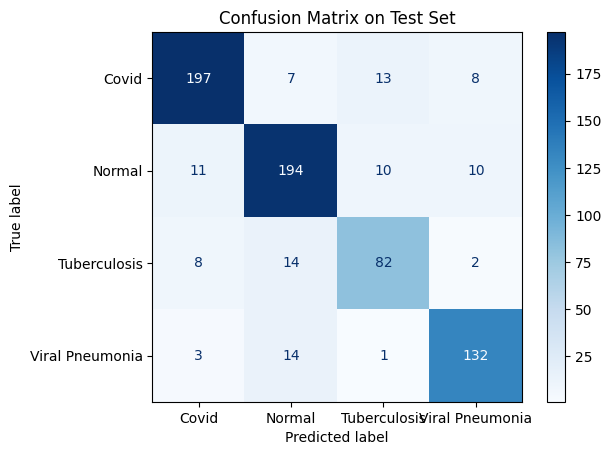

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------- Load Handcrafted Features ----------------------
hog_train = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_train.csv")
glcm_train = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_train.csv")
hog_test = pd.read_csv("/kaggle/input/handcrafted-features/hog_features_test.csv")
glcm_test = pd.read_csv("/kaggle/input/handcrafted-features/glcm_features_test.csv")

for df in [hog_train, glcm_train, hog_test, glcm_test]:
    df.columns = df.columns.str.strip().str.lower()

labels_train = hog_train["disease"].values
labels_test = hog_test["disease"].values

for df in [hog_train, glcm_train, hog_test, glcm_test]:
    df.drop(columns=["image_name", "disease"], inplace=True)

handcrafted_train = np.hstack([hog_train.values, glcm_train.values])
handcrafted_test = np.hstack([hog_test.values, glcm_test.values])

# ---------------------- Encode Labels ----------------------
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

# ---------------------- Load and Preprocess Images ----------------------
data_dir_train = "/kaggle/input/segmented-images-train"
data_dir_test = "/kaggle/input/segmented-images-test"
categories = ["Covid", "Normal", "Tuberculosis", "Viral Pneumonia"]
img_size = (224, 224)

def load_images(data_dir):
    X_images = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            X_images.append(img_array)
    return np.array(X_images, dtype="float32")

X_train_images = load_images(data_dir_train)
X_test_images = load_images(data_dir_test)

# ---------------------- Extract Deep Features ----------------------
base_model = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

deep_features_train = feature_extractor.predict(X_train_images, batch_size=32, verbose=1)
deep_features_test = feature_extractor.predict(X_test_images, batch_size=32, verbose=1)

# ---------------------- Fuse and Standardize Features ----------------------
fused_train = np.hstack([deep_features_train, handcrafted_train])
fused_test = np.hstack([deep_features_test, handcrafted_test])

scaler = StandardScaler()
fused_train_scaled = scaler.fit_transform(fused_train)
fused_test_scaled = scaler.transform(fused_test)

# ---------------------- Parrot Optimization Algorithm ----------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def evaluate_solution(solution, X, y):
    selected_indices = np.where(solution == 1)[0]
    if len(selected_indices) == 0:
        return 0
    selected_X = X[:, selected_indices]
    model = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="multinomial", C=1.2)
    scores = cross_val_score(model, selected_X, y, cv=5, scoring='accuracy')
    return scores.mean()

def parrot_optimization(X, y, pop_size=14, generations=35, target_features=5000):
    np.random.seed(42)
    num_features = X.shape[1]
    population = np.zeros((pop_size, num_features), dtype=int)
    for i in range(pop_size):
        indices = np.random.choice(num_features, target_features, replace=False)
        population[i, indices] = 1

    best_solution = population[0]
    best_score = 0
    no_improve = 0

    for gen in range(generations):
        fitness_scores = np.array([evaluate_solution(ind, X, y) for ind in population])
        best_idx = np.argmax(fitness_scores)

        if fitness_scores[best_idx] > best_score:
            best_score = fitness_scores[best_idx]
            best_solution = population[best_idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        print(f"Generation {gen+1}/{generations} - Best CV Accuracy: {best_score:.4f}")
        if no_improve >= 6:
            print("Early stopping triggered.")
            break

        new_population = []
        for i in range(pop_size):
            individual = population[i].copy()
            flip_indices = np.random.choice(np.where(individual == 1)[0], max(1, int(0.05 * target_features)), replace=False)
            individual[flip_indices] = 0
            new_indices = np.random.choice(np.where(individual == 0)[0], len(flip_indices), replace=False)
            individual[new_indices] = 1
            new_population.append(individual)

        population = np.array(new_population)

    return best_solution

# ---------------------- Apply POA ----------------------
feature_mask = parrot_optimization(fused_train_scaled, labels_train_encoded, target_features=5000)
X_train_selected = fused_train_scaled[:, feature_mask == 1]
X_test_selected = fused_test_scaled[:, feature_mask == 1]

# ---------------------- Final Neural Network Classifier ----------------------
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_selected, labels_train_encoded, test_size=0.15, random_state=42)

class_weights = compute_class_weight("balanced", classes=np.unique(y_train_final), y=y_train_final)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_selected.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(labels_train_encoded)), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

history = model.fit(X_train_final, y_train_final,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    class_weight=class_weights_dict,
                    callbacks=[early_stop],
                    verbose=2)

train_acc = model.evaluate(X_train_selected, labels_train_encoded, verbose=0)[1]
test_acc = model.evaluate(X_test_selected, labels_test_encoded, verbose=0)[1]

print(f"Train Accuracy after POA + Improved NN: {train_acc * 100:.2f}%")
print(f"Test Accuracy after POA + Improved NN: {test_acc * 100:.2f}%")

# ---------------------- Save Artifacts ----------------------
model.save("poa_improved_nn_model.h5")
joblib.dump(scaler, "poa_feature_scaler.pkl")
joblib.dump(label_encoder, "poa_label_encoder.pkl")
joblib.dump(feature_mask, "poa_feature_mask.pkl")
print("Model, scaler, label encoder, and feature mask saved!")

# ---------------------- Confusion Matrix ----------------------
y_pred = np.argmax(model.predict(X_test_selected), axis=1)
cm = confusion_matrix(labels_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()


### Trying Severity Assessment for only Covid 19

In [9]:
# 1. Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 2. Load metadata
metadata_path = '/kaggle/input/covid-19-severity/metadata.csv'
image_dir = '/kaggle/input/covid-19-severity/segmented_images/segmented_png'

df = pd.read_csv(metadata_path, sep=';')

# 3. Add severity class
def get_severity(score):
    if score <= 6:
        return 'Low'
    elif score <= 12:
        return 'Mild'
    else:
        return 'High'

df['Severity'] = df['BrixiaScoreGlobal'].apply(get_severity)

# 4. Link image paths
df['ImagePath'] = df['Filename'].apply(lambda x: os.path.join(image_dir, x.replace('.dcm', '.png')))
df = df[df['ImagePath'].apply(os.path.exists)]  # Keep only available images

# 5. Encode labels
label_encoder = LabelEncoder()
df['SeverityLabel'] = label_encoder.fit_transform(df['Severity'])

# 6. Split into 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['SeverityLabel'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['SeverityLabel'], random_state=42)

# 7. Image generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Severity',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='ImagePath',
    y_col='Severity',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Severity',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# 8. Build model with EfficientNetV2L
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 9. Train model
model.fit(train_gen, validation_data=val_gen, epochs=10)

# 10. Save model
model.save('/kaggle/working/severity_model.h5')
print("✅ Model saved to /kaggle/working/severity_model.h5")

# 11. Load model and evaluate
model = load_model('/kaggle/working/severity_model.h5')

# Evaluate on Validation
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n📊 Validation Accuracy: {val_acc * 100:.2f}%")

# Evaluate on Test
test_loss, test_acc = model.evaluate(test_gen)
print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")

Found 3286 validated image filenames belonging to 3 classes.
Found 704 validated image filenames belonging to 3 classes.
Found 705 validated image filenames belonging to 3 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.4981 - loss: 0.9453 - val_accuracy: 0.3778 - val_loss: 1.1010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6953 - loss: 0.6687 - val_accuracy: 0.2940 - val_loss: 1.2334
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7616 - loss: 0.5349 - val_accuracy: 0.6264 - val_loss: 0.8160
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8368 - loss: 0.4091 - val_accuracy: 0.5582 - val_loss: 1.0629
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8766 - loss: 0.3130 - val_accuracy: 0.5866 - val_loss: 1.0569
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9255 - loss: 0.1973 - val_accuracy: 0.4815 - val_loss: 1.4494
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9333 - loss: 0.1717 - val_accuracy: 0.3011 - val_loss: 1.6049
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9575 - loss: 0.1223 - val_accuracy: 0.191

In [10]:
# Load trained model
model = load_model('/kaggle/working/severity_model.h5')

# 12. Function to predict severity
def predict_severity(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0]
    class_idx = np.argmax(pred)
    severity = label_encoder.inverse_transform([class_idx])[0]

    print(f"🩻 Predicted Severity: {severity} (Confidence: {pred[class_idx]*100:.2f}%)")

# Example usage
example_path = '/kaggle/input/covid-19-severity/segmented_images/segmented_png/10011454155587105152.png'
predict_severity(example_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
🩻 Predicted Severity: Low (Confidence: 50.34%)


In [7]:
!pip install mealpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 70.3 MB/s eta 0:00:00:00:010:01


In [ ]:
# STEP 1: IMPORTS
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
import random

# STEP 2: LOAD METADATA (FIXED DELIMITER ISSUE)
metadata = pd.read_csv("/kaggle/input/covid-19-severity/metadata.csv", delimiter=';')

# STEP 3: MAP SEVERITY FROM BRIXIA SCORE
def brixia_to_severity(score):
    if score <= 6:
        return "Mild"
    elif score <= 12:
        return "Moderate"
    else:
        return "Severe"

metadata['Severity'] = metadata['BrixiaScoreGlobal'].apply(brixia_to_severity)
le = LabelEncoder()
metadata['SeverityEncoded'] = le.fit_transform(metadata['Severity'])

# STEP 4: LOAD SEGMENTED IMAGES
image_dir = "/kaggle/input/covid-19-severity/segmented_images/segmented_png"
image_size = (224, 224)
images = []
labels = []

for i, row in metadata.iterrows():
    filename = row["Filename"].replace(".dcm", ".png")
    path = os.path.join(image_dir, filename)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, image_size)
        img = preprocess_input(img)
        images.append(img)
        labels.append(row["SeverityEncoded"])

images = np.array(images)
labels = np.array(labels)
print("Loaded:", images.shape, labels.shape)

# STEP 5: SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# STEP 6: CNN FEATURE EXTRACTION
base_model = EfficientNetV2L(include_top=False, input_tensor=Input(shape=(224, 224, 3)), weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
cnn_model = Model(inputs=base_model.input, outputs=x)

X_train_features = cnn_model.predict(X_train, batch_size=32, verbose=1)
X_test_features = cnn_model.predict(X_test, batch_size=32, verbose=1)

# STEP 7: ELM SETUP
n_features = X_train_features.shape[1]
n_classes = len(np.unique(labels))
n_hidden_neurons = 200

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

Y_train_oh = one_hot(y_train, n_classes)

# STEP 8: FITNESS FUNCTION
def evaluate_fitness(W, b):
    H = sigmoid(np.dot(X_train_features, W) + b)
    try:
        beta = np.dot(np.linalg.pinv(H), Y_train_oh)
    except np.linalg.LinAlgError:
        return float("inf")
    pred_Y = sigmoid(np.dot(X_train_features, W) + b).dot(beta)
    pred_labels = np.argmax(pred_Y, axis=1)
    acc = accuracy_score(y_train, pred_labels)
    return 1 - acc

# STEP 9: SIMPLE CUSTOM ICA IMPLEMENTATION
def run_custom_ica(pop_size=10, num_imperialists=3, max_iter=100):
    dim = (n_features + 1) * n_hidden_neurons
    lb, ub = -1, 1
    
    # Initialize population
    population = [np.random.uniform(lb, ub, dim) for _ in range(pop_size)]
    fitness = [evaluate_fitness(ind[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons),
                                ind[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons)) for ind in population]
    
    # Sort by fitness
    sorted_idx = np.argsort(fitness)
    population = [population[i] for i in sorted_idx]
    fitness = [fitness[i] for i in sorted_idx]

    imperialists = population[:num_imperialists]
    colonies = population[num_imperialists:]

    for iteration in range(max_iter):
        for i in range(len(colonies)):
            imp_idx = i % num_imperialists
            diff = imperialists[imp_idx] - colonies[i]
            colonies[i] += 0.1 * diff + np.random.normal(0, 0.05, dim)
            colonies[i] = np.clip(colonies[i], lb, ub)

        all_candidates = imperialists + colonies
        all_fitness = [evaluate_fitness(ind[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons),
                                        ind[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons)) for ind in all_candidates]
        sorted_idx = np.argsort(all_fitness)
        imperialists = [all_candidates[i] for i in sorted_idx[:num_imperialists]]
        colonies = [all_candidates[i] for i in sorted_idx[num_imperialists:]]

        print(f"Iteration {iteration+1}/{max_iter} - Best Fitness: {all_fitness[sorted_idx[0]]:.4f}")

    best_solution = imperialists[0]
    best_fitness = evaluate_fitness(best_solution[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons),
                                    best_solution[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons))
    return best_solution, best_fitness

# STEP 10: RUN CUSTOM ICA
best_solution, best_fitness = run_custom_ica()
print("✅ Best training error:", best_fitness)

# STEP 11: FINAL TEST PREDICTION
W_best = best_solution[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons)
b_best = best_solution[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons)

H_train = sigmoid(np.dot(X_train_features, W_best) + b_best)
beta = np.dot(np.linalg.pinv(H_train), Y_train_oh)

H_test = sigmoid(np.dot(X_test_features, W_best) + b_best)
pred_Y_test = np.dot(H_test, beta)
pred_test_labels = np.argmax(pred_Y_test, axis=1)

test_accuracy = accuracy_score(y_test, pred_test_labels)
print("🎯 Test Accuracy:", test_accuracy)   


Loaded: (4695, 224, 224, 3) (4695,)
118/118 ━━━━━━━━━━━━━━━━━━━━ 70s 461ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 591ms/step
Iteration 1/100 - Best Fitness: 0.3442
Iteration 2/100 - Best Fitness: 0.3442
Iteration 3/100 - Best Fitness: 0.3442
Iteration 4/100 - Best Fitness: 0.3442
Iteration 5/100 - Best Fitness: 0.3435
Iteration 6/100 - Best Fitness: 0.3435
Iteration 7/100 - Best Fitness: 0.3419
Iteration 8/100 - Best Fitness: 0.3387
Iteration 9/100 - Best Fitness: 0.3387
Iteration 10/100 - Best Fitness: 0.3387
Iteration 11/100 - Best Fitness: 0.3379
Iteration 12/100 - Best Fitness: 0.3379
Iteration 13/100 - Best Fitness: 0.3328
Iteration 14/100 - Best Fitness: 0.3328
Iteration 15/100 - Best Fitness: 0.3328
Iteration 16/100 - Best Fitness: 0.3328
Iteration 17/100 - Best Fitness: 0.3275
Iteration 18/100 - Best Fitness: 0.3275
Iteration 19/100 - Best Fitness: 0.3275
Iteration 20/100 - Best Fitness: 0.3275
Iteration 21/100 - Best Fitness: 0.3235
Iteration 22/100 - Best Fitness: 0.3235
Iterati

In [10]:
# STEP 1: IMPORTS
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
import random

# STEP 2: LOAD METADATA (FIXED DELIMITER ISSUE)
metadata = pd.read_csv("/kaggle/input/covid-19-severity/metadata.csv", delimiter=';')

# STEP 3: MAP SEVERITY FROM BRIXIA SCORE
def brixia_to_severity(score):
    if score <= 6:
        return "Mild"
    elif score <= 12:
        return "Moderate"
    else:
        return "Severe"

metadata['Severity'] = metadata['BrixiaScoreGlobal'].apply(brixia_to_severity)
le = LabelEncoder()
metadata['SeverityEncoded'] = le.fit_transform(metadata['Severity'])

# STEP 4: LOAD SEGMENTED IMAGES
image_dir = "/kaggle/input/covid-19-severity/segmented_images/segmented_png"
image_size = (224, 224)
images = []
labels = []

for i, row in metadata.iterrows():
    filename = row["Filename"].replace(".dcm", ".png")
    path = os.path.join(image_dir, filename)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, image_size)
        img = preprocess_input(img)
        images.append(img)
        labels.append(row["SeverityEncoded"])

images = np.array(images)
labels = np.array(labels)
print("Loaded:", images.shape, labels.shape)

# STEP 5: SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# STEP 6: CNN FEATURE EXTRACTION
base_model = EfficientNetV2L(include_top=False, input_tensor=Input(shape=(224, 224, 3)), weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
cnn_model = Model(inputs=base_model.input, outputs=x)

X_train_features = cnn_model.predict(X_train, batch_size=32, verbose=1)
X_test_features = cnn_model.predict(X_test, batch_size=32, verbose=1)

# STEP 7: ELM SETUP
n_features = X_train_features.shape[1]
n_classes = len(np.unique(labels))
n_hidden_neurons = 300

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

Y_train_oh = one_hot(y_train, n_classes)

# STEP 8: FITNESS FUNCTION
def evaluate_fitness(W, b):
    H = sigmoid(np.dot(X_train_features, W) + b)
    try:
        beta = np.dot(np.linalg.pinv(H), Y_train_oh)
    except np.linalg.LinAlgError:
        return float("inf")
    pred_Y = sigmoid(np.dot(X_train_features, W) + b).dot(beta)
    pred_labels = np.argmax(pred_Y, axis=1)
    acc = accuracy_score(y_train, pred_labels)
    return 1 - acc

# STEP 9: SIMPLE CUSTOM ICA IMPLEMENTATION
def run_custom_ica(pop_size=50, num_imperialists=3, max_iter=200):
    dim = (n_features + 1) * n_hidden_neurons
    lb, ub = -1, 1
    
    # Initialize population
    population = [np.random.uniform(lb, ub, dim) for _ in range(pop_size)]
    fitness = [evaluate_fitness(ind[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons),
                                ind[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons)) for ind in population]
    
    # Sort by fitness
    sorted_idx = np.argsort(fitness)
    population = [population[i] for i in sorted_idx]
    fitness = [fitness[i] for i in sorted_idx]

    imperialists = population[:num_imperialists]
    colonies = population[num_imperialists:]

    for iteration in range(max_iter):
        for i in range(len(colonies)):
            imp_idx = i % num_imperialists
            diff = imperialists[imp_idx] - colonies[i]
            colonies[i] += 0.1 * diff + np.random.normal(0, 0.05, dim)
            colonies[i] = np.clip(colonies[i], lb, ub)

        all_candidates = imperialists + colonies
        all_fitness = [evaluate_fitness(ind[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons),
                                        ind[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons)) for ind in all_candidates]
        sorted_idx = np.argsort(all_fitness)
        imperialists = [all_candidates[i] for i in sorted_idx[:num_imperialists]]
        colonies = [all_candidates[i] for i in sorted_idx[num_imperialists:]]

        print(f"Iteration {iteration+1}/{max_iter} - Best Fitness: {all_fitness[sorted_idx[0]]:.4f}")

    best_solution = imperialists[0]
    best_fitness = evaluate_fitness(best_solution[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons),
                                    best_solution[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons))
    return best_solution, best_fitness

# STEP 10: RUN CUSTOM ICA
best_solution, best_fitness = run_custom_ica()
print("✅ Best training error:", best_fitness)

# STEP 11: FINAL TEST PREDICTION
W_best = best_solution[:n_features * n_hidden_neurons].reshape(n_features, n_hidden_neurons)
b_best = best_solution[n_features * n_hidden_neurons:].reshape(1, n_hidden_neurons)

H_train = sigmoid(np.dot(X_train_features, W_best) + b_best)
beta = np.dot(np.linalg.pinv(H_train), Y_train_oh)

H_test = sigmoid(np.dot(X_test_features, W_best) + b_best)
pred_Y_test = np.dot(H_test, beta)
pred_test_labels = np.argmax(pred_Y_test, axis=1)

test_accuracy = accuracy_score(y_test, pred_test_labels)
print("🎯 Test Accuracy:", test_accuracy)


Loaded: (4695, 224, 224, 3) (4695,)
118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 442ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step
Iteration 1/200 - Best Fitness: 0.3150
Iteration 2/200 - Best Fitness: 0.3150
Iteration 3/200 - Best Fitness: 0.3094
Iteration 4/200 - Best Fitness: 0.3094
Iteration 5/200 - Best Fitness: 0.3094
Iteration 6/200 - Best Fitness: 0.3088
Iteration 7/200 - Best Fitness: 0.3046
Iteration 8/200 - Best Fitness: 0.3046
Iteration 9/200 - Best Fitness: 0.3046
Iteration 10/200 - Best Fitness: 0.3014
Iteration 11/200 - Best Fitness: 0.3014
Iteration 12/200 - Best Fitness: 0.3009
Iteration 13/200 - Best Fitness: 0.2990
Iteration 14/200 - Best Fitness: 0.2990
Iteration 15/200 - Best Fitness: 0.2990
Iteration 16/200 - Best Fitness: 0.2958
Iteration 17/200 - Best Fitness: 0.2958
Iteration 18/200 - Best Fitness: 0.2958
Iteration 19/200 - Best Fitness: 0.2958
Iteration 20/200 - Best Fitness: 0.2958
Iteration 21/200 - Best Fitness: 0.2958
Iteration 22/200 - Best Fitness: 0.2958
Iterati

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# STEP 1: LOAD METADATA
metadata = pd.read_csv("/kaggle/input/covid-19-severity/metadata.csv", delimiter=';')

# STEP 2: MAP SEVERITY FROM BRIXIA SCORE
def brixia_to_severity(score):
    if score <= 6:
        return "Mild"
    elif score <= 12:
        return "Moderate"
    else:
        return "Severe"

metadata['Severity'] = metadata['BrixiaScoreGlobal'].apply(brixia_to_severity)
le = LabelEncoder()
metadata['SeverityEncoded'] = le.fit_transform(metadata['Severity'])

# STEP 3: LOAD SEGMENTED IMAGES
image_dir = "/kaggle/input/covid-19-severity/segmented_images/segmented_png"
image_size = (224, 224)
images = []
labels = []

for i, row in metadata.iterrows():
    filename = row["Filename"].replace(".dcm", ".png")
    path = os.path.join(image_dir, filename)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, image_size)
        img = preprocess_input(img)
        images.append(img)
        labels.append(row["SeverityEncoded"])

images = np.array(images)
labels = np.array(labels)

# STEP 4: SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# STEP 5: DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# STEP 6: FINE-TUNE EFFICIENTNETV2L
base_model = EfficientNetV2L(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(len(np.unique(labels)), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# STEP 7: COMPILE MODEL
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# STEP 8: TRAIN MODEL
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[reduce_lr, early_stop])

# STEP 9: EVALUATE MODEL
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Optional: Hyperparameter Tuning
# from kerastuner import HyperModel
# class CovidModel(HyperModel):
#     def __init__(self, input_shape, num_classes):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#
#     def build(self, hp):
#         base_model = EfficientNetV2L(include_top=False, input_shape=self.input_shape, weights="imagenet")
#         base_model.trainable = True
#
#         x = base_model.output
#         x = GlobalAveragePooling2D()(x)
#         x = Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(x)
#         x = Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(x)
#         outputs = Dense(self.num_classes, activation='softmax')(x)
#
#         model = Model(inputs=base_model.input, outputs=outputs)
#         model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, step=1e-4)),
#                       loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         return model
#
# tuner = Hyperband(CovidModel(input_shape=(224, 224, 3), num_classes=len(np.unique(labels)),
#                            objective='val_accuracy',
#                            max_epochs=50,
#                            factor=3,
#                            directory='my_dir',
#                            project_name='covid_tuning')
# tuner.search_space(datagen.flow(X_train, y_train, batch_size=32),
#                    validation_data=(X_test, y_test))
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hps)
# best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
#                validation_data=(X_test, y_test),
#                epochs=50)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 92/118 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5265 - loss: 0.9234